# Analytics - Product Quality

#### Date: 29/06/2023

#### SUMMARY:

- This notebook represents the project quality analysis of the date exposed right above. 

### TEAM:

##### Semester: 2023/01
##### Professor: Hilmer Neri

##### Members:

- Amanda Gonçalves
- Arthur Miranda
- Arthur Rodrigues
- Álvaro Leles
- Fause Carlos
- Filipe Souto
- Gabriel Avelino
- Gabriel Bonifácio
- Gabriel Saraiva
- Guilherme de Morais
- Gustavo Costa
- Ian Fillipe
- Italo Vinicius
- Ítalo Fernandes
- Júlia Stefanie
- Mariana Letícia
- Mateus Fidelis


### LIBRARIES

In [34]:
# Deal with data
import pandas as pd
import json
from glob import glob
import os

# Deal with visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Deal with type hints
from typing import List

# Deal with time
import datetime

### GRAPH SETTINGS

In [35]:
%config InlineBackend.figure_format ='retina'
sns.set(font_scale=1.5)
sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})

### DATAFRAME SETTINGS

In [36]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

#### Replace your semester, project name, repository name, and the programming language extension

In [37]:
# Set your repo major name here
# Example: fga-eps-mds-2022-1-MeasureSoftGram-
repo_name = 'fga-eps-mds-2023-1-schedula-'

# Add your repos here
# Example: 'Front': 'py',
repos_language = {
    'front': 'ts',
    'gestor_de_usuarios': 'ts',
    'detalhador_de_chamados': 'ts',
    'gerenciador_de_localidades': 'ts',
    'gerenciador_de_tutoriais': 'ts',
    'gestor_de_alerta': 'ts',
}

### SonarCloud
##### Path to the folder with all your jsons

In [38]:
# Maybe you should change this path to your own path

sonar_files = glob('../analytics-raw-data2/*.json')

## Create DataFrame

#### Unmarshall json

In [39]:
def unmarshall(json_path: str) -> dict:
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
    return json_obj

#### Create a list with all valid columns

In [40]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'tests',
               'test_errors',
               'test_failures',
               'test_execution_time',
               'security_rating']

#### Extract files dataframe out of component dataframe

In [41]:
def get_files_df(df: pd.DataFrame) -> pd.DataFrame:

    files_df = df[df['qualifier'] == 'FIL']

    files_df = files_df.dropna(subset=['functions', 'complexity','comment_lines_density', 'duplicated_lines_density', 'coverage' ])

    return files_df

#### Extract directories dataframe out of component dataframe

In [42]:
def get_dir_df(df: pd.DataFrame) -> pd.DataFrame:
    dirs = df[df["qualifier"] == "DIR"]

    newdf = pd.to_numeric(dirs["tests"])

    max_value_index = newdf.idxmax()

    return dirs.loc[max_value_index]

#### Extract uts dataframe out of component dataframe

In [43]:
def get_uts_df(df: pd.DataFrame) -> pd.DataFrame:
    uts_df = df[df['qualifier'] == 'UTS']

    uts_df = uts_df.fillna(0)

    uts_df = uts_df.dropna(subset=['test_execution_time'])

    return uts_df

#### Generate component dataframe

In [44]:
def metric_per_file(json_dict: dict) -> List[dict]:
    file_json = []

    for component in json_dict['components']:
        ncloc_value = 0
        for measure in component['measures']:
            if measure['metric'] == 'ncloc':
                ncloc_value = float(measure['value'])
                break

        if (component['qualifier'] == 'FIL' and ncloc_value > 0) \
                or component['qualifier'] == 'DIR' \
                or component['qualifier'] == 'UTS':
            file_json.append(component)

    return file_json


def generate_component_dataframe_data(
        metrics_list: List[str],
        file_component_data: List[dict],
        language_extension: str) -> pd.DataFrame:

    df_columns = metrics_list

    files_df = pd.DataFrame(columns = df_columns)
    dirs_df = pd.DataFrame(columns = df_columns)
    uts_df = pd.DataFrame(columns = df_columns)

    for file in file_component_data:
        try:
                if file['qualifier'] == 'FIL' and file['language'] == language_extension:
                    for measure in file['measures']:
                        files_df.at[file['path'], measure['metric']] = measure['value']

                    files_df['qualifier'] = file['qualifier']

                elif file['qualifier'] == 'DIR':
                    for measure in file['measures']:
                        dirs_df.at[file['path'], measure['metric']] = measure['value']

                    dirs_df['qualifier'] = file['qualifier']

                elif file['qualifier'] == 'UTS':
                    for measure in file['measures']:
                        uts_df.at[file['path'], measure['metric']] = measure['value']

                    uts_df['qualifier'] = file['qualifier']

        except:
            pass

    files_df.reset_index(inplace = True)
    dirs_df.reset_index(inplace = True)
    uts_df.reset_index(inplace = True)

    files_df = files_df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)
    dirs_df = dirs_df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)
    uts_df = uts_df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    df = pd.concat([files_df, dirs_df, uts_df], axis=0)

    return df


def create_component_df(json_list):
    df = pd.DataFrame()

    for json_path in json_list:
        file_component = unmarshall(json_path)
        file_component_data = metric_per_file(file_component)

        base_name = os.path.basename(json_path)

        file_component_dataframe = generate_component_dataframe_data(
            metric_list,
            file_component_data,
            language_extension = repos_language[base_name.split("-")[6]])


        file_component_dataframe['filename'] = base_name

        df = pd.concat([df, file_component_dataframe], ignore_index=True)

    aux_df = df['filename'].str.split(r"-(\d+-\d+-\d+-\d+-\d+-\d+)-(.*?).json", expand=True)

    df['repository'] = aux_df[0]
    df['datetime'] = aux_df[1]
    df['version'] = aux_df[2]

    df = df.sort_values(by=['repository', 'datetime'])

    return df

In [45]:
file_component_df = create_component_df(sonar_files)
file_component_df.repository.unique()

array(['fga-eps-mds-2023-1-schedula-detalhador_de_chamados',
       'fga-eps-mds-2023-1-schedula-front',
       'fga-eps-mds-2023-1-schedula-gerenciador_de_localidades',
       'fga-eps-mds-2023-1-schedula-gerenciador_de_tutoriais',
       'fga-eps-mds-2023-1-schedula-gestor_de_alerta',
       'fga-eps-mds-2023-1-schedula-gestor_de_usuarios'], dtype=object)

### Create dataframe per repository

In [46]:
repos_dataframes = []

for repo in repos_language.keys():
    dataframe = file_component_df[file_component_df['repository'] == repo_name+repo]
    repos_dataframes.append({'name': repo, 'df': dataframe})

## Measure calculations according to Q-Rapids quality model

In [47]:
def _ncloc(df: pd.DataFrame) -> int:
    ncloc = 0
    for each in df['ncloc']:
        # try to cast the current ncloc value to int, if the value is NaN/Null, consider it as zero.
        try:
            n = int(each)
        except ValueError:
            n = 0
        ncloc += n

    return ncloc

## Quality Aspect - Maintainability

### Factor - Code Quality

#### Complexity

In [48]:
def m1(df: pd.DataFrame):

    files_df = get_files_df(df)

    density_non_complex_files = len(files_df[(files_df['complexity'].astype(float) /
                                              files_df['functions'].astype(float)) < 10]) / len(files_df)

    return density_non_complex_files

#### Comments

In [49]:
def m2(df: pd.DataFrame):

    files_df = get_files_df(df)

    density_comment_files = len(files_df[(files_df['comment_lines_density'].astype(float) > 10) &
                                         (files_df['comment_lines_density'].astype(float) < 30)]) / len(files_df)

    return density_comment_files

#### Duplications

In [50]:
def m3(df: pd.DataFrame):

    files_df = get_files_df(df)

    duplication = len(files_df[(files_df['duplicated_lines_density'].astype(float) < 5)])/len(files_df)

    return duplication

## Quality Aspect - Reliability

### Factor - Testing Status

#### Passed tests

In [51]:
def m4(df: pd.DataFrame):

    dir_df = get_dir_df(df)

    passed_tests = (float(dir_df['tests']) - (float(dir_df['test_errors']) + float(dir_df['test_failures']))) /\
               float(dir_df['tests'])

    return passed_tests

#### Fast test builds

In [52]:
def m5(df: pd.DataFrame):
    dir_df = get_uts_df(df)

    density_fast_test_builds = len(dir_df[(dir_df['test_execution_time'].astype(float)) < 300000]) /\
                               len(dir_df['test_execution_time'].astype(float))
    return density_fast_test_builds

#### Test coverage

In [53]:
def m6(df: pd.DataFrame):

    files_df = get_files_df(df)

    density_test_coverage = len(files_df[(files_df['coverage'].astype(float) > 60)]) / len(files_df)

    return density_test_coverage

## Calculate measures for each repository

In [54]:
def create_metrics_df(df: pd.DataFrame) -> pd.DataFrame:

    date_time_vec = df['datetime'].unique()

    m1_list = []
    m2_list = []
    m3_list = []
    m4_list = []
    m5_list = []
    m6_list = []

    ncloc_list = []
    repository_list = []
    version_list = []

    for version in date_time_vec:

        version_df = df[df['datetime'] == version]

        try:
            m1_list.append(m1(version_df))
        except Exception:
            m1_list.append(0)

        try:
            m2_list.append(m2(version_df))
        except Exception:
            m2_list.append(0)

        try:
            m3_list.append(m3(version_df))
        except Exception:
            m3_list.append(0)

        try:
            m4_list.append(m4(version_df))
        except Exception:
            m4_list.append(0)

        try:
            m5_list.append(m5(version_df))
        except Exception:
            m5_list.append(0)

        try:
            m6_list.append(m6(version_df))
        except Exception:
            m6_list.append(0)

        ncloc_list.append(_ncloc(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)

    final_dict = {
        'm1': m1_list,
        'm2': m2_list,
        'm3': m3_list,
        'm4': m4_list,
        'm5': m5_list,
        'm6': m6_list,
        'repository': repository_list,
        'version': version_list,
        'ncloc': ncloc_list
    }

    metrics_df = pd.DataFrame(final_dict)

    return metrics_df

In [55]:
# Here we will create a dictionary with the metrics for each repository
metrics = {}

for repo_df in repos_dataframes:
    metrics[repo_df['name']] = create_metrics_df(repo_df['df'])

## Data visualization

In this area you will need to plot the metrics of each repository.

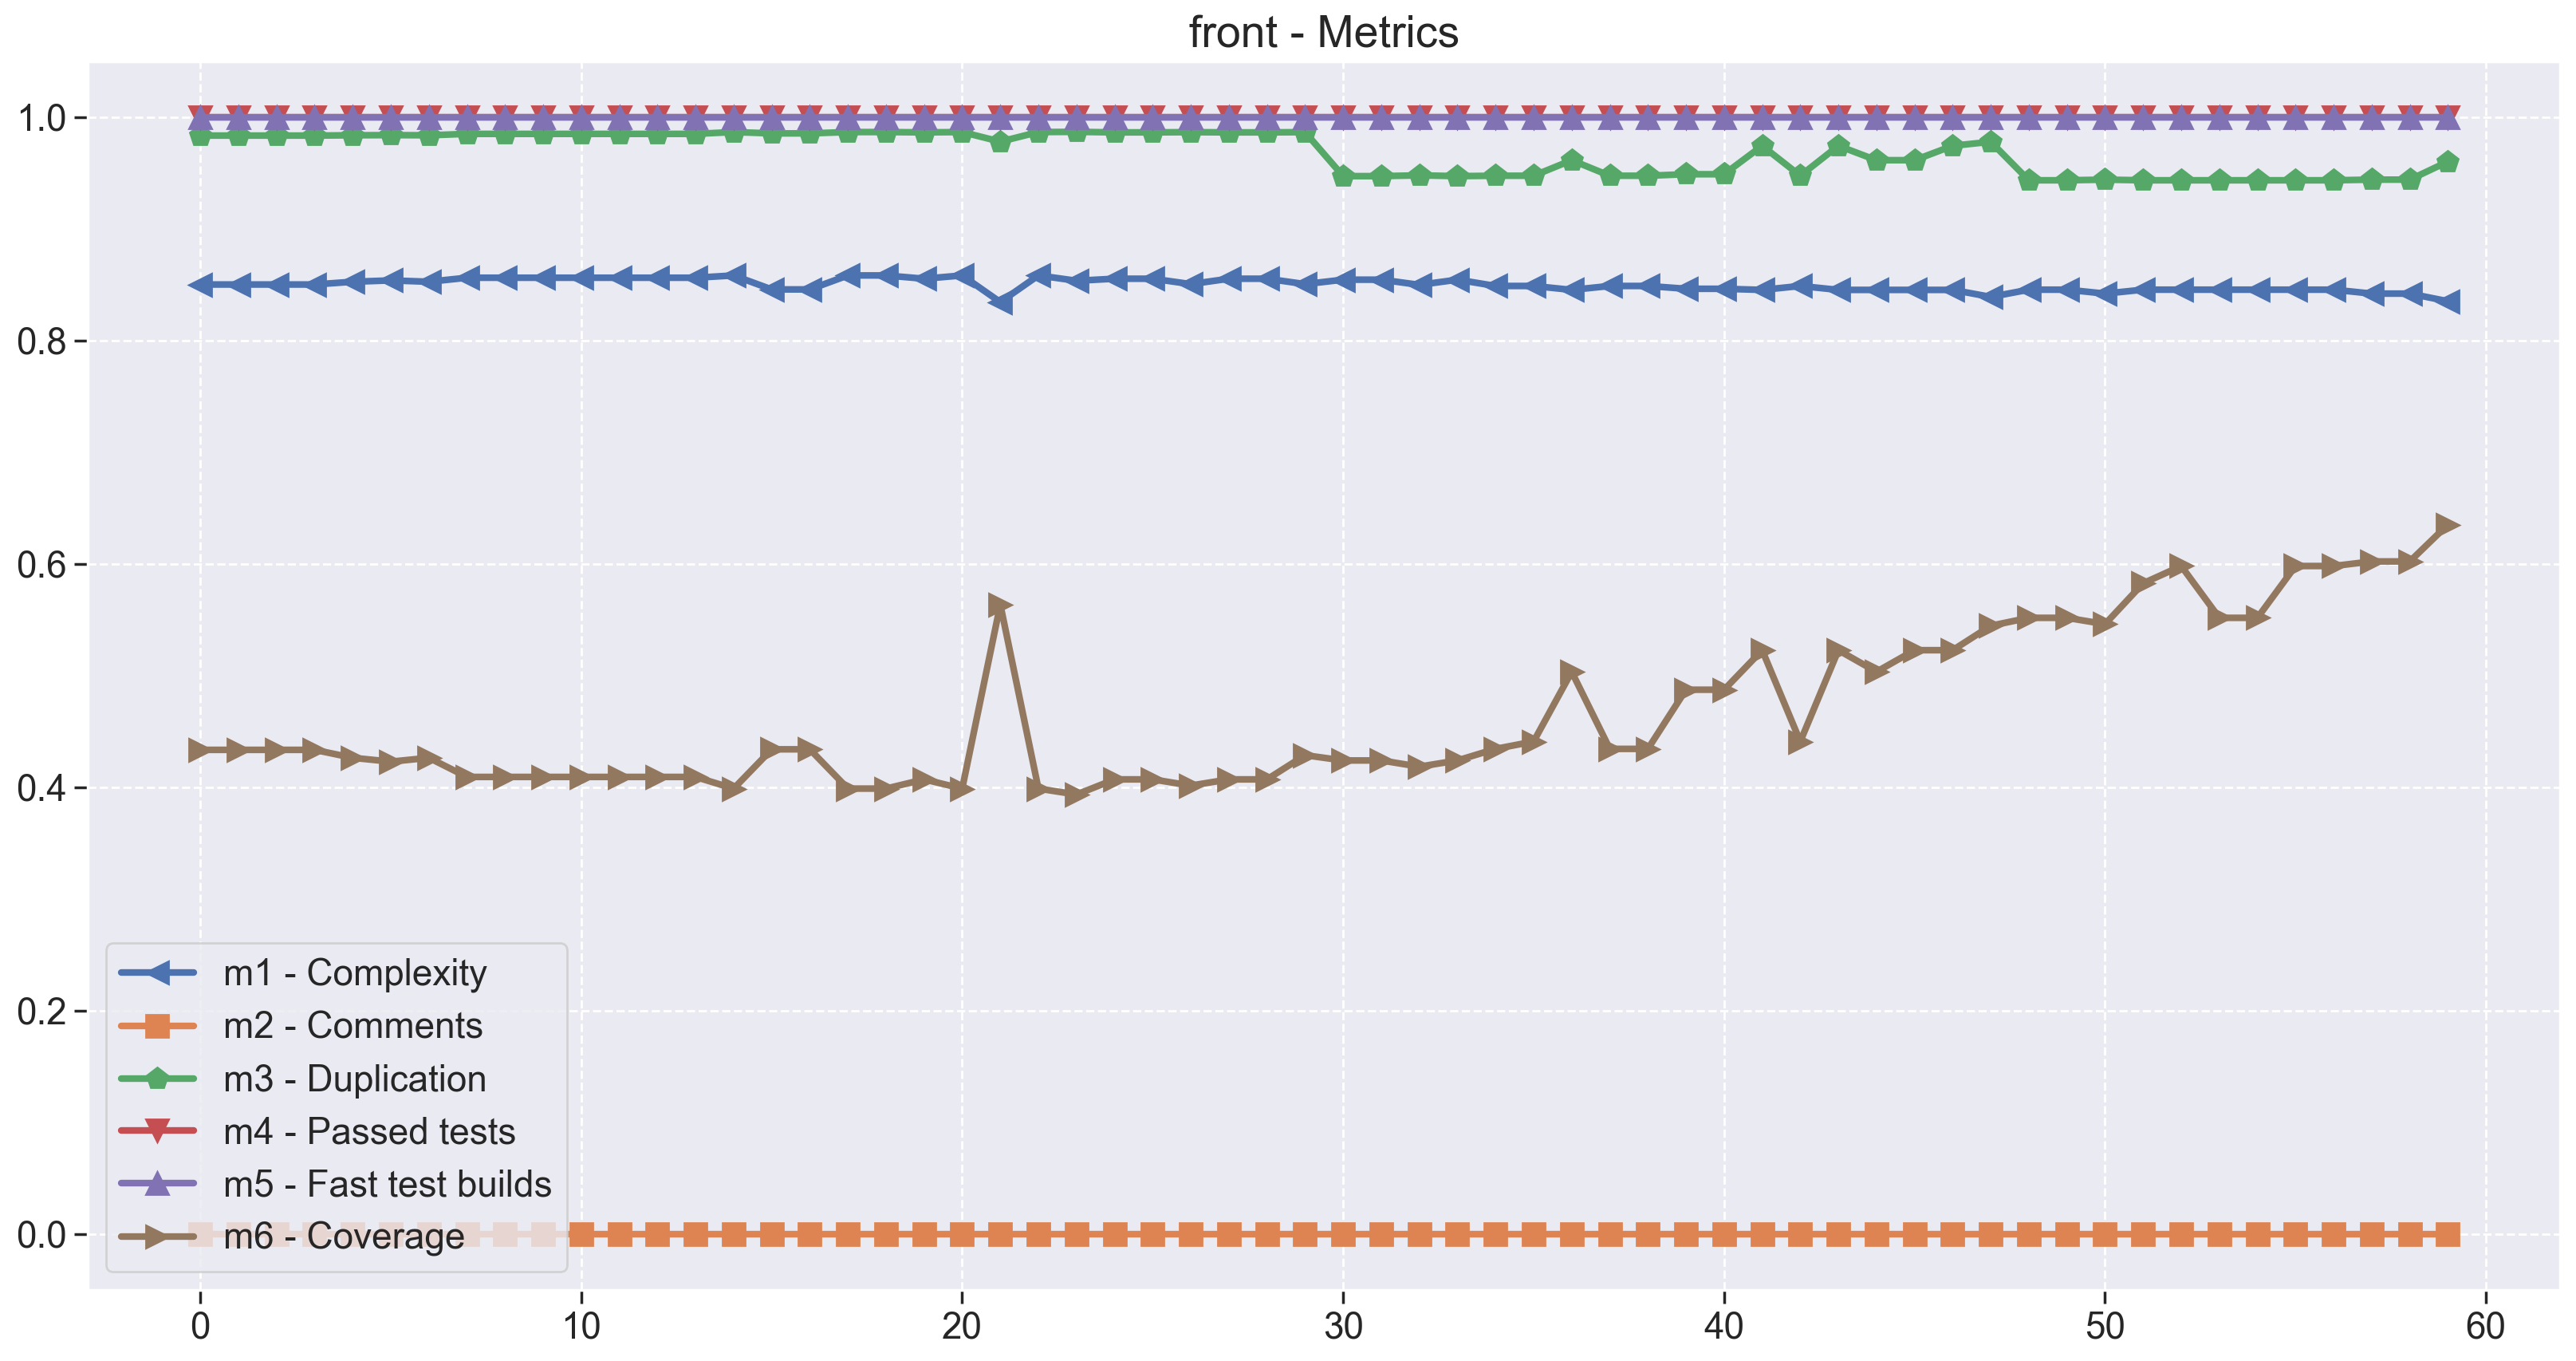

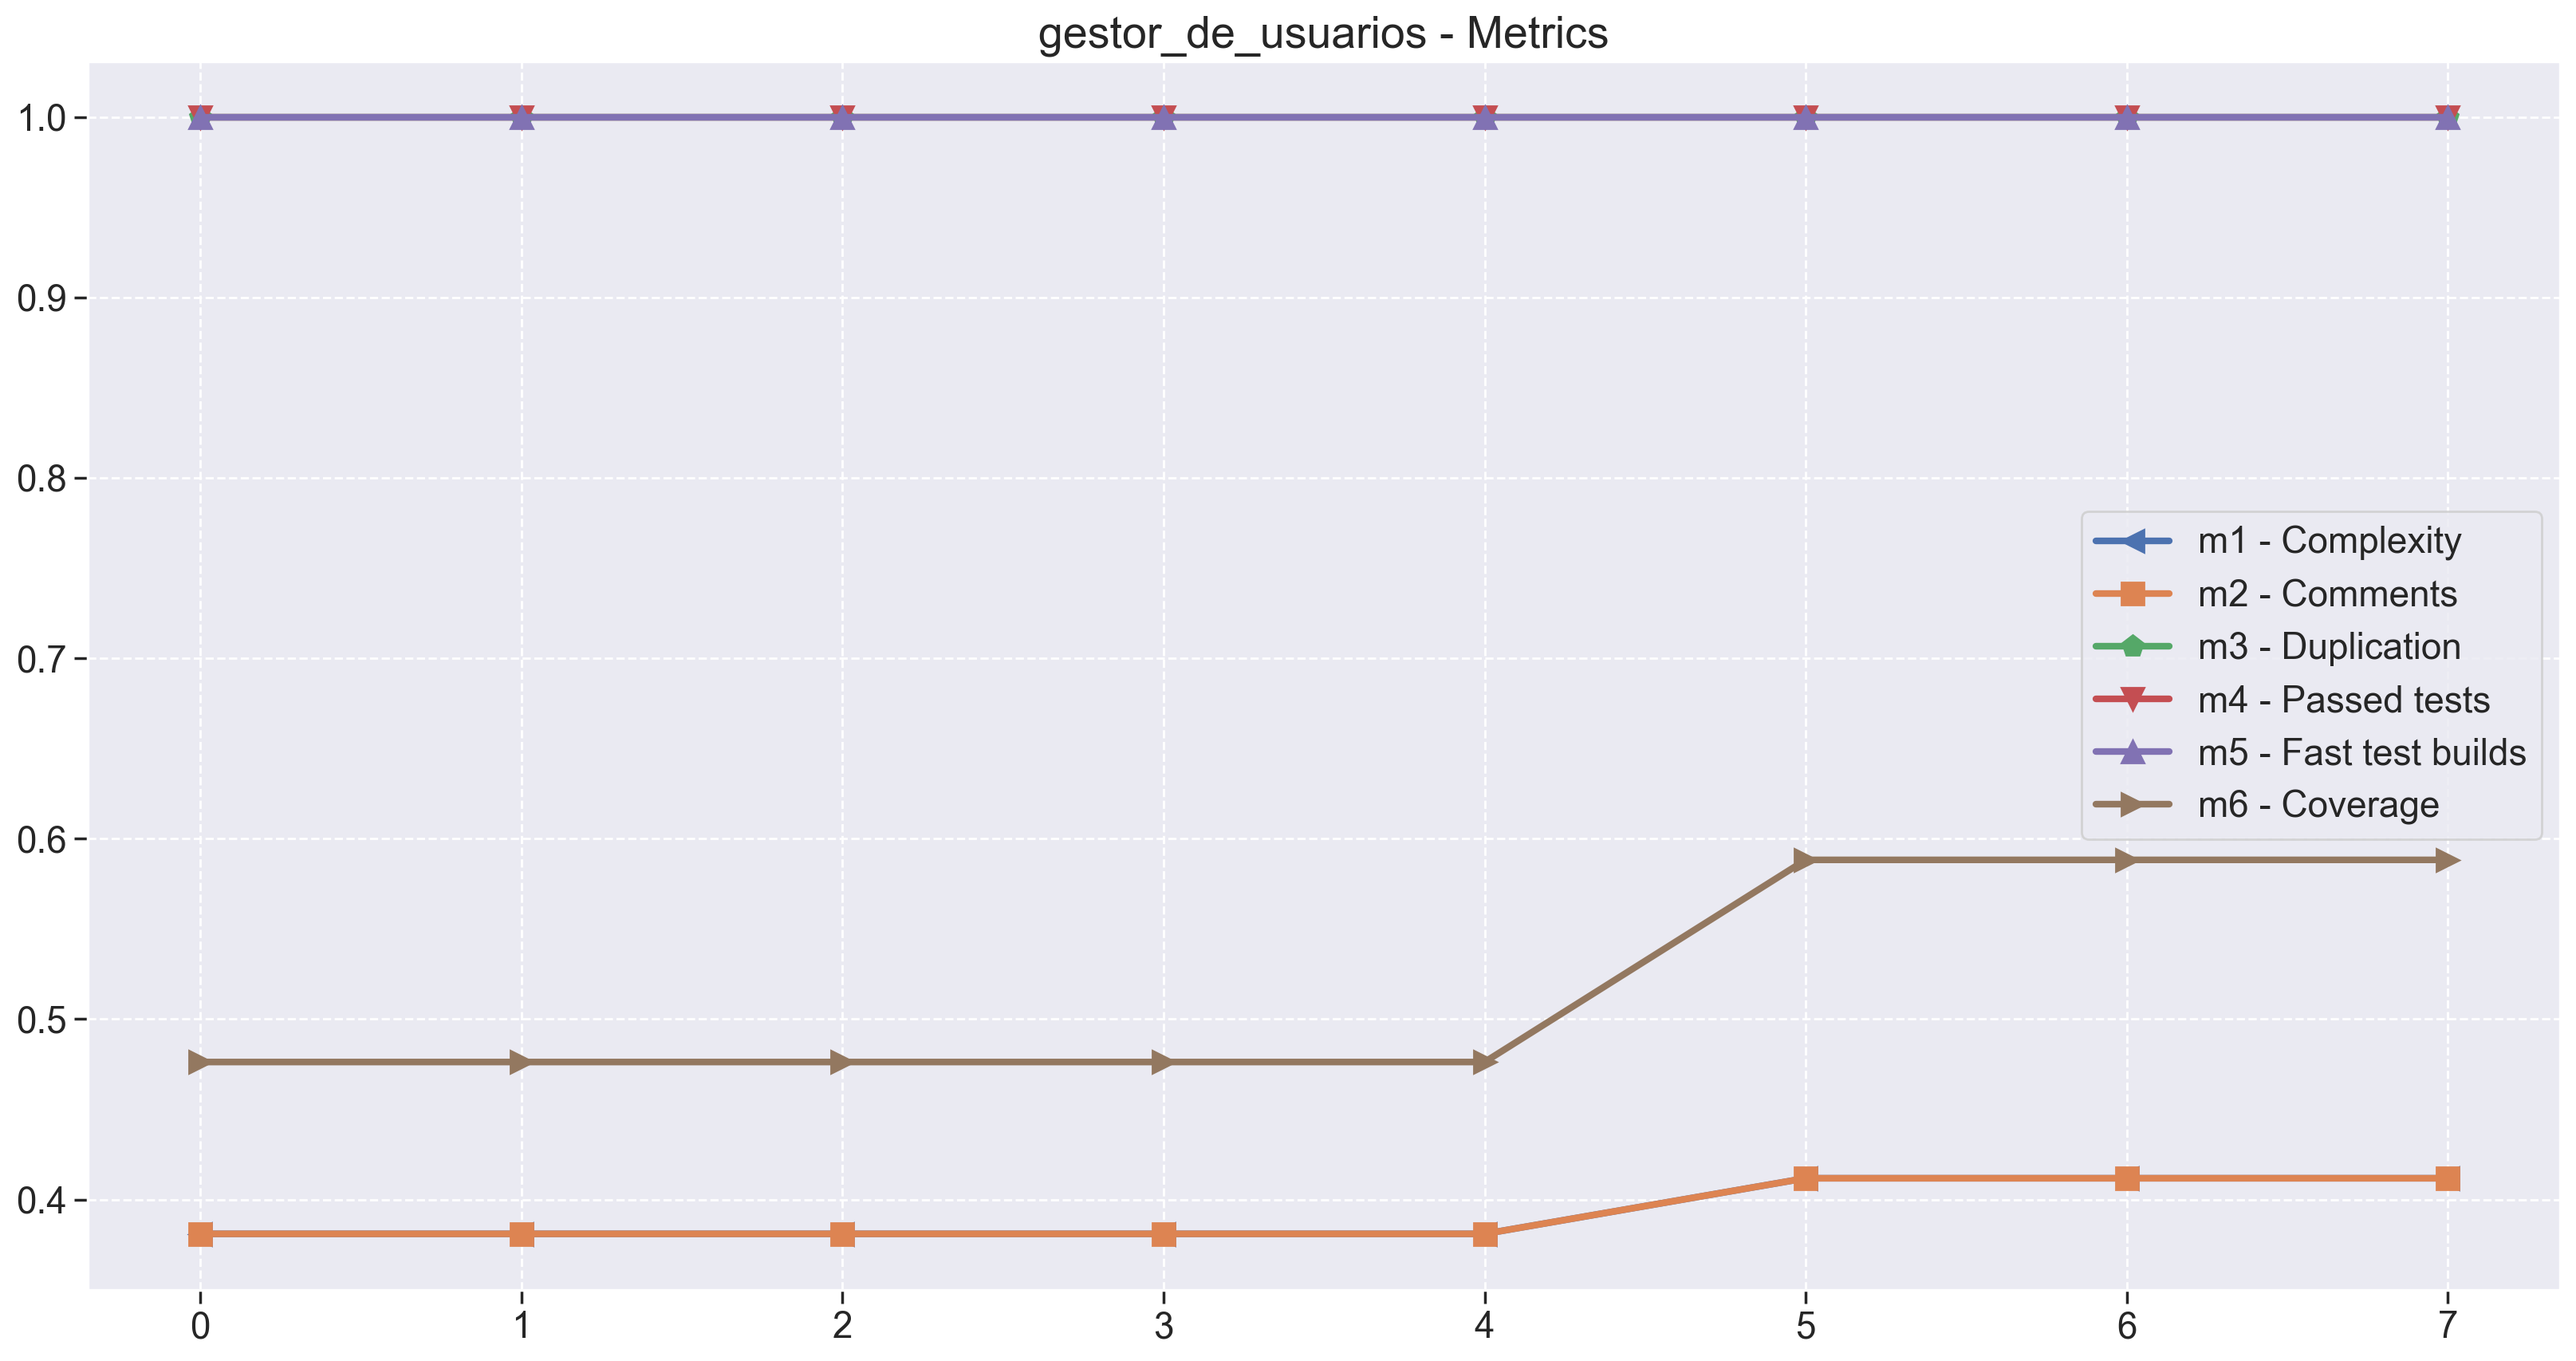

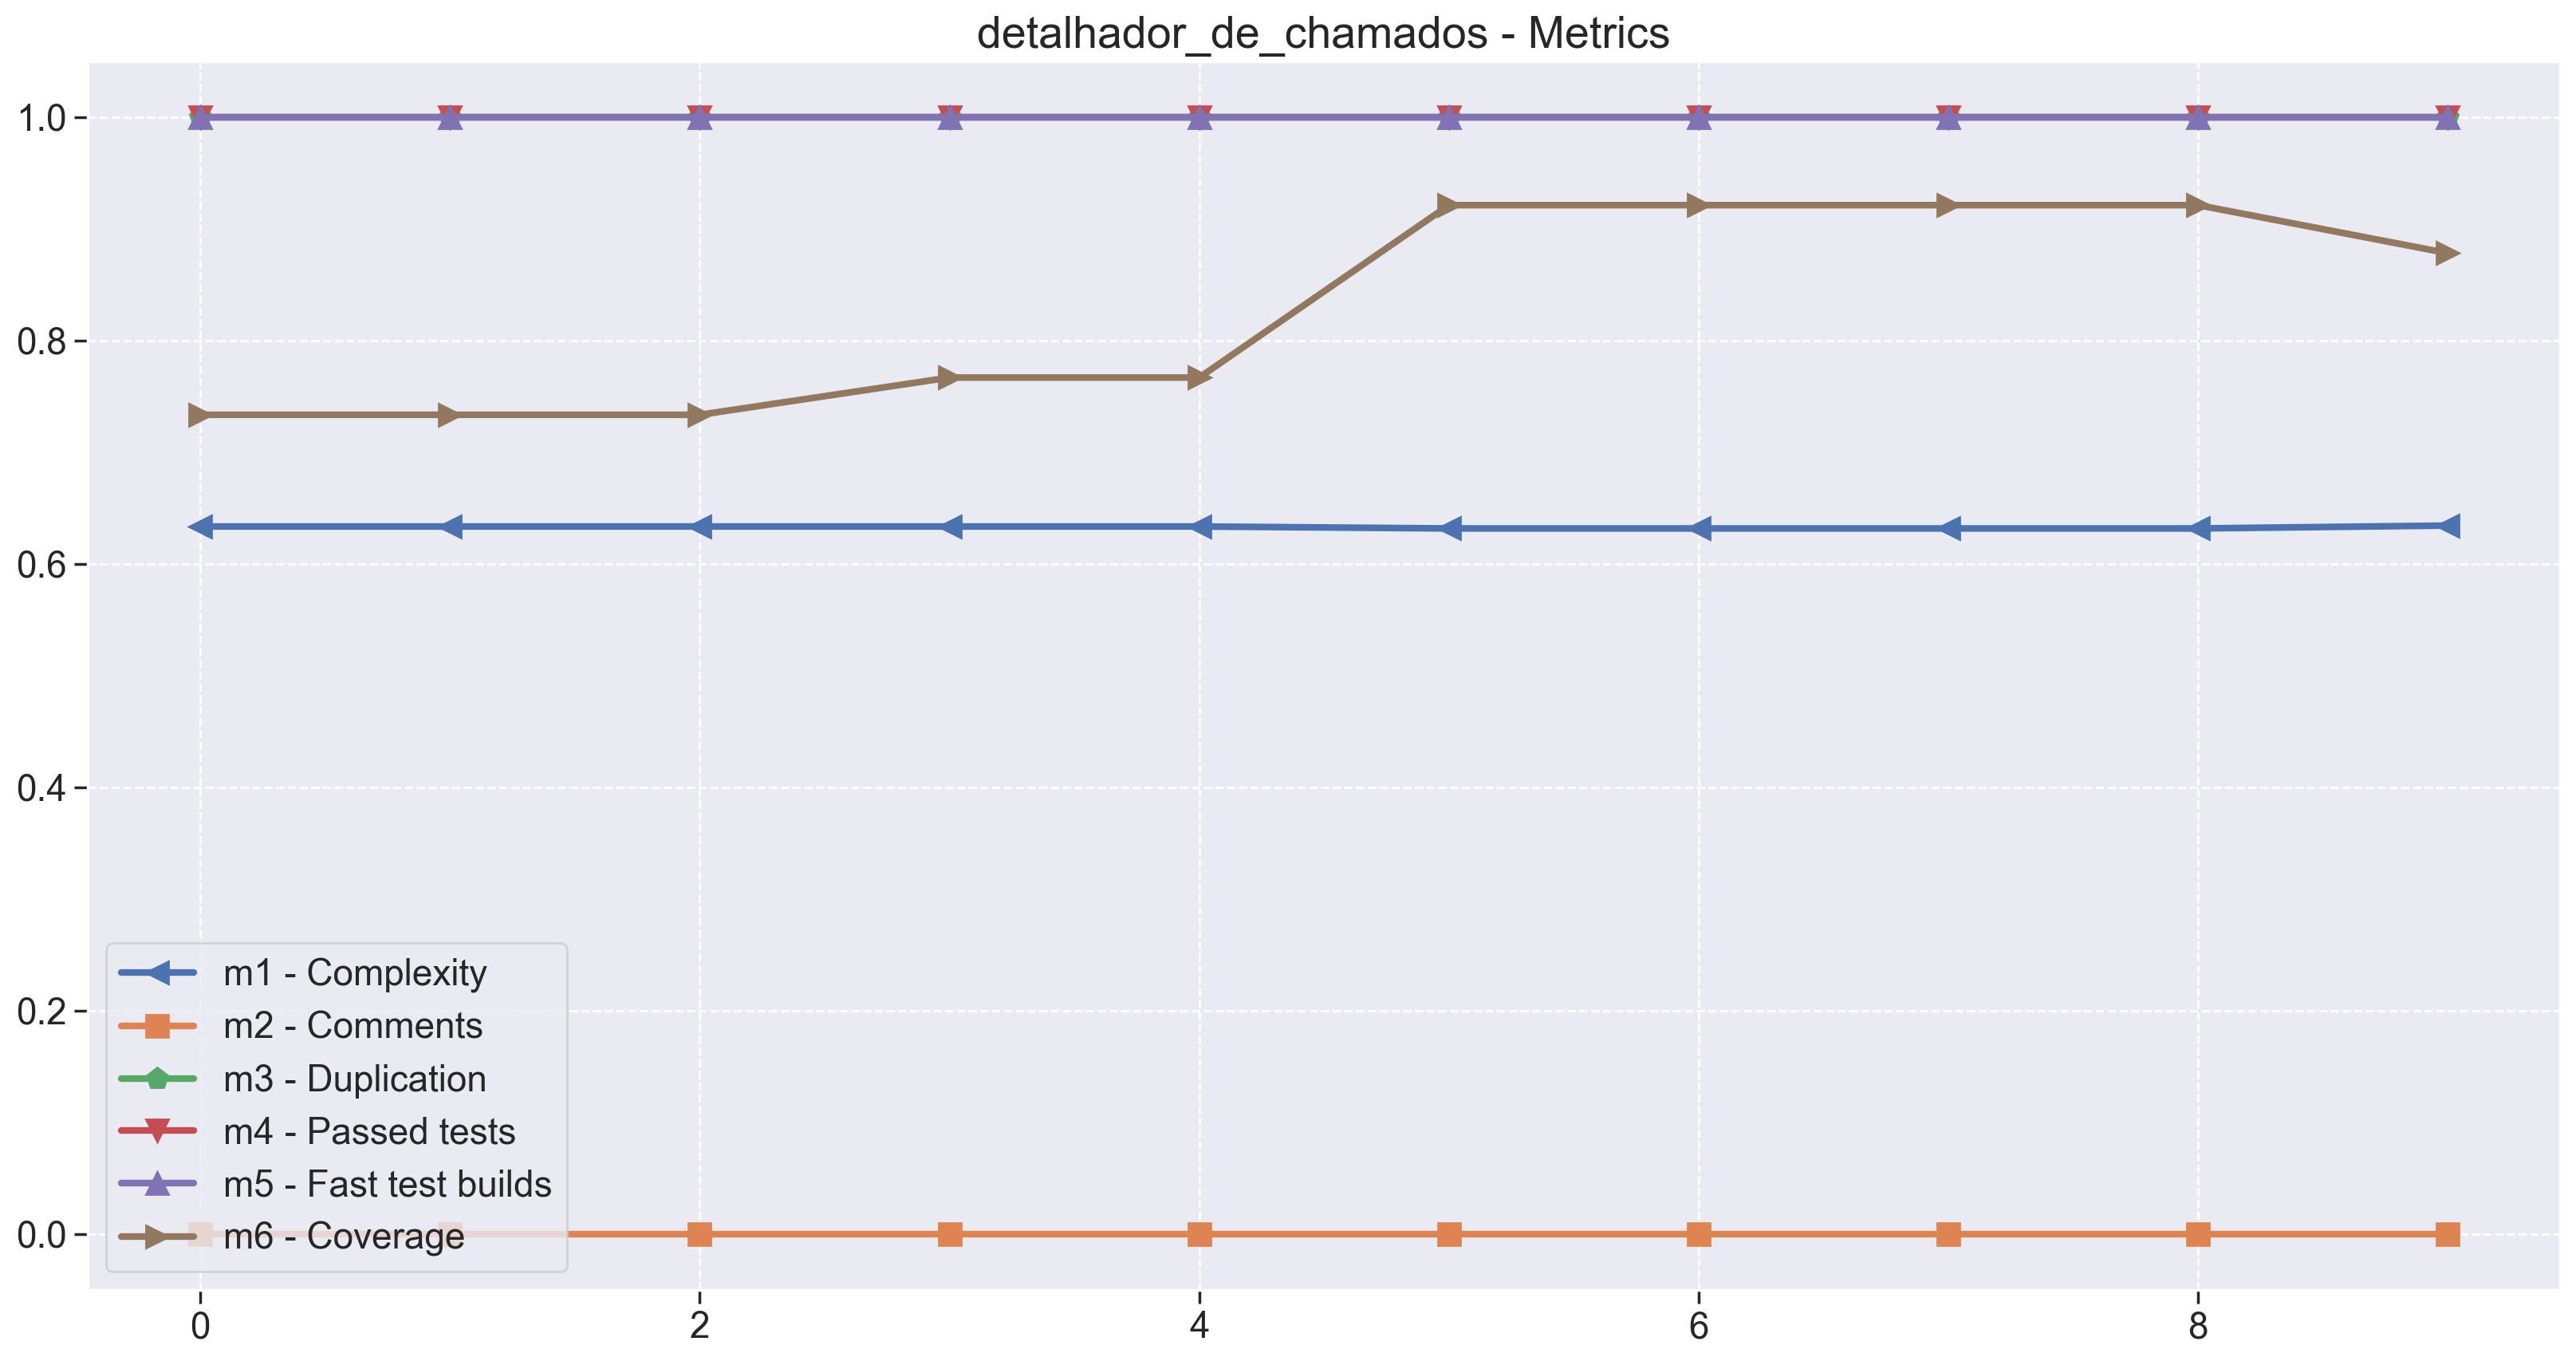

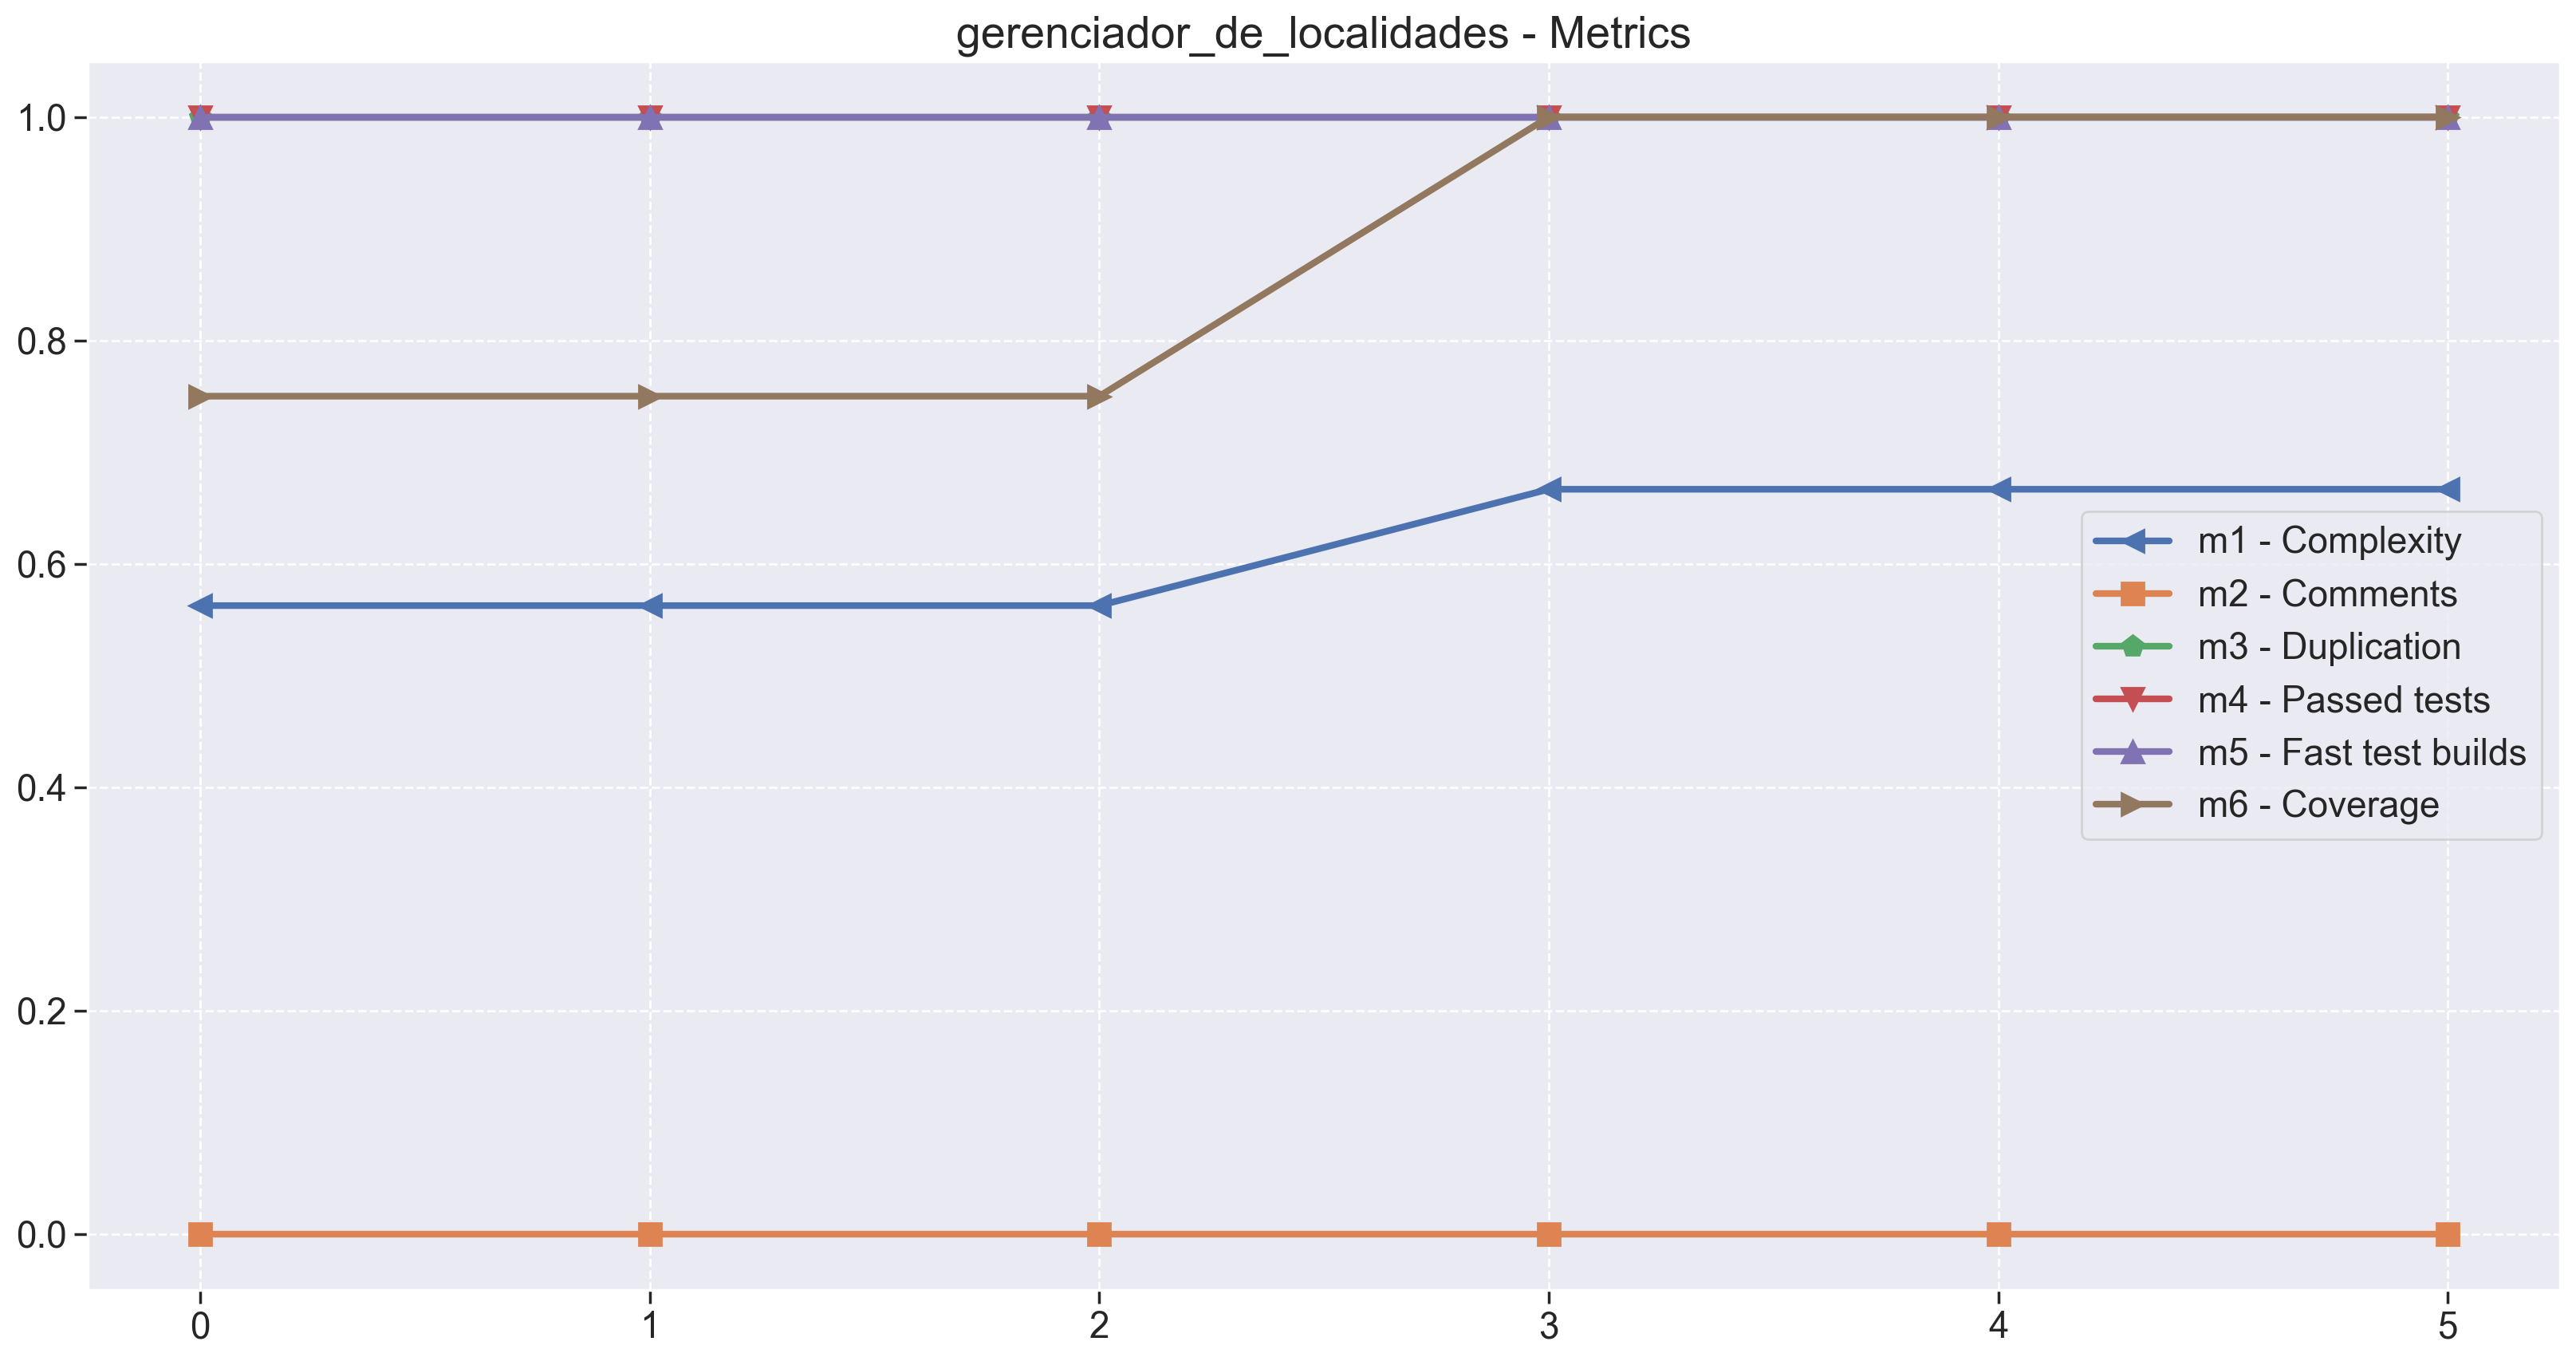

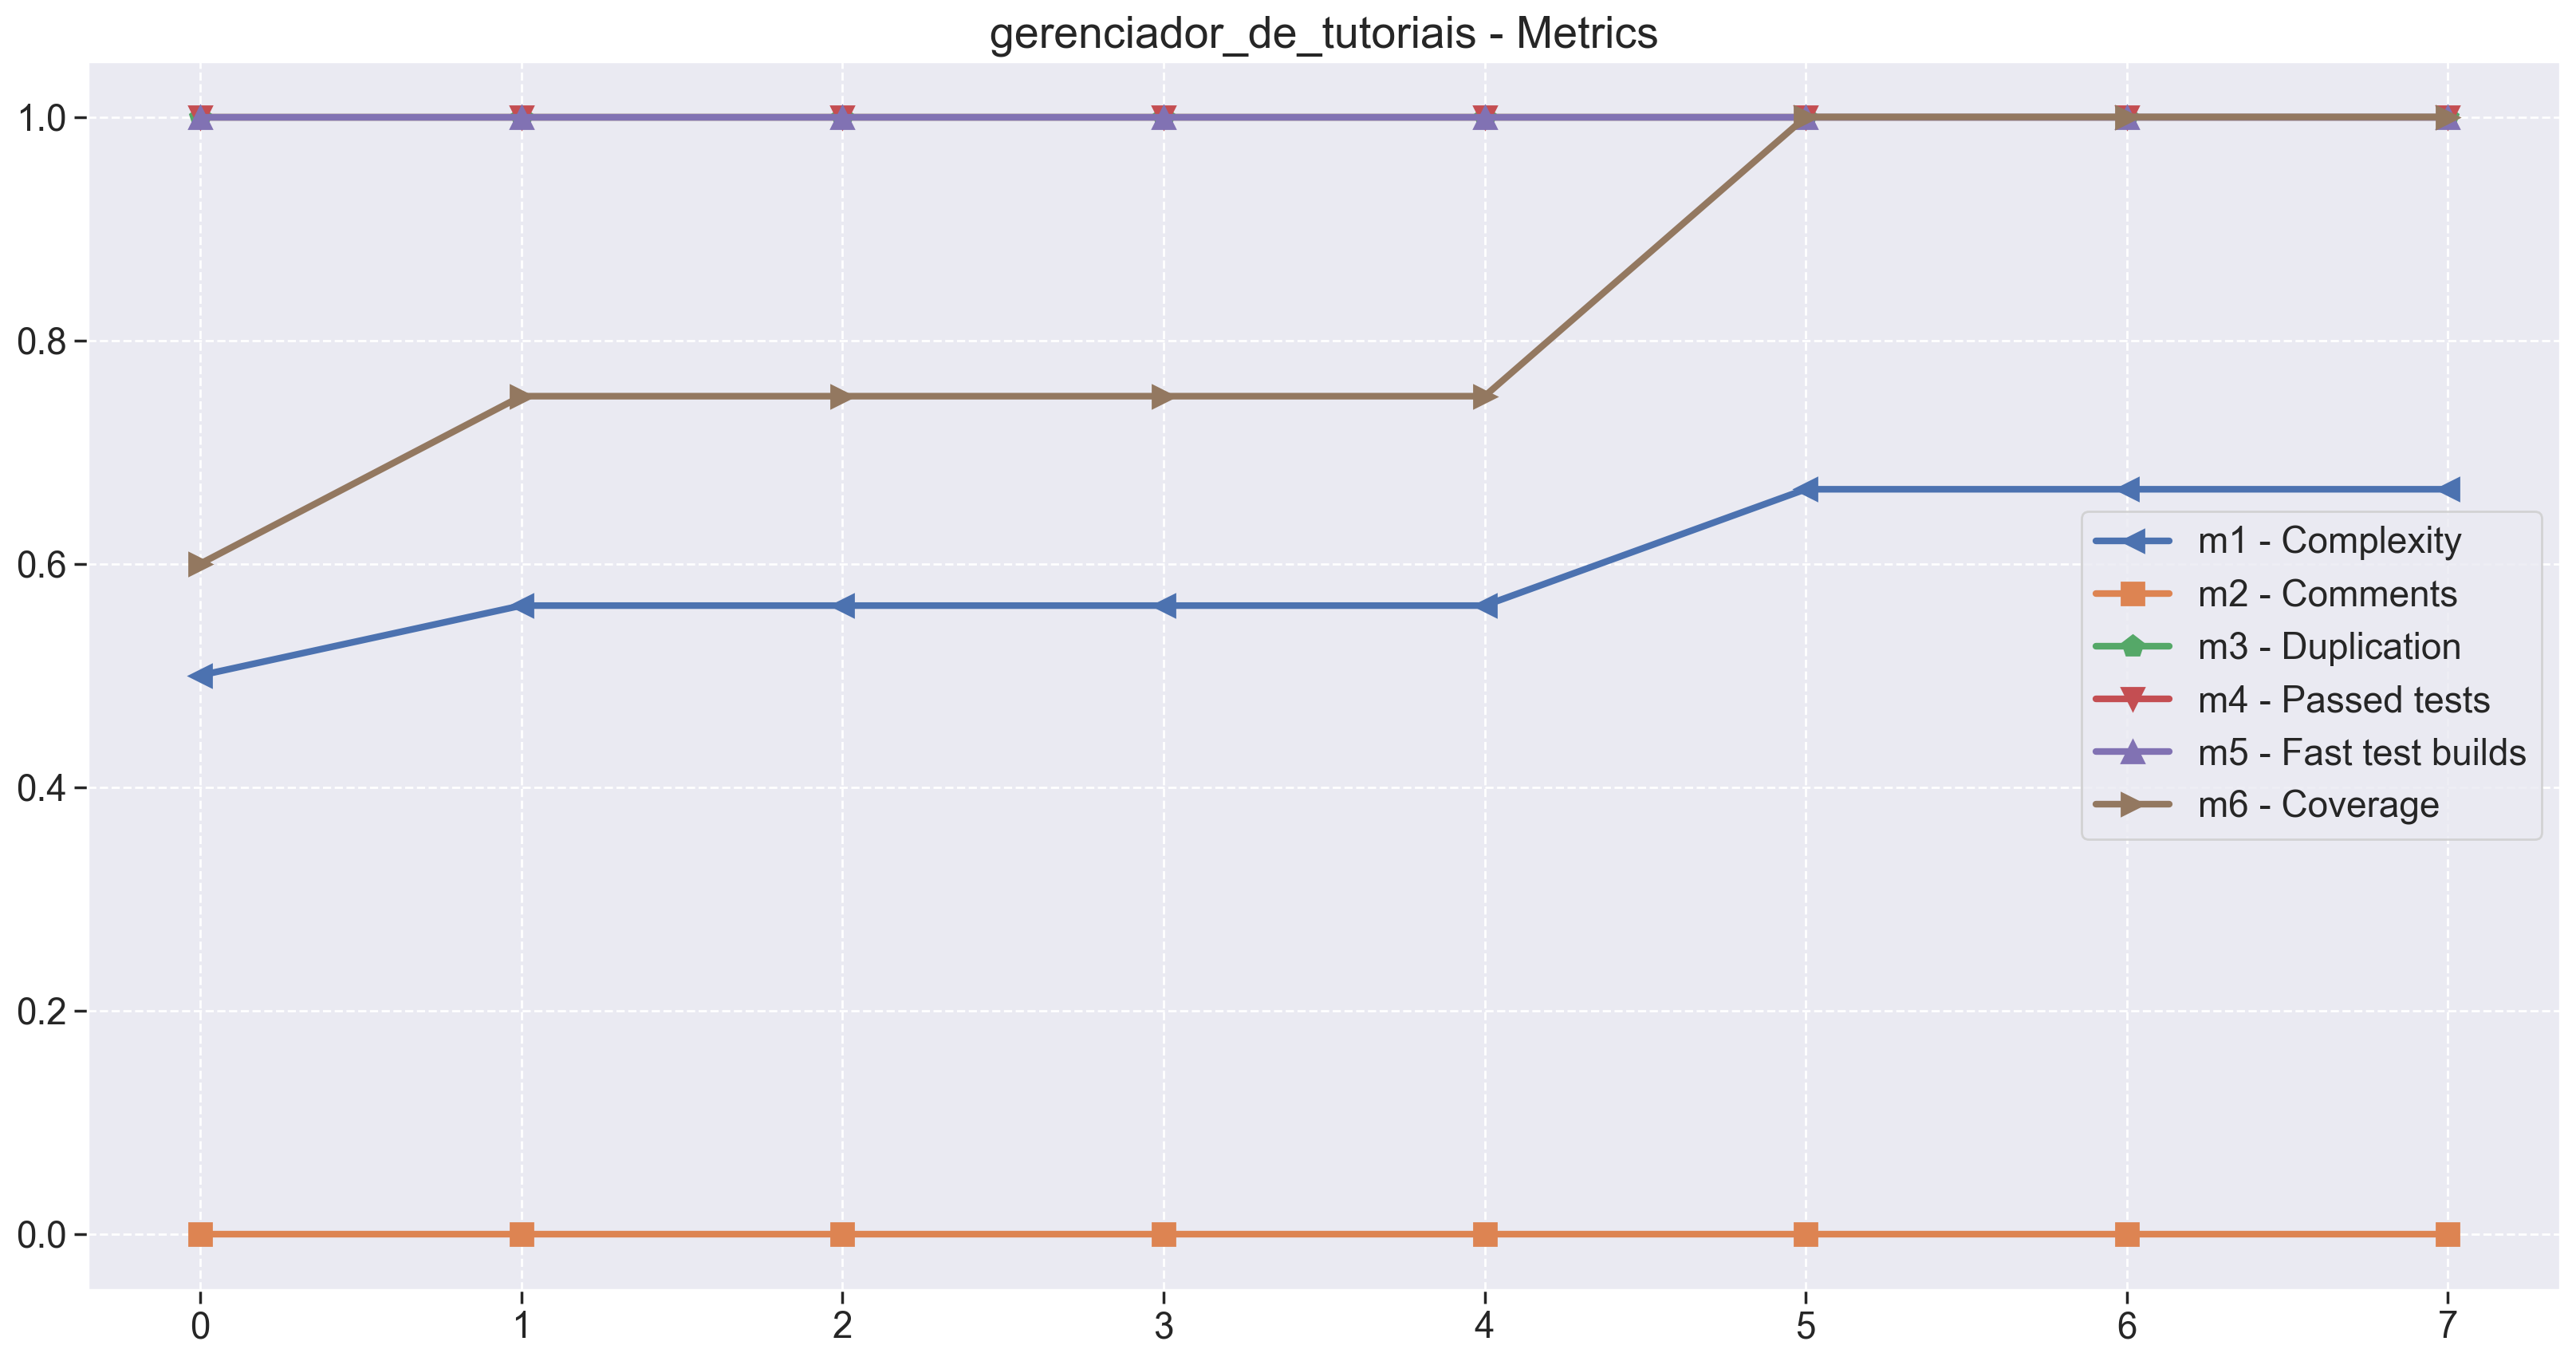

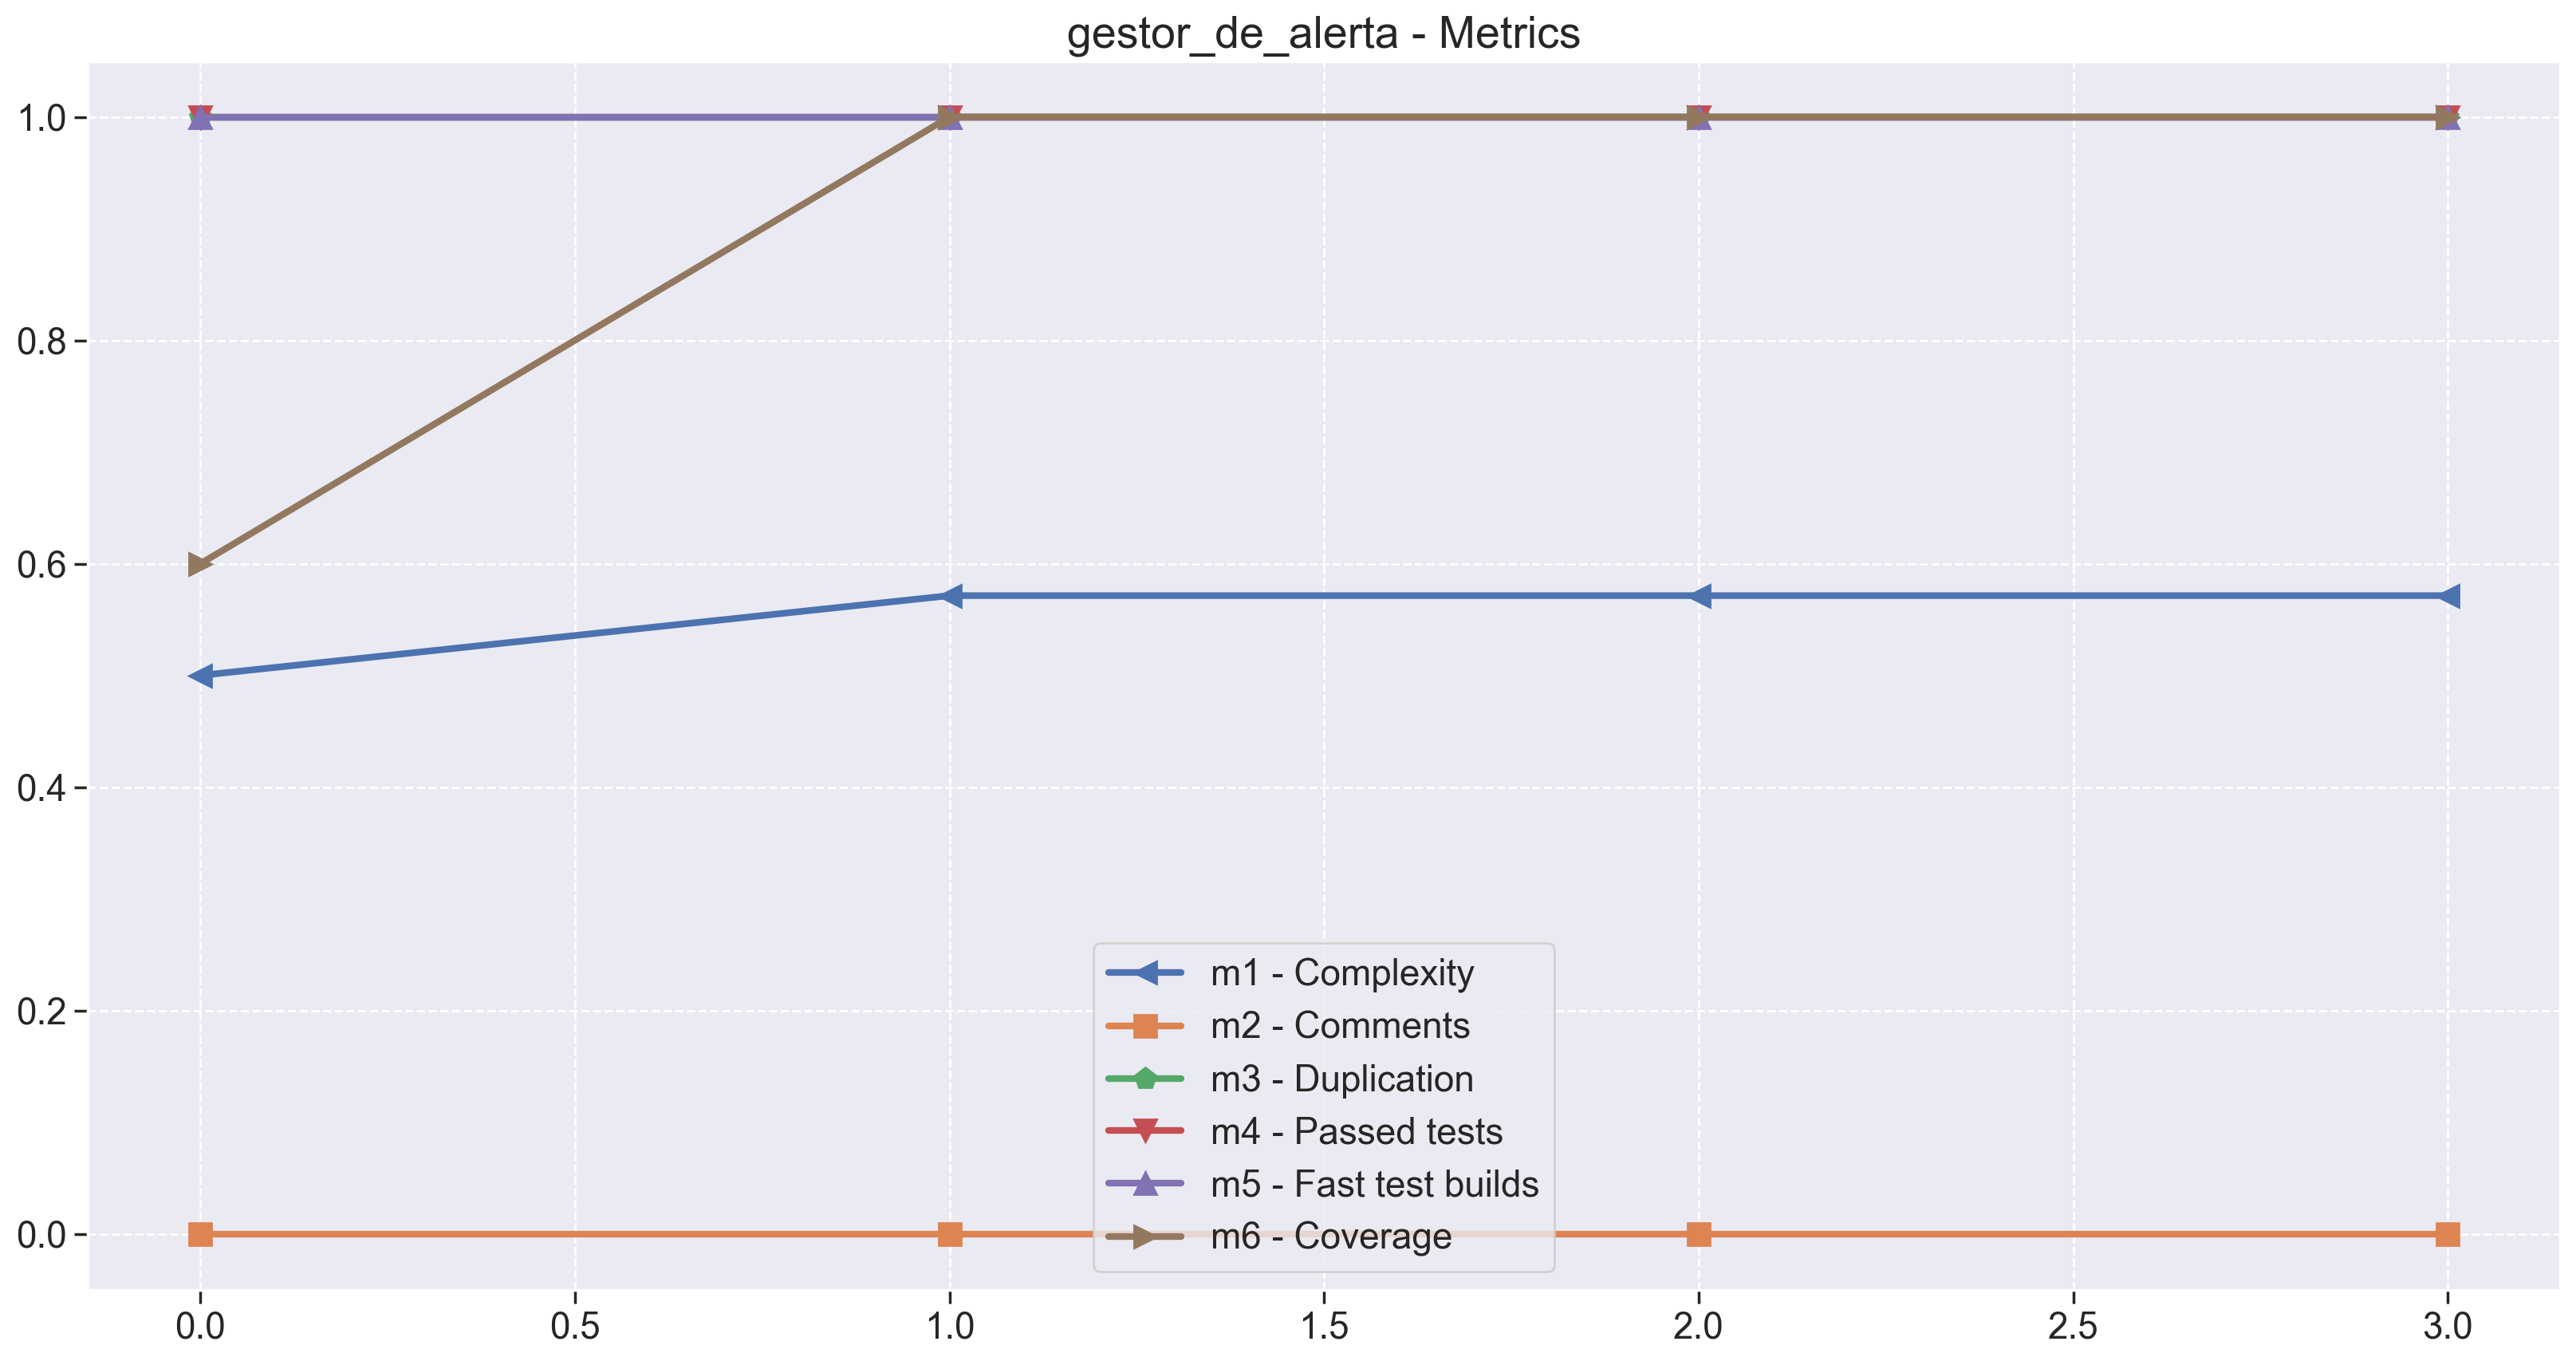

In [56]:
for name, data in metrics.items():
    fig = plt.figure(figsize=(20, 10))

    plt.plot(data['m1'], linewidth=3, marker='<', markersize=10, label="m1 - Complexity")
    plt.plot(data['m2'], linewidth=3, marker='s', markersize=10, label="m2 - Comments")
    plt.plot(data['m3'], linewidth=3, marker='p', markersize=10, label="m3 - Duplication")
    plt.plot(data['m4'], linewidth=3, marker='v', markersize=10, label="m4 - Passed tests")
    plt.plot(data['m5'], linewidth=3, marker='^', markersize=10, label="m5 - Fast test builds")
    plt.plot(data['m6'], linewidth=3, marker='>', markersize=10, label="m6 - Coverage")

    plt.title(f"{name} - Metrics", fontsize=20)
    plt.legend(loc='best')
    plt.show()

## Quality factor and aspect aggregation

In [57]:
psc1 = 1
psc2 = 1
pc1 = 0.5
pc2 = 0.5
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33
pm4 = 0.25
pm5 = 0.25
pm6 = 0.5


# Here you will need to create the code_quality and testing_status metrics for each repository.

for name, data in metrics.items():
    data['code_quality'] = ((data['m1']*pm1) + (data['m2']*pm2) + (data['m3']*pm3)) * psc1
    data['testing_status'] = ((data['m4']*pm4) + (data['m5']*pm5) + (data['m6']*pm6)) * psc2

### Code Quality visualization

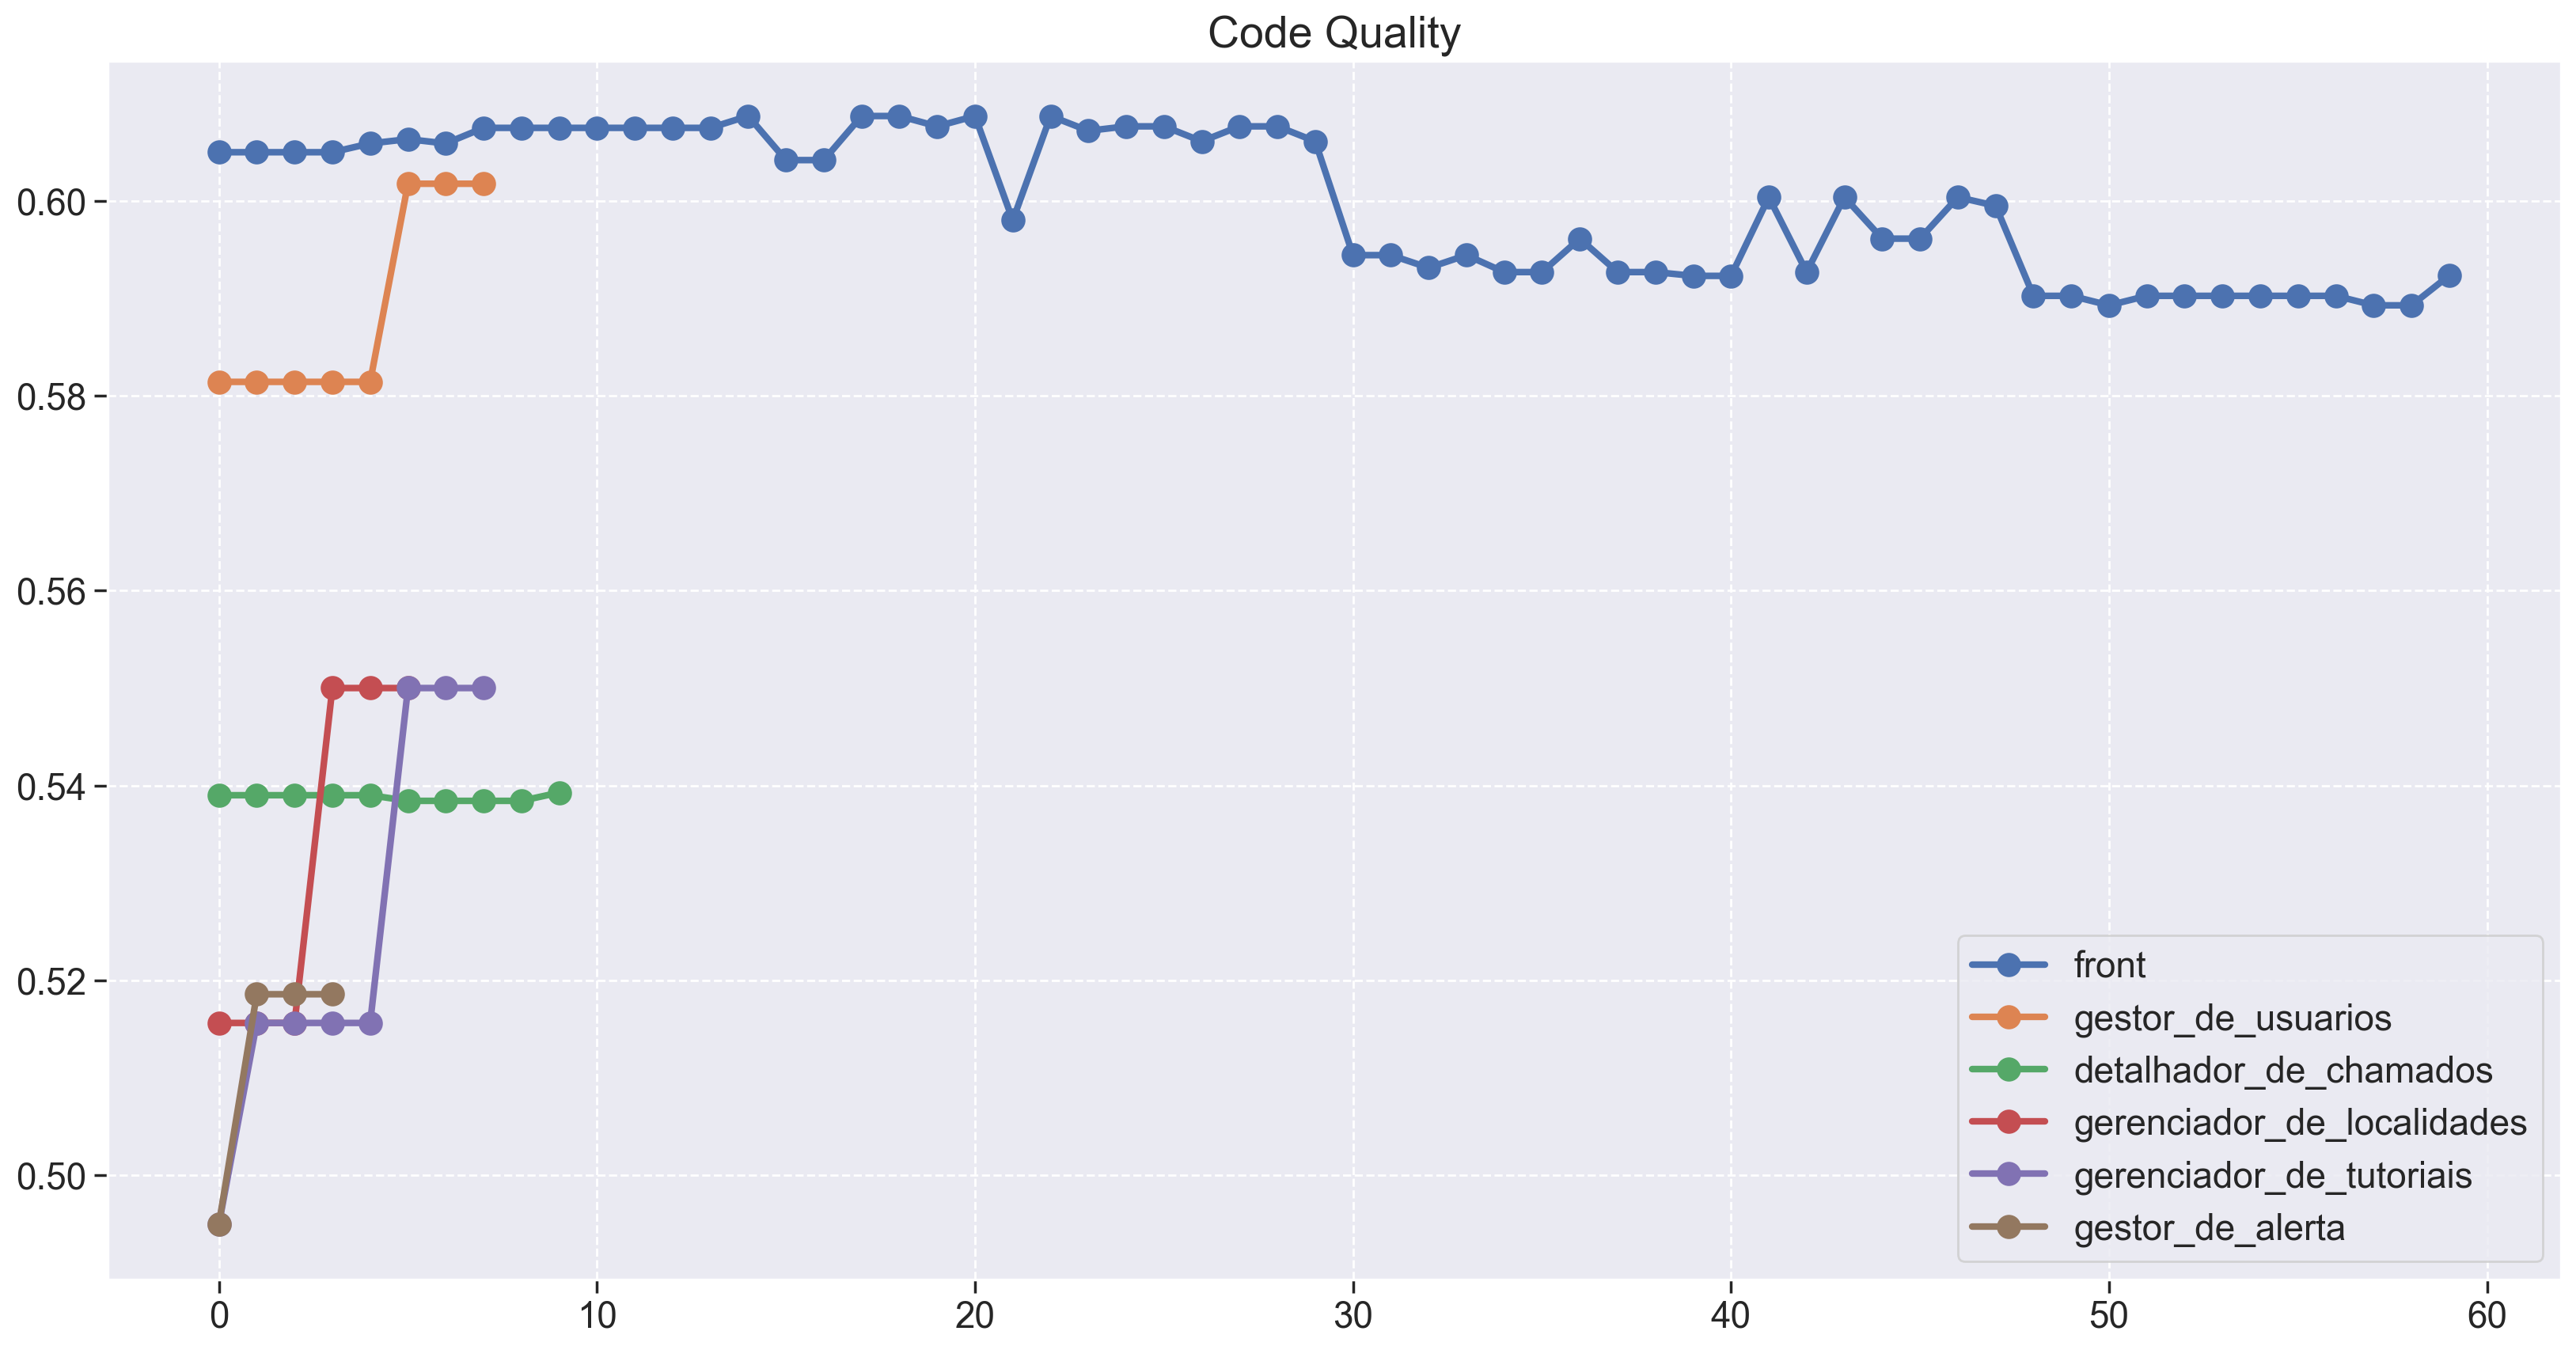

In [58]:
fig = plt.figure(figsize=(20, 10))

for name, data in metrics.items():
    plt.plot(data['code_quality'], linewidth=3, marker='o', markersize=10, label=name)

plt.title("Code Quality", fontsize=20)
plt.legend(loc='best')
plt.show()

### Testing Status visualization

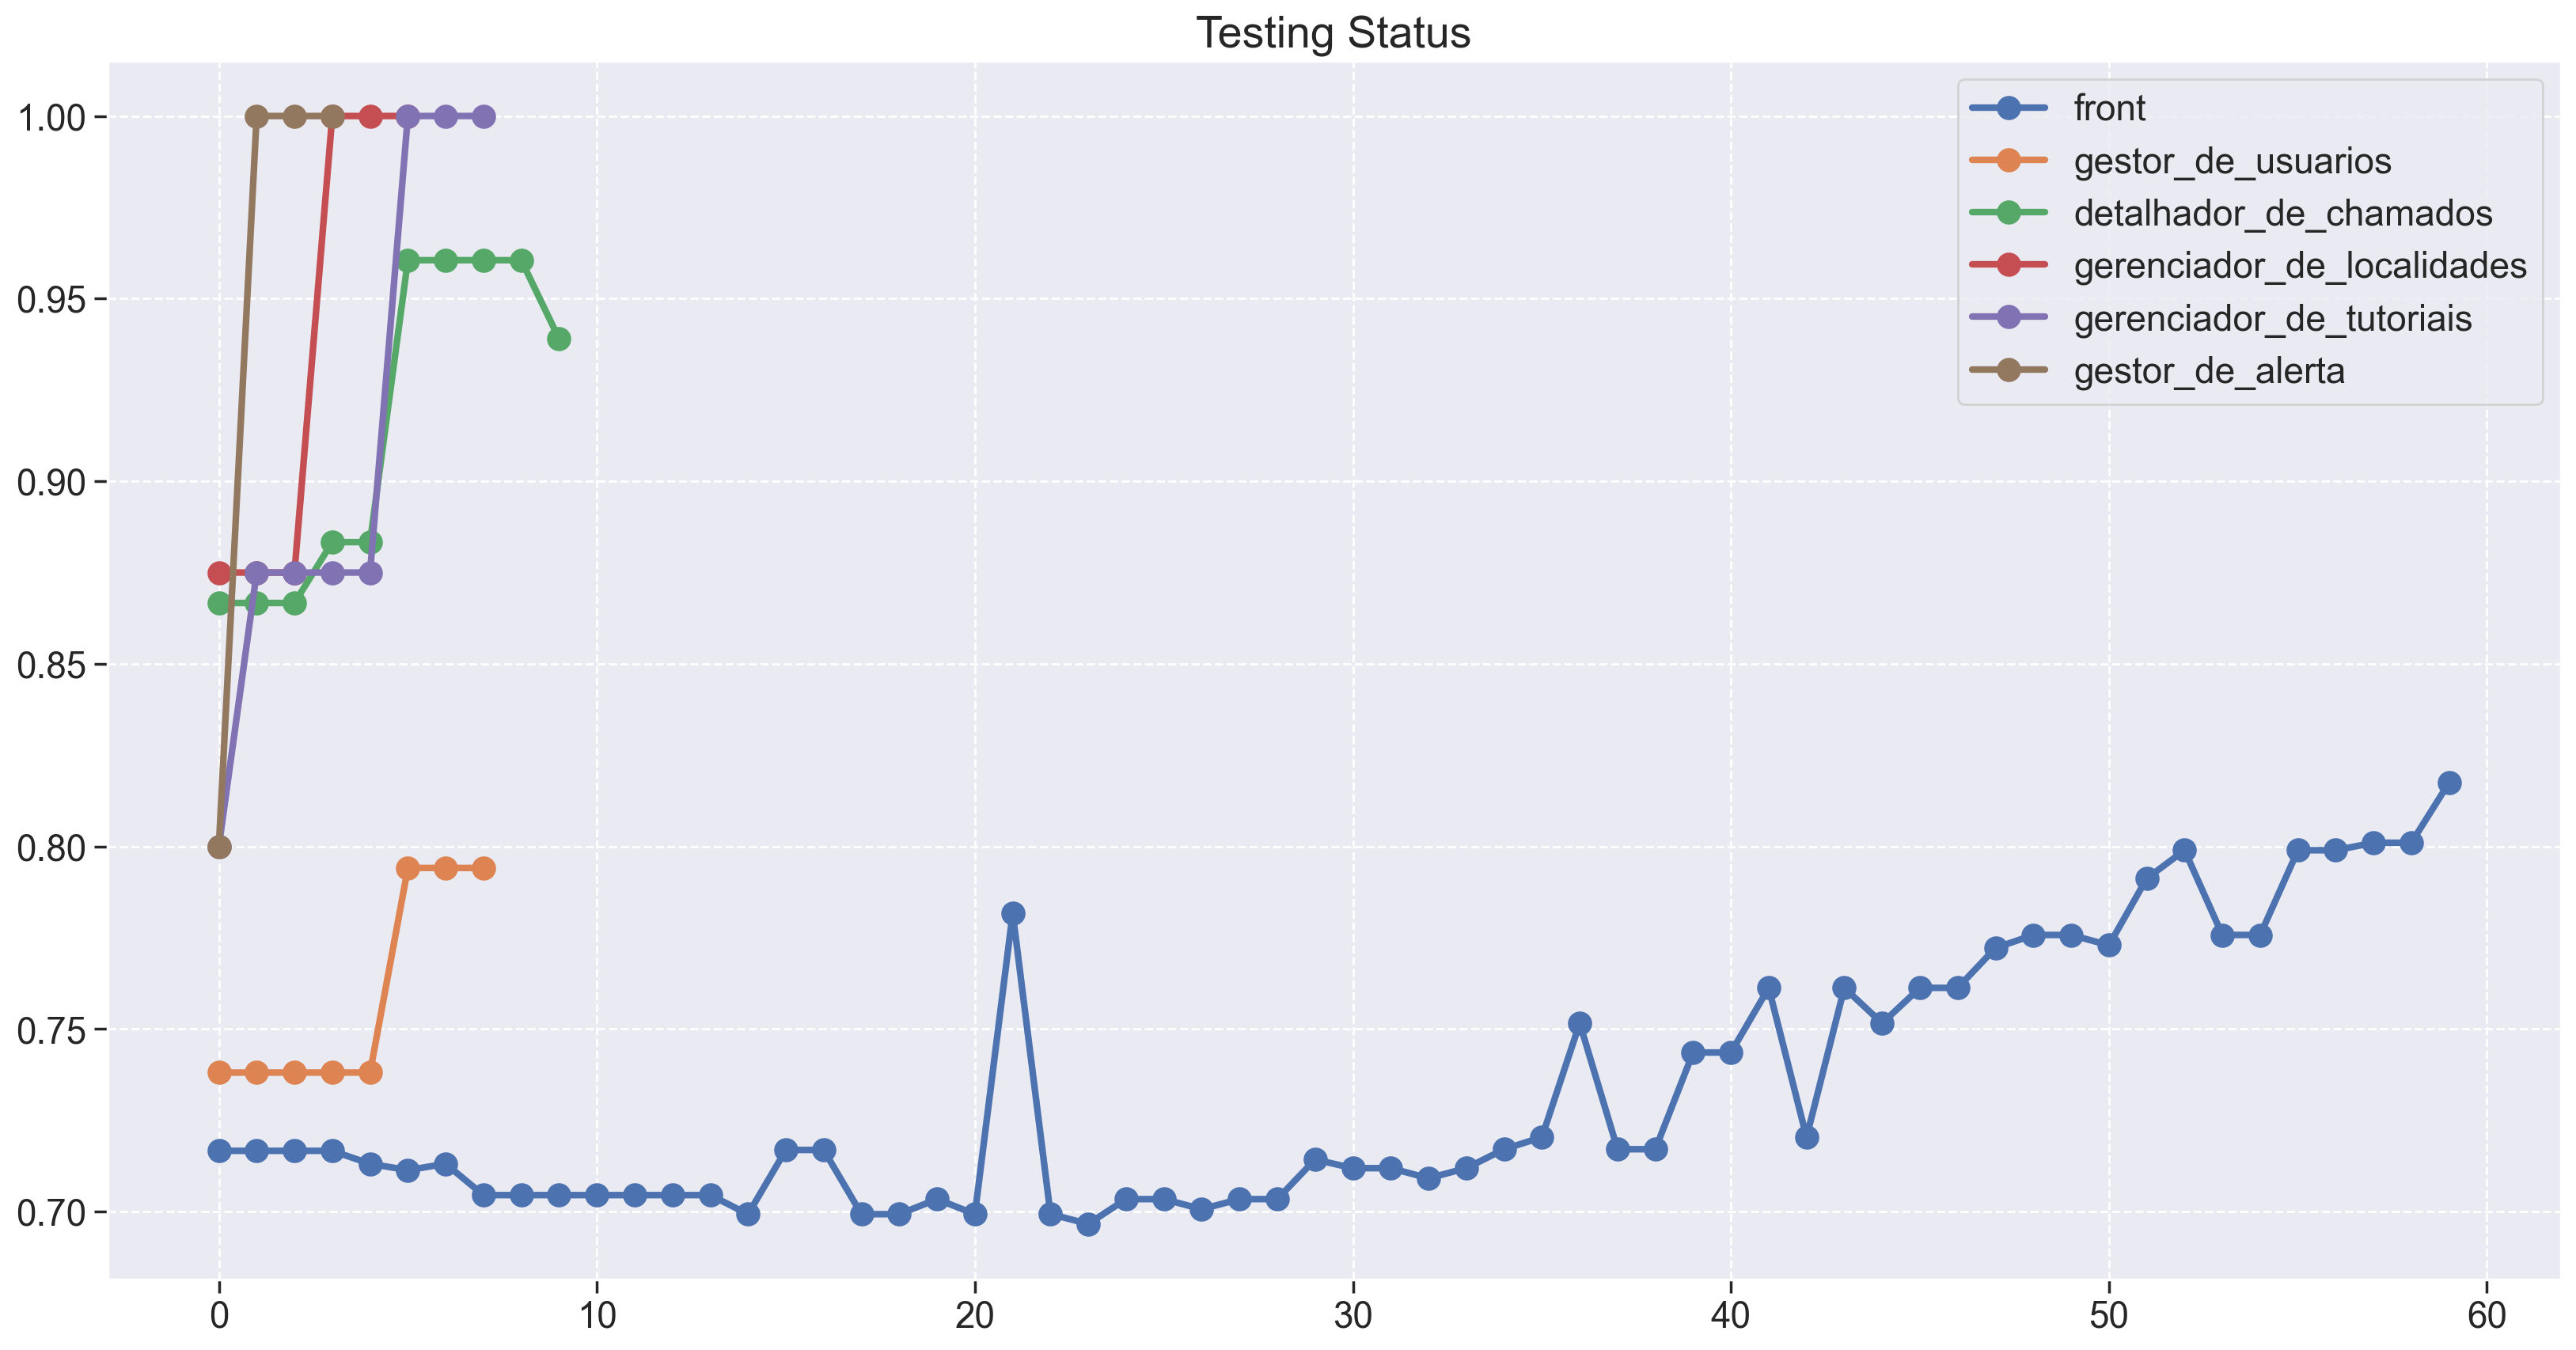

In [59]:
fig = plt.figure(figsize=(20, 10))

for name, data in metrics.items():
    plt.plot(data['testing_status'], linewidth=3, marker='o', markersize=10, label=name)

plt.title("Testing Status", fontsize=20)
plt.legend(loc='best')
plt.show()

### Aggregations

In [60]:
for name, data in metrics.items():
    data['Maintainability'] = data['code_quality'] * pc1
    data['Reliability'] = data['testing_status'] * pc2
    data['total'] = data['Maintainability'] + data['Reliability']

## Repositories analysis

In [61]:
def get_characteristc_stats(repo_series):
    return {
        'mean': repo_series.mean(),
        'mode': repo_series.mode(),
        'median': repo_series.median(),
        'std': repo_series.std(),
        'var': repo_series.var(),
        'min': repo_series.min(),
        'max': repo_series.max()
    }

In [62]:
def analysis(metrics, name):
    maintainability_stats = pd.DataFrame(get_characteristc_stats(metrics["Maintainability"]),
                                     columns=['mean', 'mode', 'median', 'std', 'var', 'min', 'max'])

    reliability_stats = pd.DataFrame(get_characteristc_stats(metrics["Reliability"]),
                                 columns=['mean', 'mode', 'median', 'std', 'var', 'min', 'max'])


    print("Maintainability Stats")
    print(maintainability_stats.to_string(index=False))

    print("Reliability Stats")
    print(reliability_stats.to_string(index=False))

    fig = plt.figure(figsize=(20, 10))

    plt.plot(metrics['Maintainability'], linewidth=3, marker='o', markersize=10, label="Maintainability")
    plt.plot(metrics['Reliability'], linewidth=3, marker='*', markersize=10, label="Reliability")

    plt.ylim(0.1,1.1)
    plt.title(f'{name} - Maintainability and Reliability', fontsize=20)
    plt.legend(loc='best')
    plt.show()

    fig = plt.figure(figsize=(20, 10))

    plt.plot(metrics['total'], linewidth=3, marker='X', markersize=5)

    plt.ylim(0.1,1.1)
    plt.title(f'{name} - Total', fontsize=20)
    plt.show()

### Analysis loop in each repo

front
Maintainability Stats
    mean     mode   median      std      var      min      max
0.299952 0.295129 0.300194 0.003668 0.000013 0.294643 0.304358
Reliability Stats
    mean     mode   median     std      var      min     max
0.366714 0.352273 0.358333 0.01771 0.000314 0.348333 0.40875


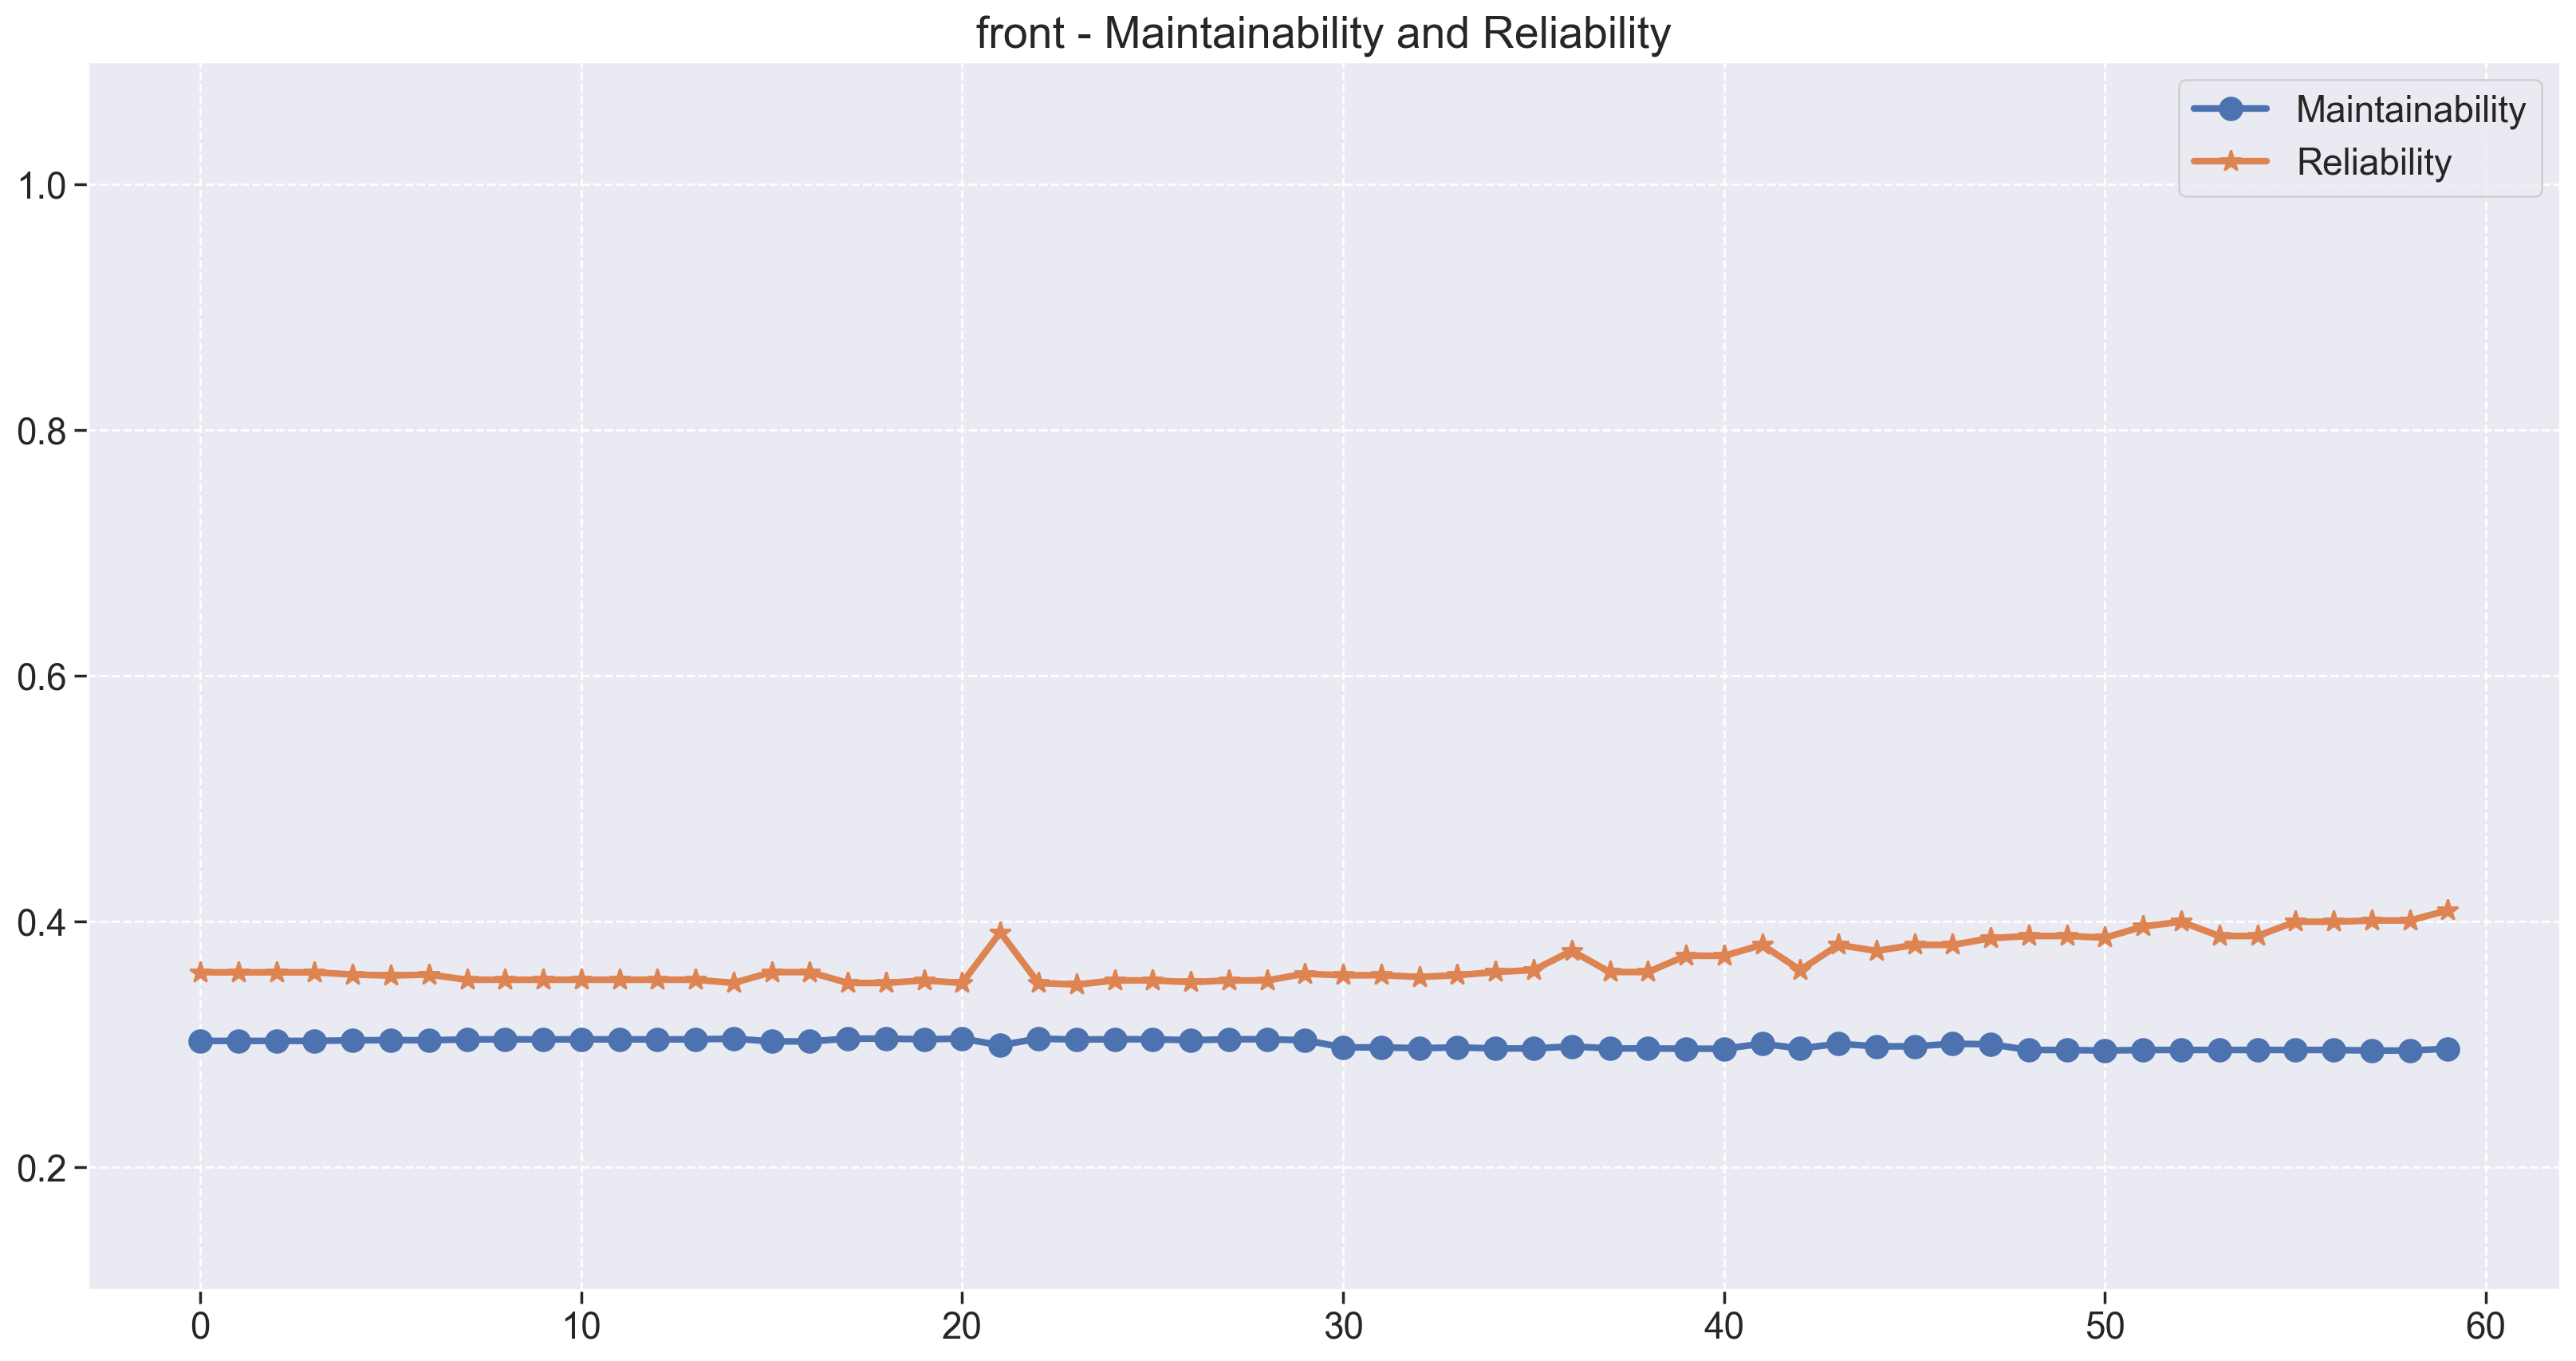

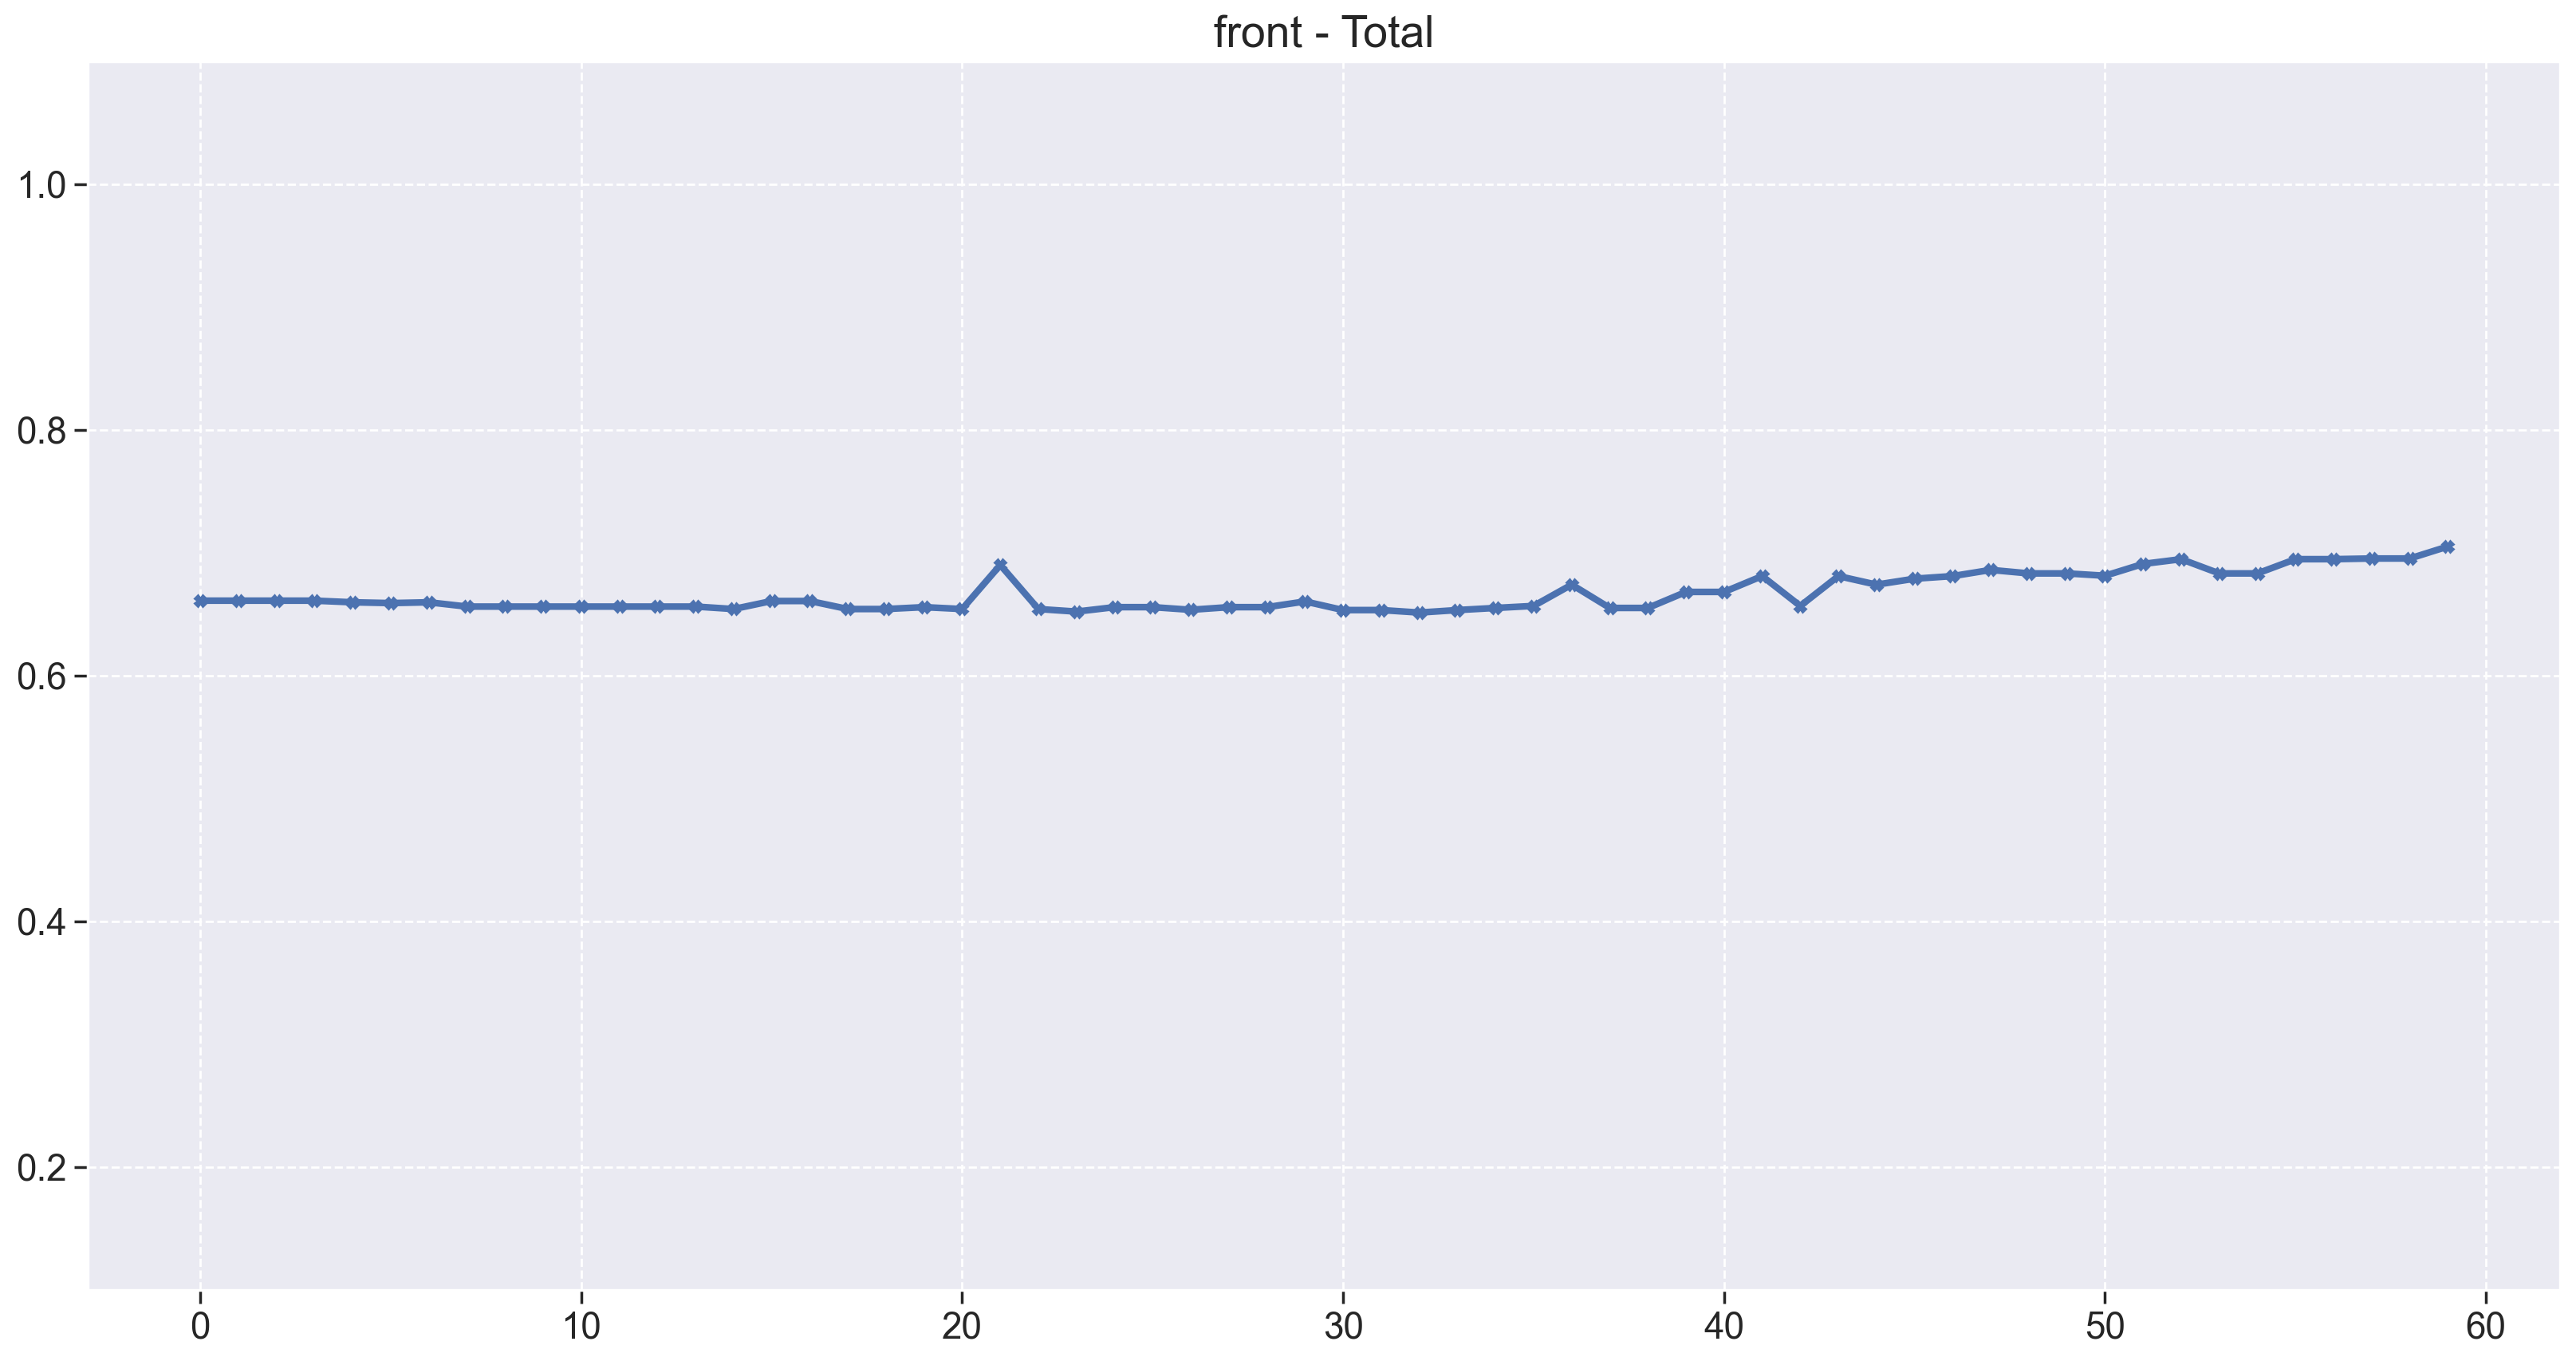

gestor_de_usuarios
Maintainability Stats
    mean     mode   median      std      var      min      max
0.294527 0.290714 0.290714 0.005262 0.000028 0.290714 0.300882
Reliability Stats
    mean     mode   median      std     var      min      max
0.379552 0.369048 0.369048 0.014497 0.00021 0.369048 0.397059


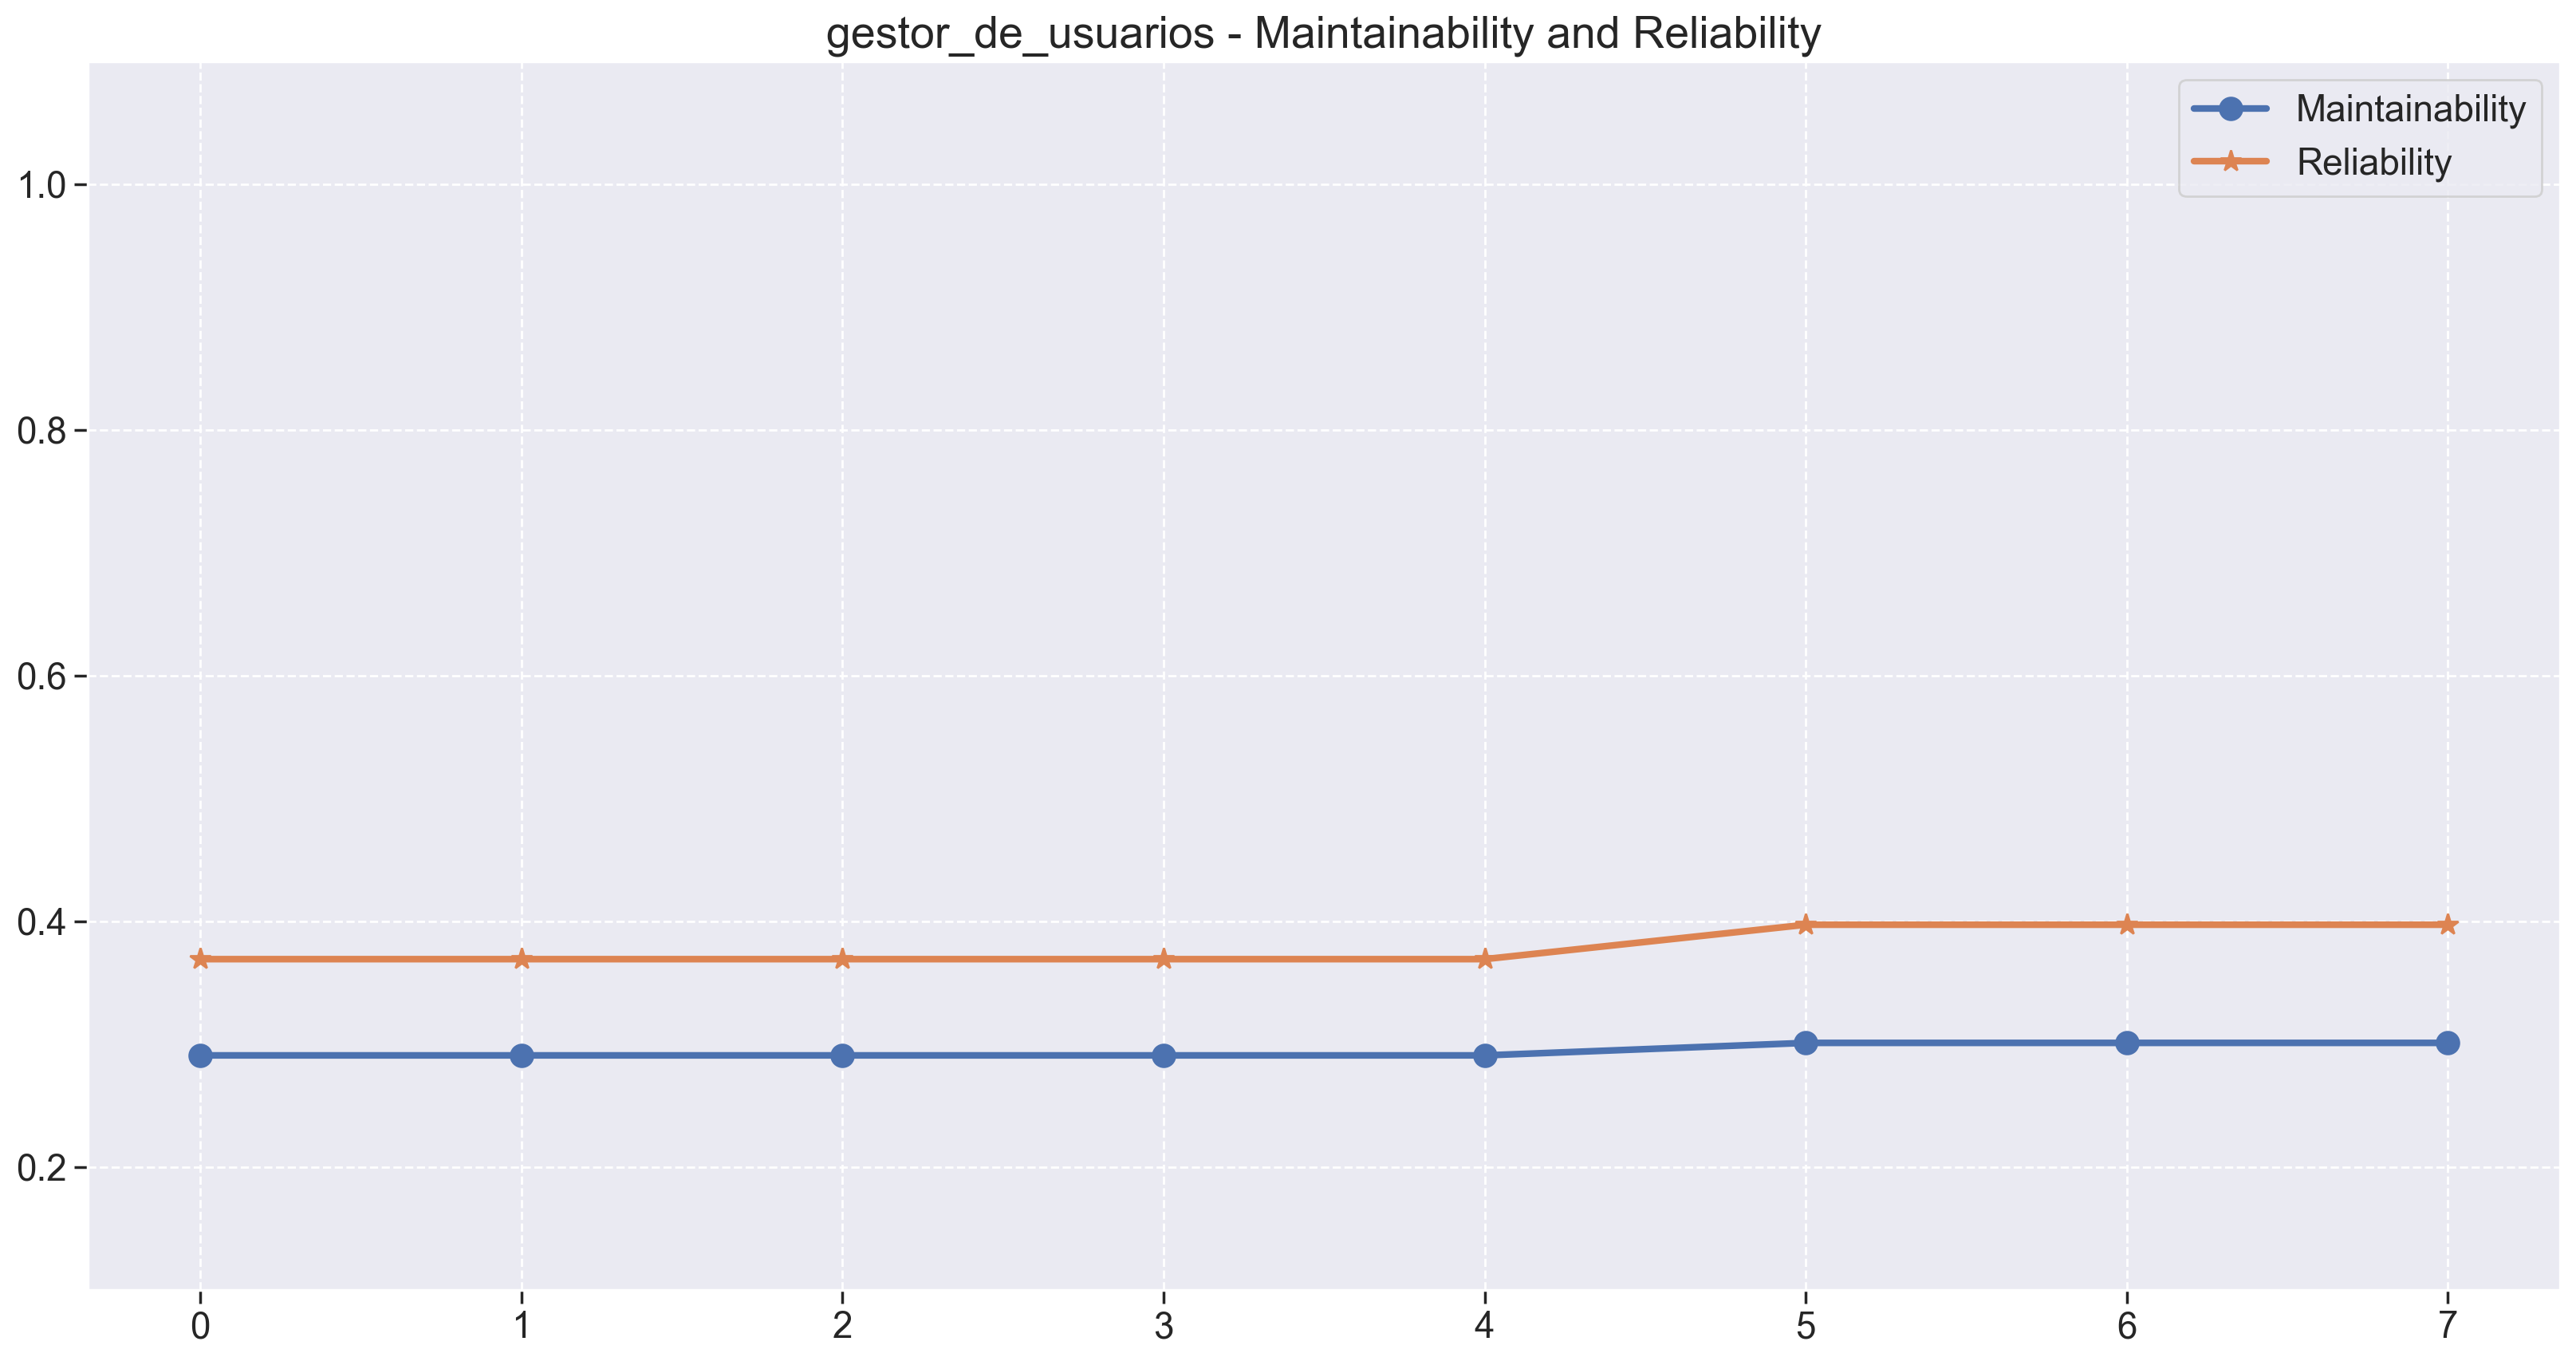

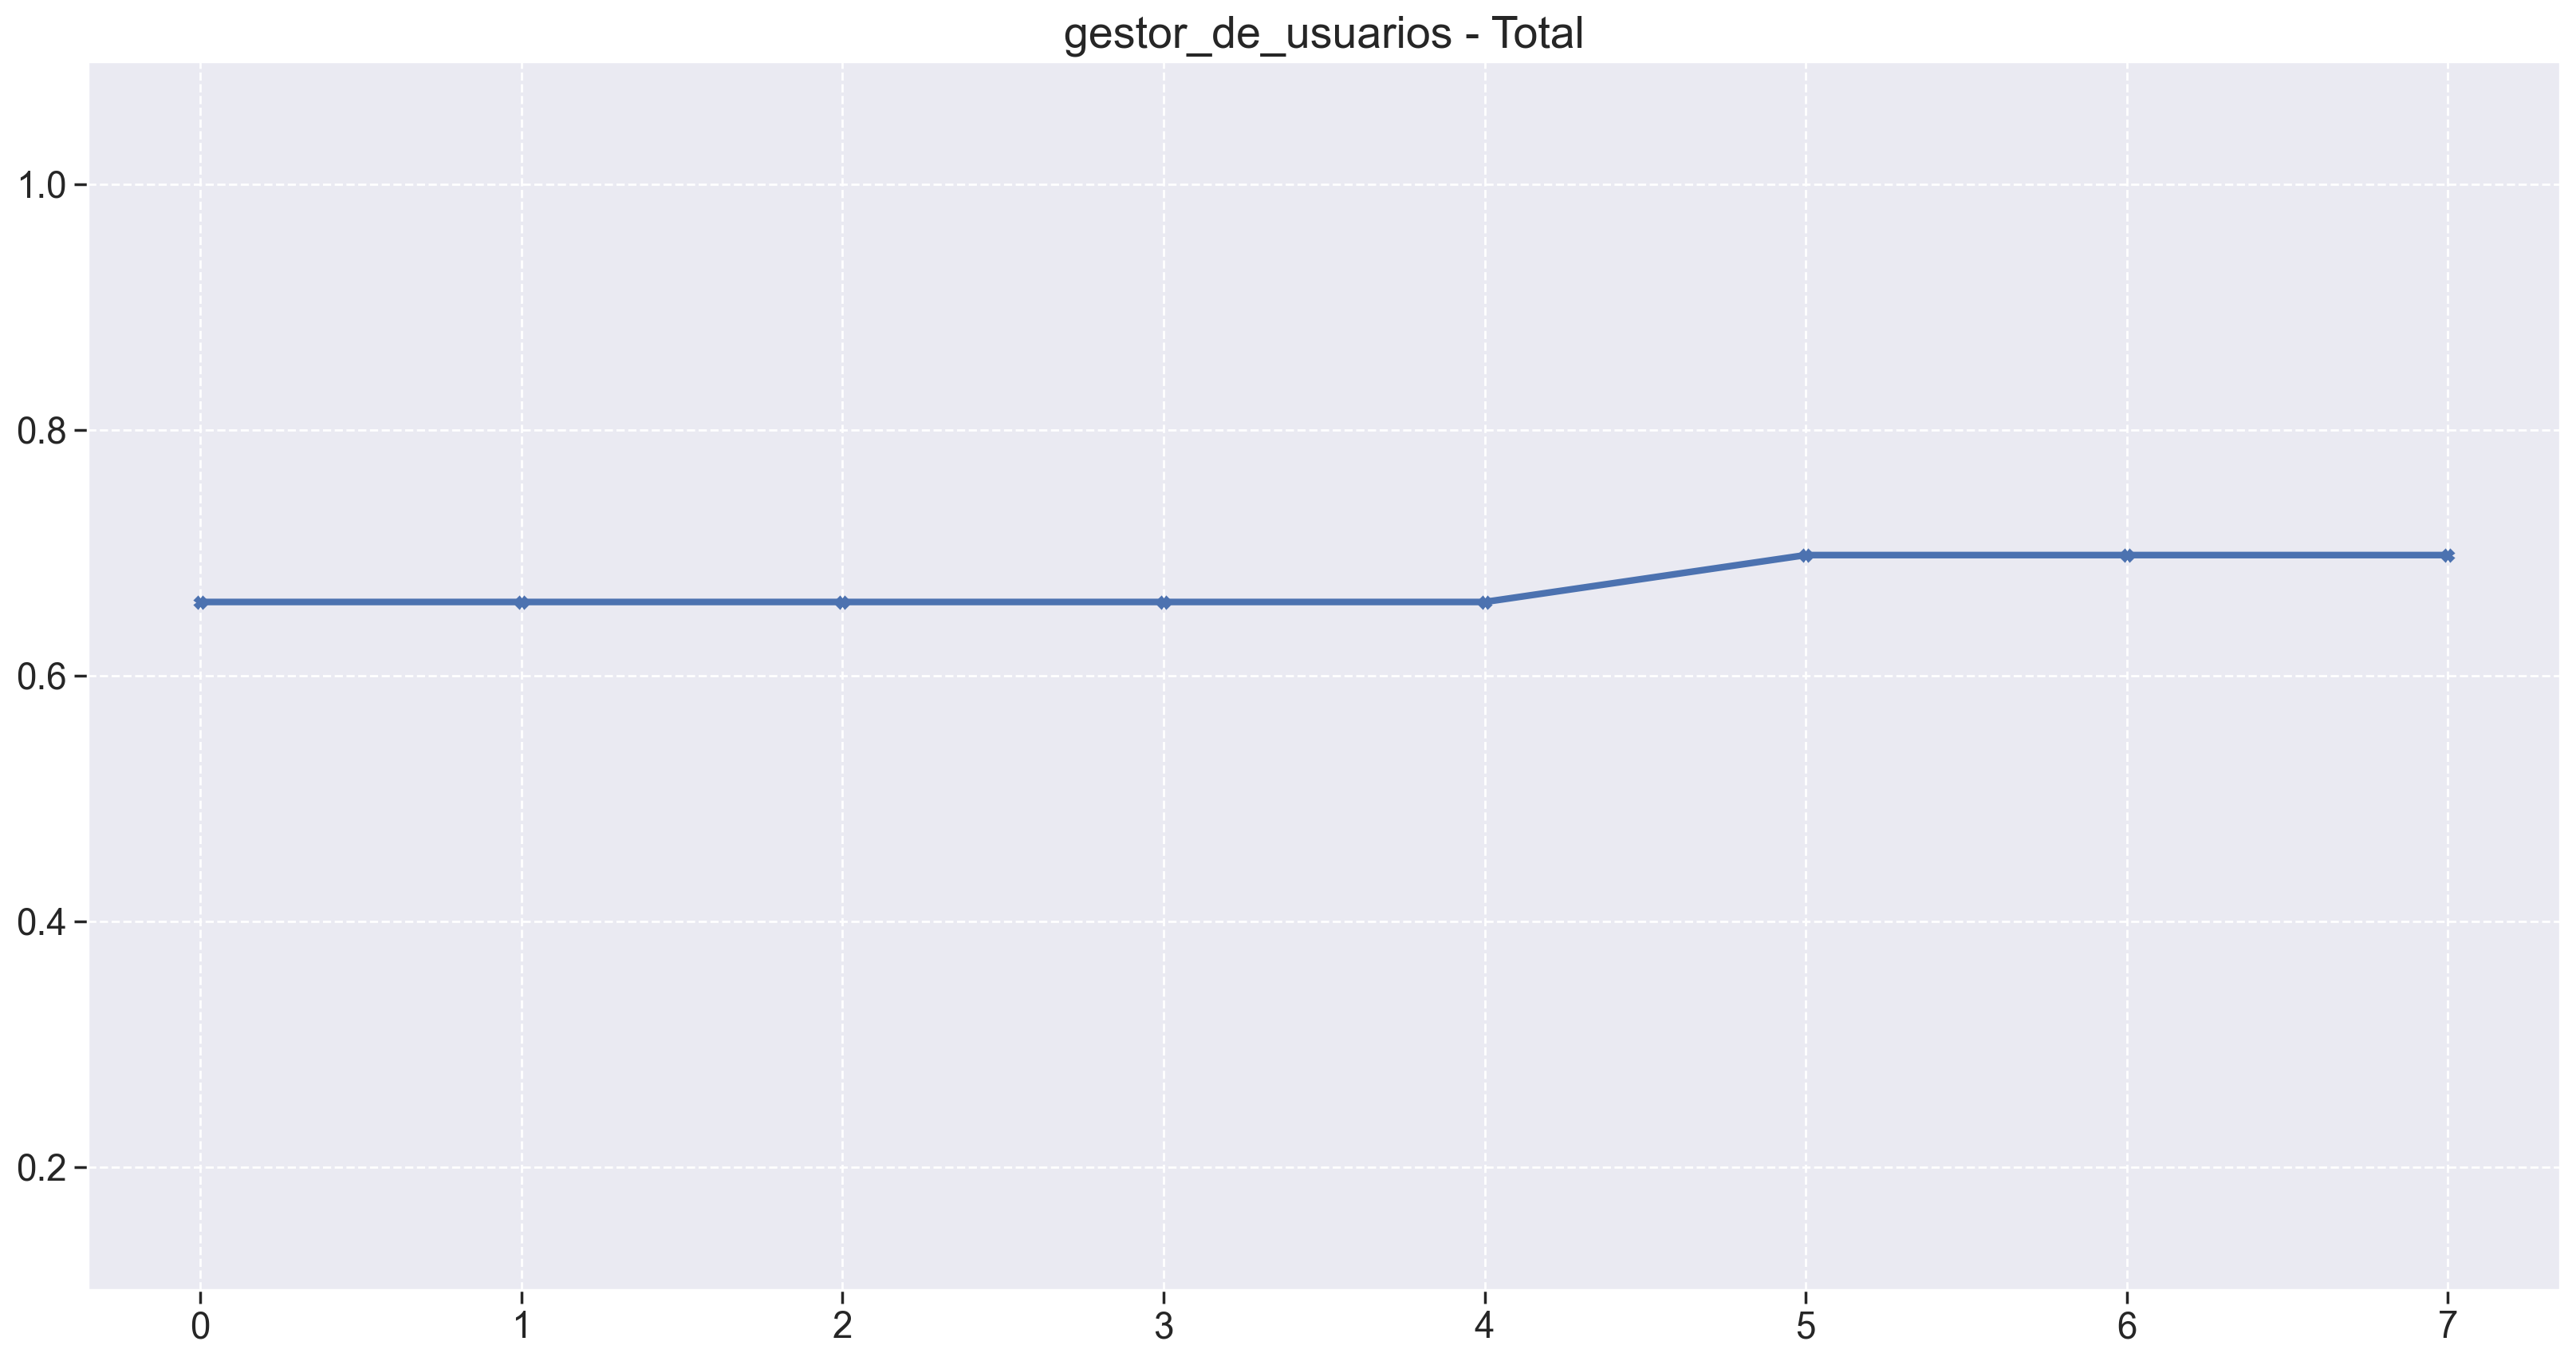

detalhador_de_chamados
Maintainability Stats
    mean   mode  median      std          var      min      max
0.269398 0.2695  0.2695 0.000166 2.759658e-08 0.269211 0.269634
Reliability Stats
   mean     mode   median      std      var      min      max
0.45739 0.480263 0.455589 0.022287 0.000497 0.433333 0.480263


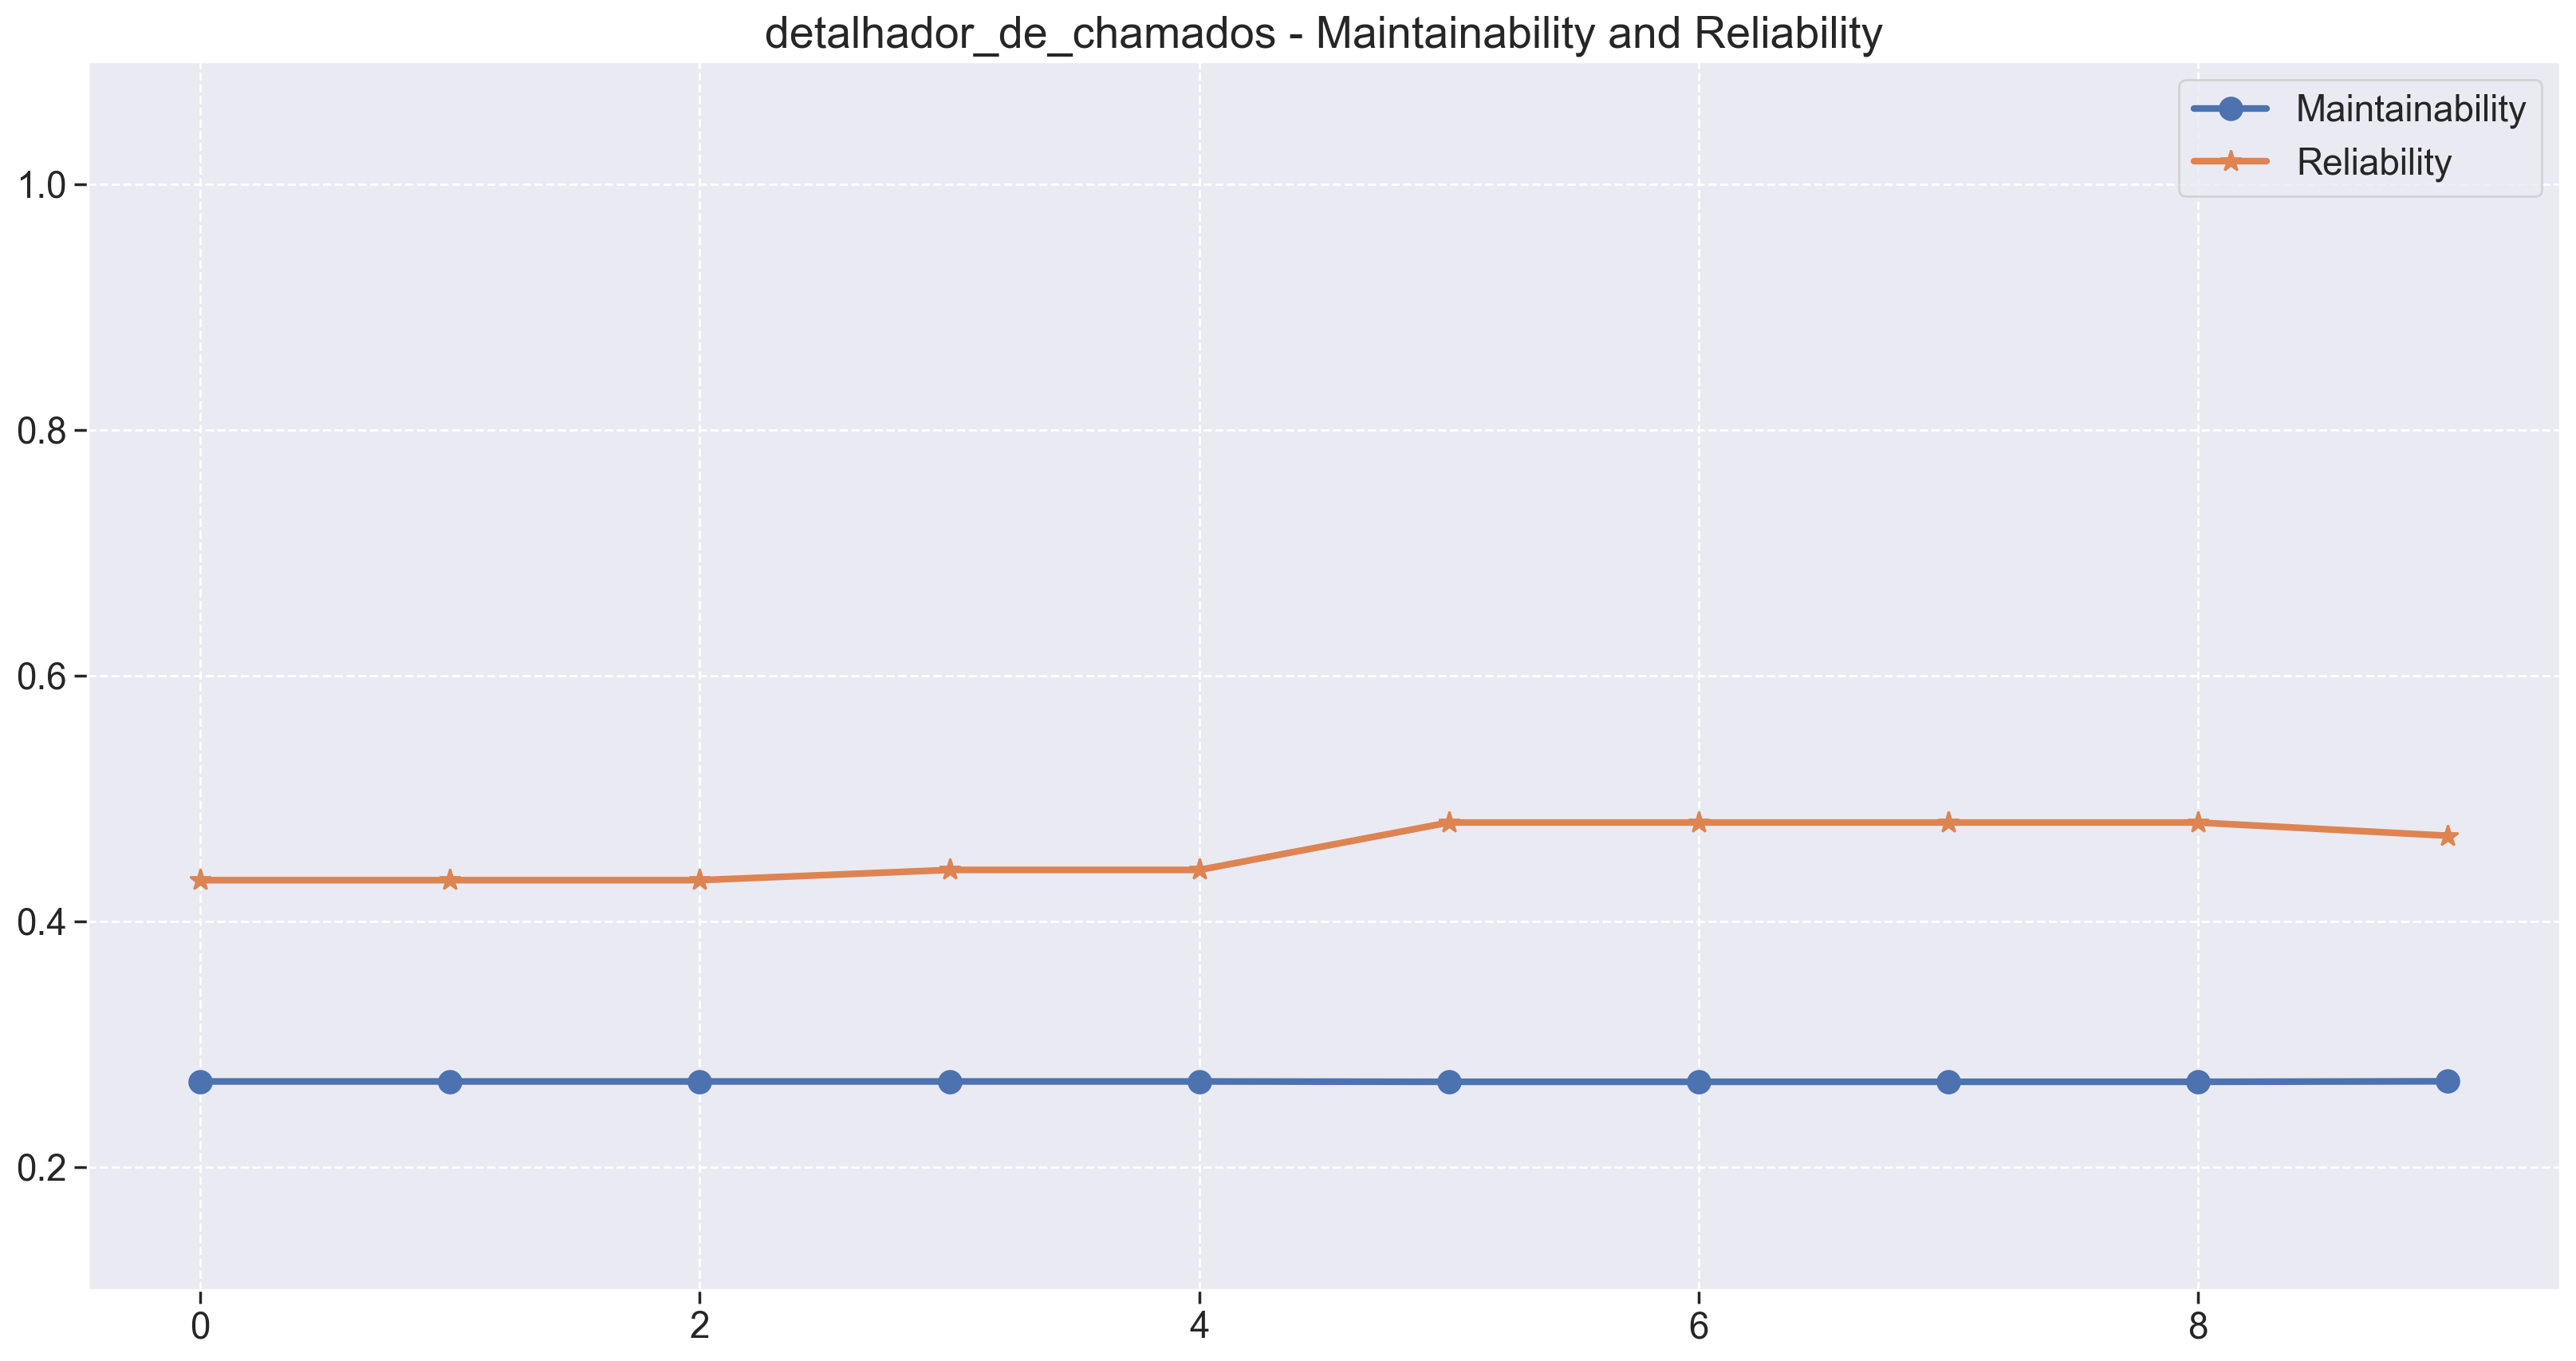

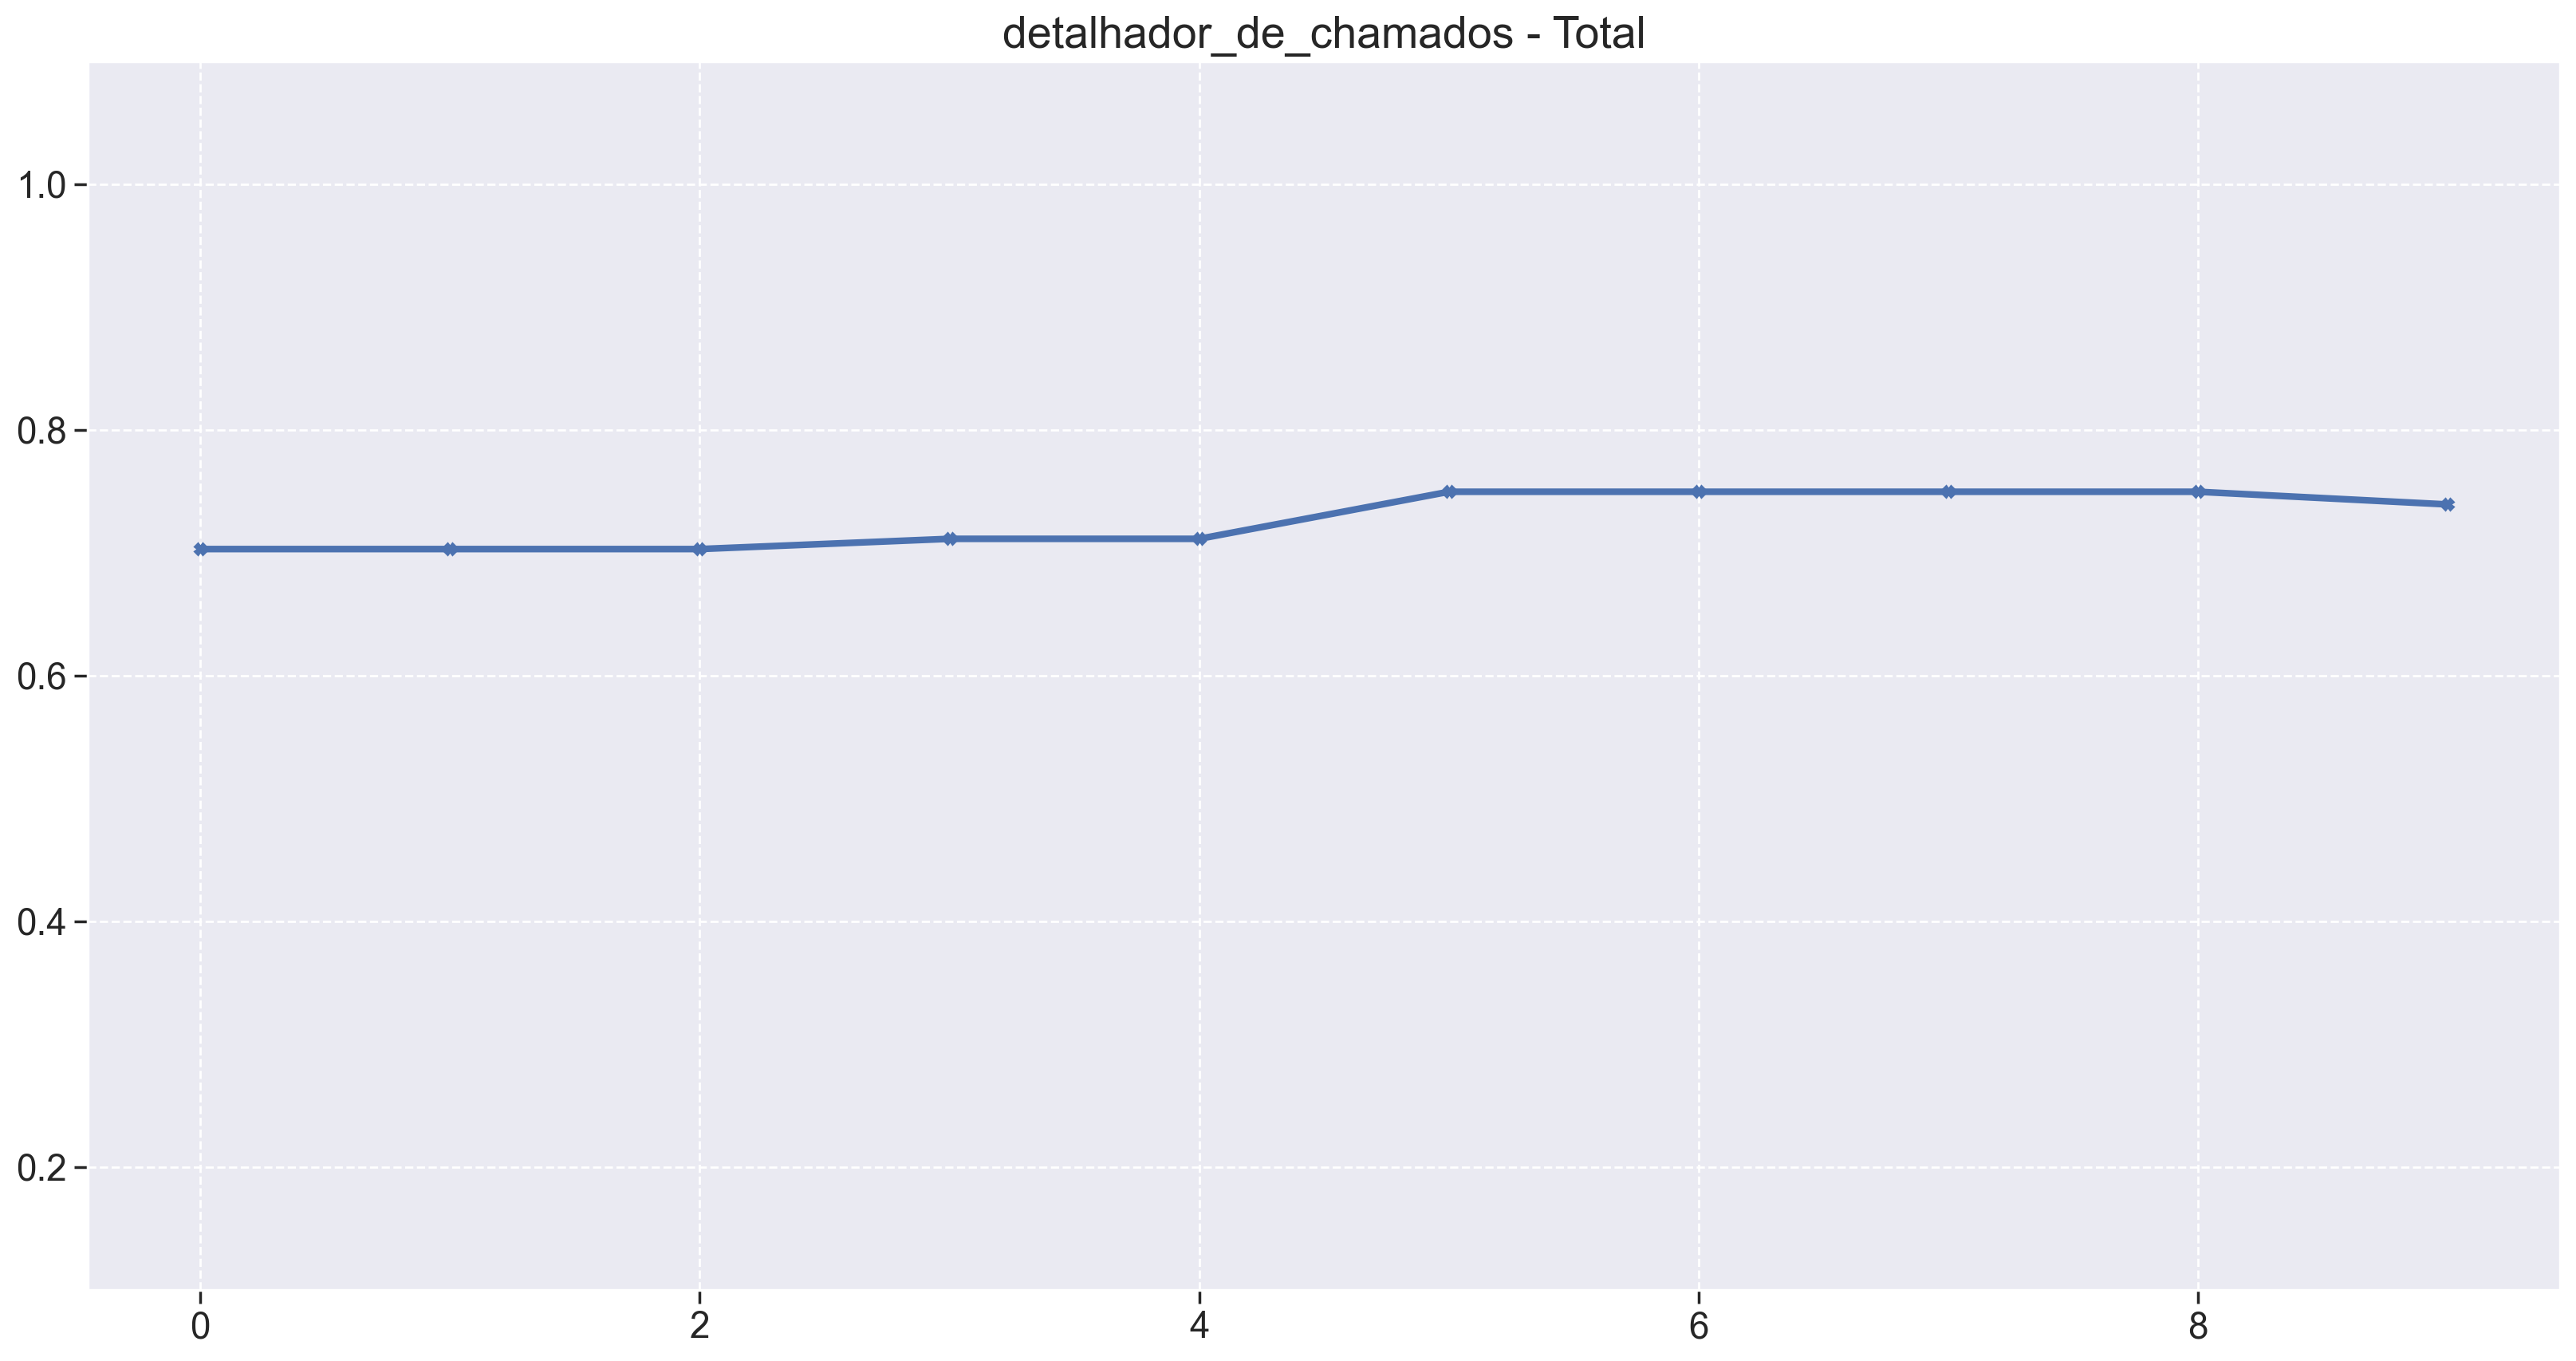

gerenciador_de_localidades
Maintainability Stats
    mean     mode   median      std      var      min   max
0.266406 0.257812 0.266406 0.009414 0.000089 0.257812 0.275
0.266406 0.275000 0.266406 0.009414 0.000089 0.257812 0.275
Reliability Stats
   mean   mode  median      std      var    min  max
0.46875 0.4375 0.46875 0.034233 0.001172 0.4375  0.5
0.46875 0.5000 0.46875 0.034233 0.001172 0.4375  0.5


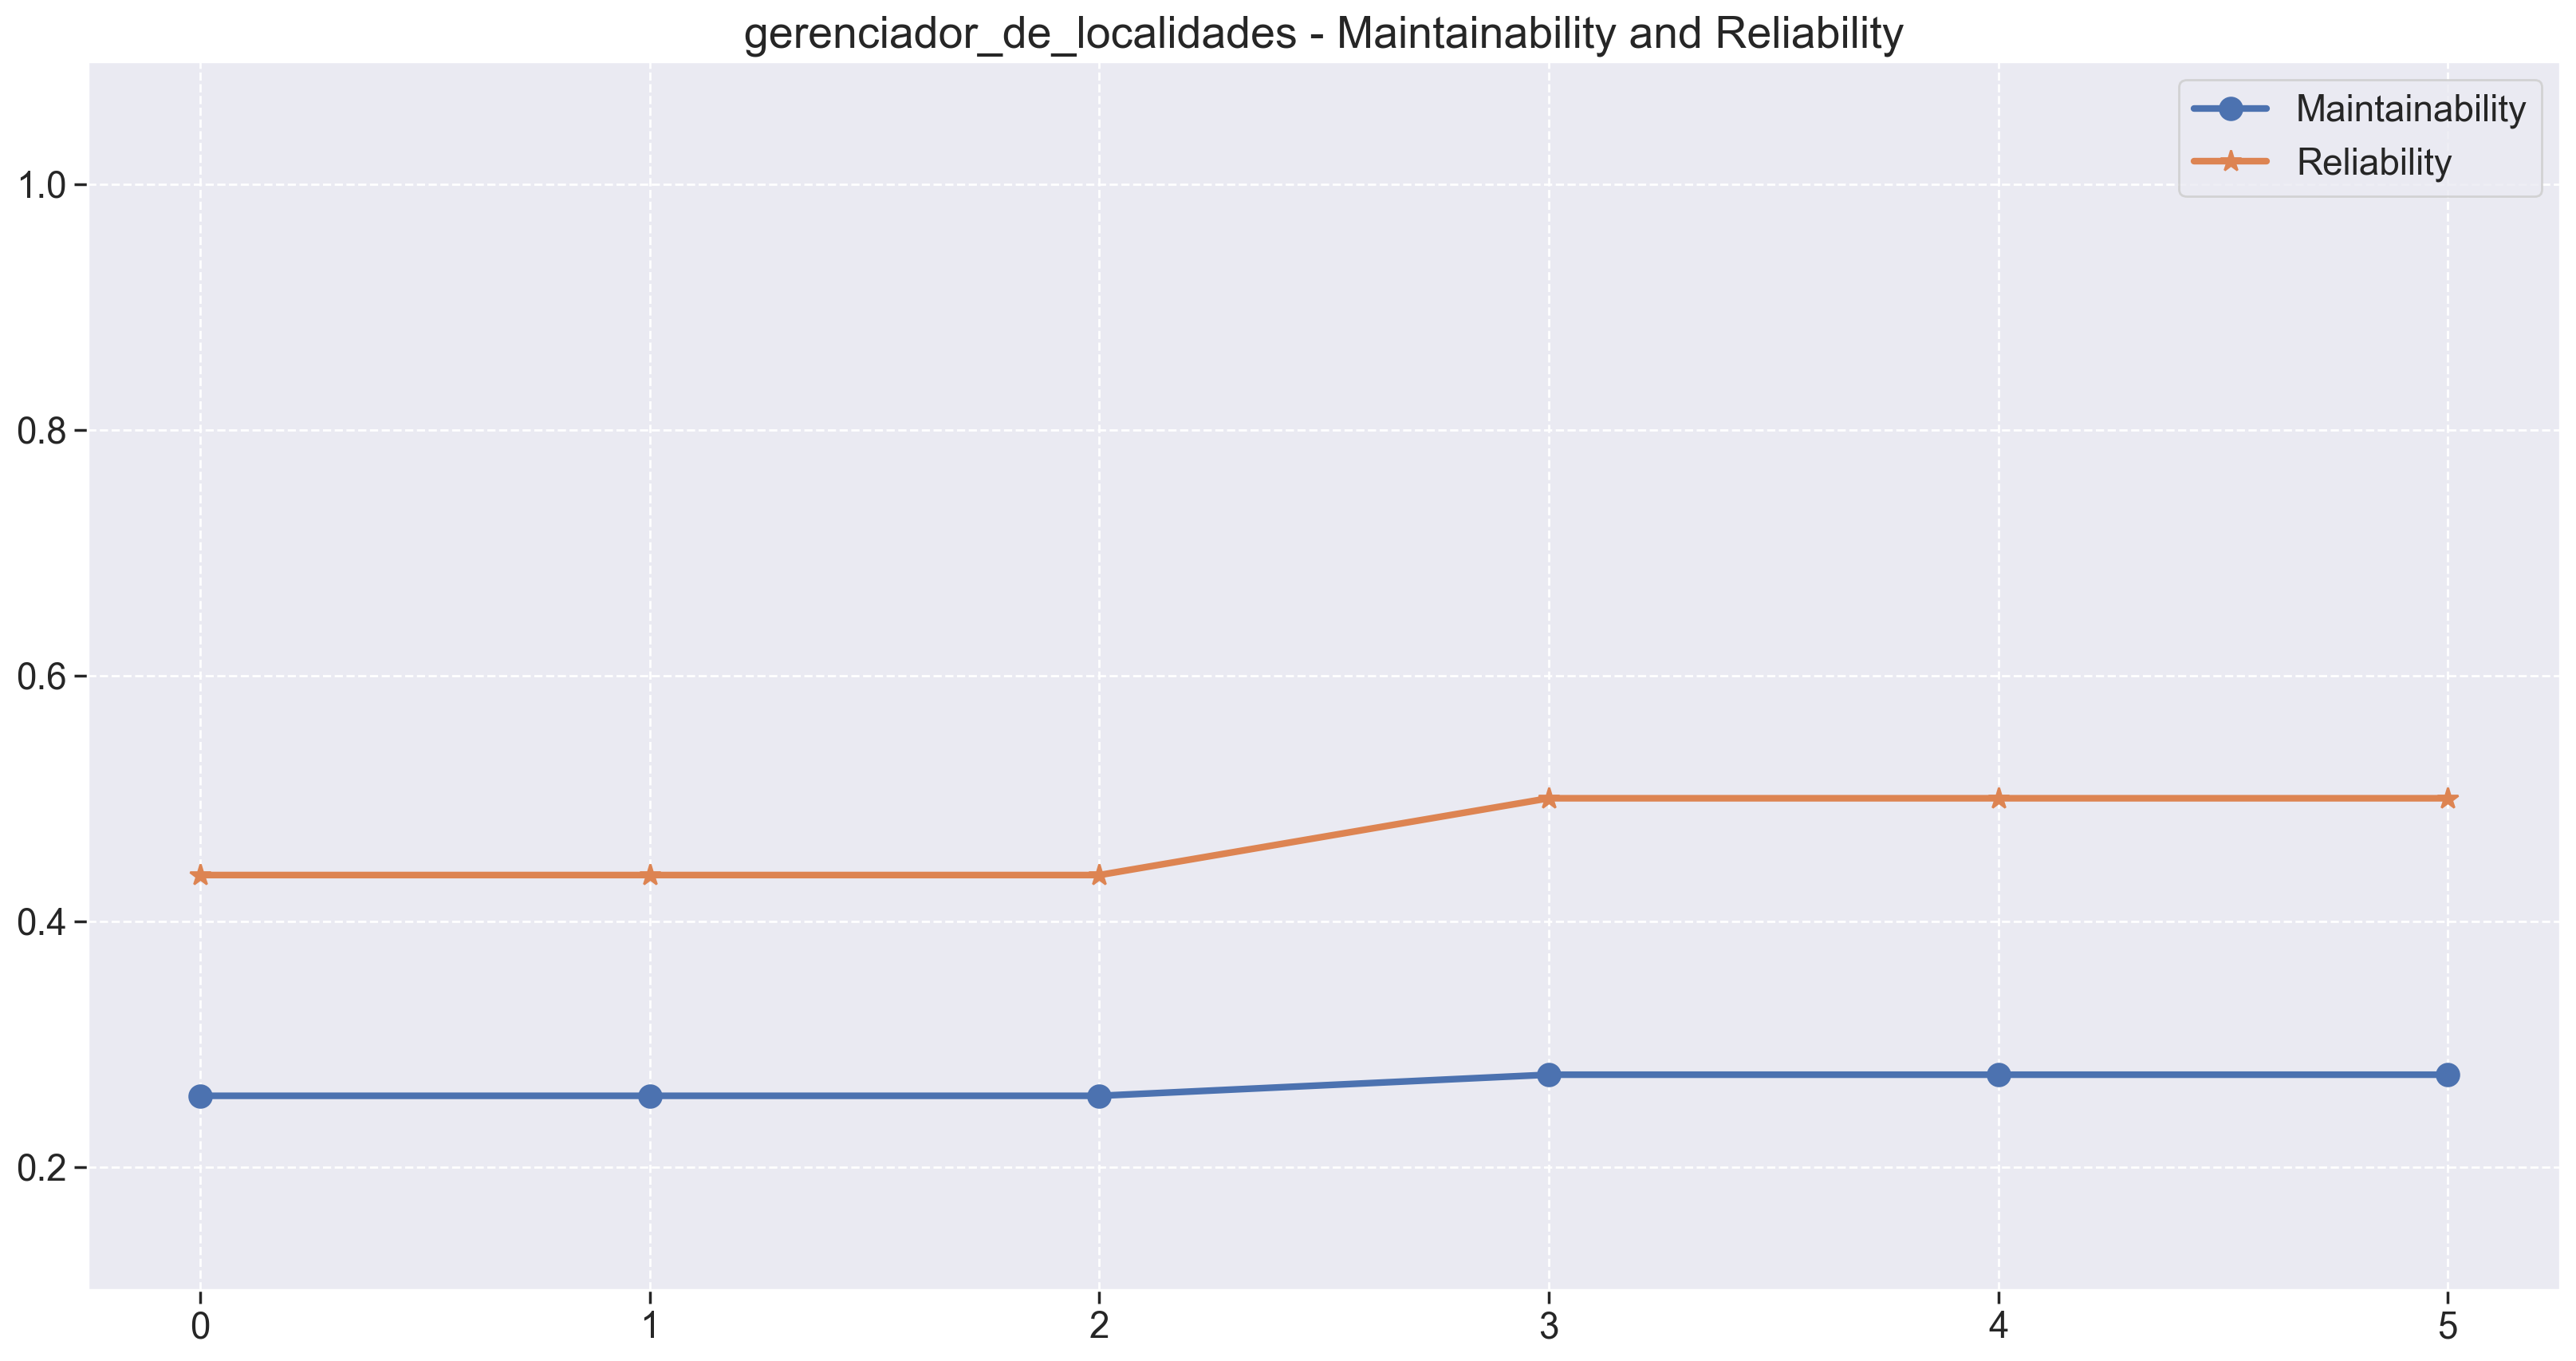

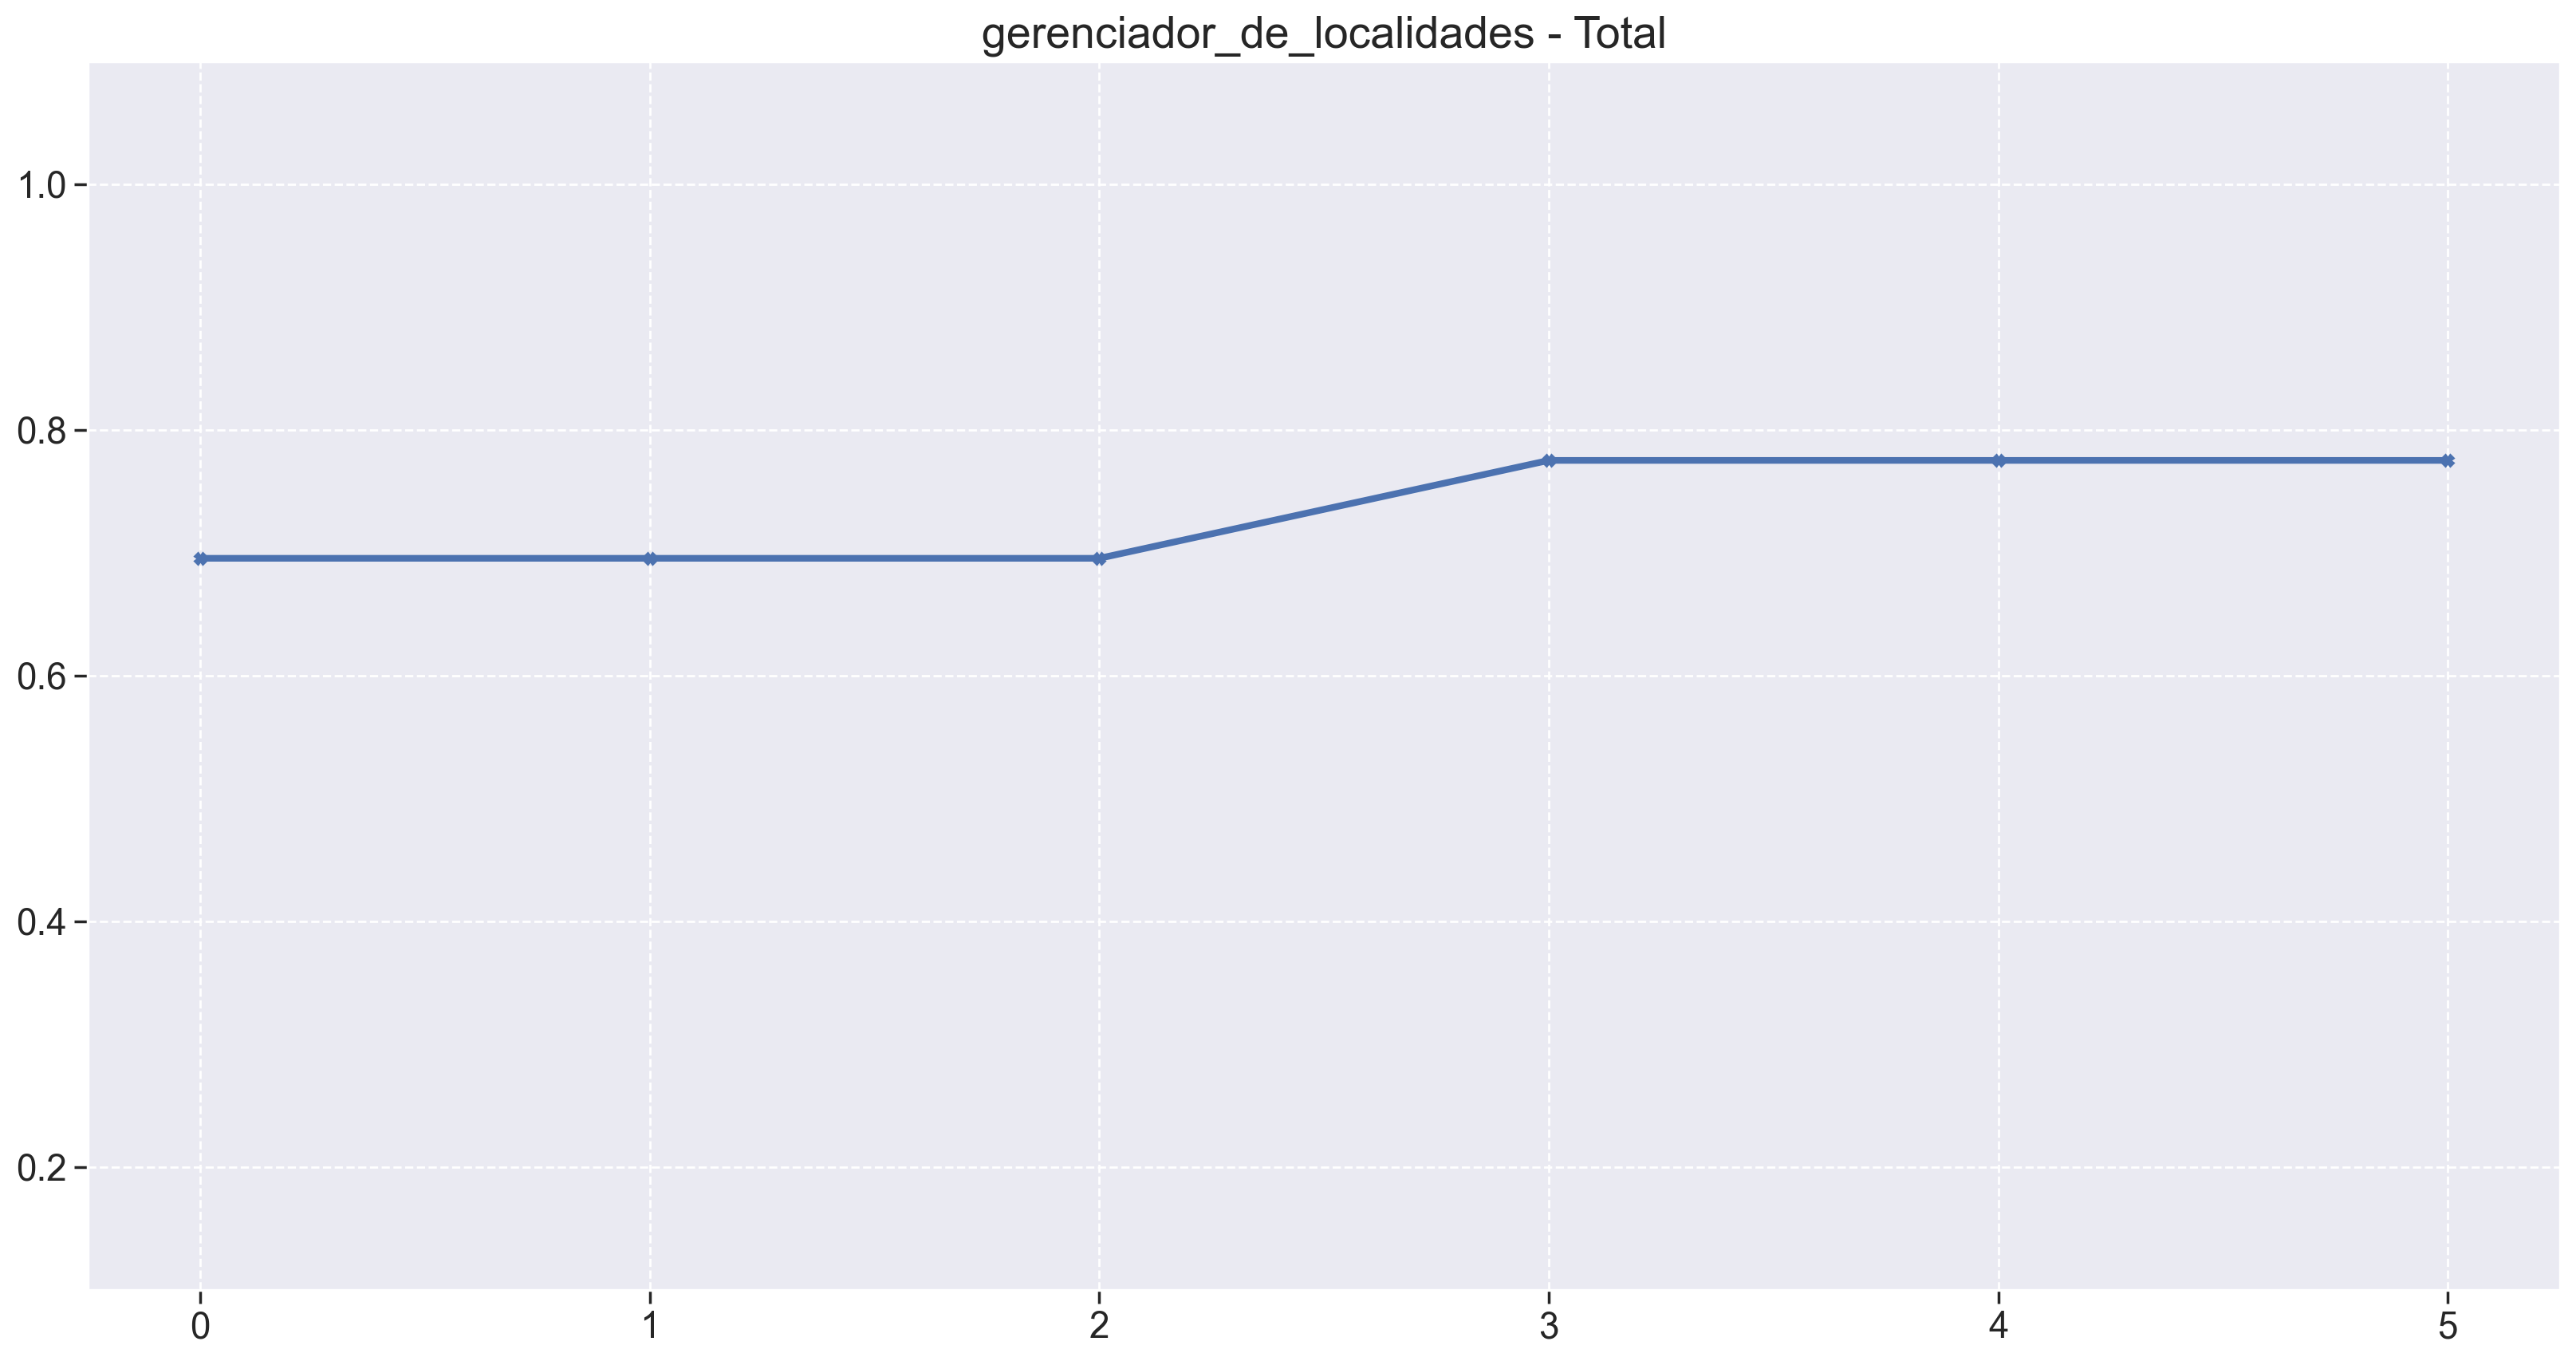

gerenciador_de_tutoriais
Maintainability Stats
    mean     mode   median      std      var    min   max
0.262969 0.257812 0.257812 0.010555 0.000111 0.2475 0.275
Reliability Stats
   mean   mode  median      std      var  min  max
0.45625 0.4375  0.4375 0.038382 0.001473  0.4  0.5


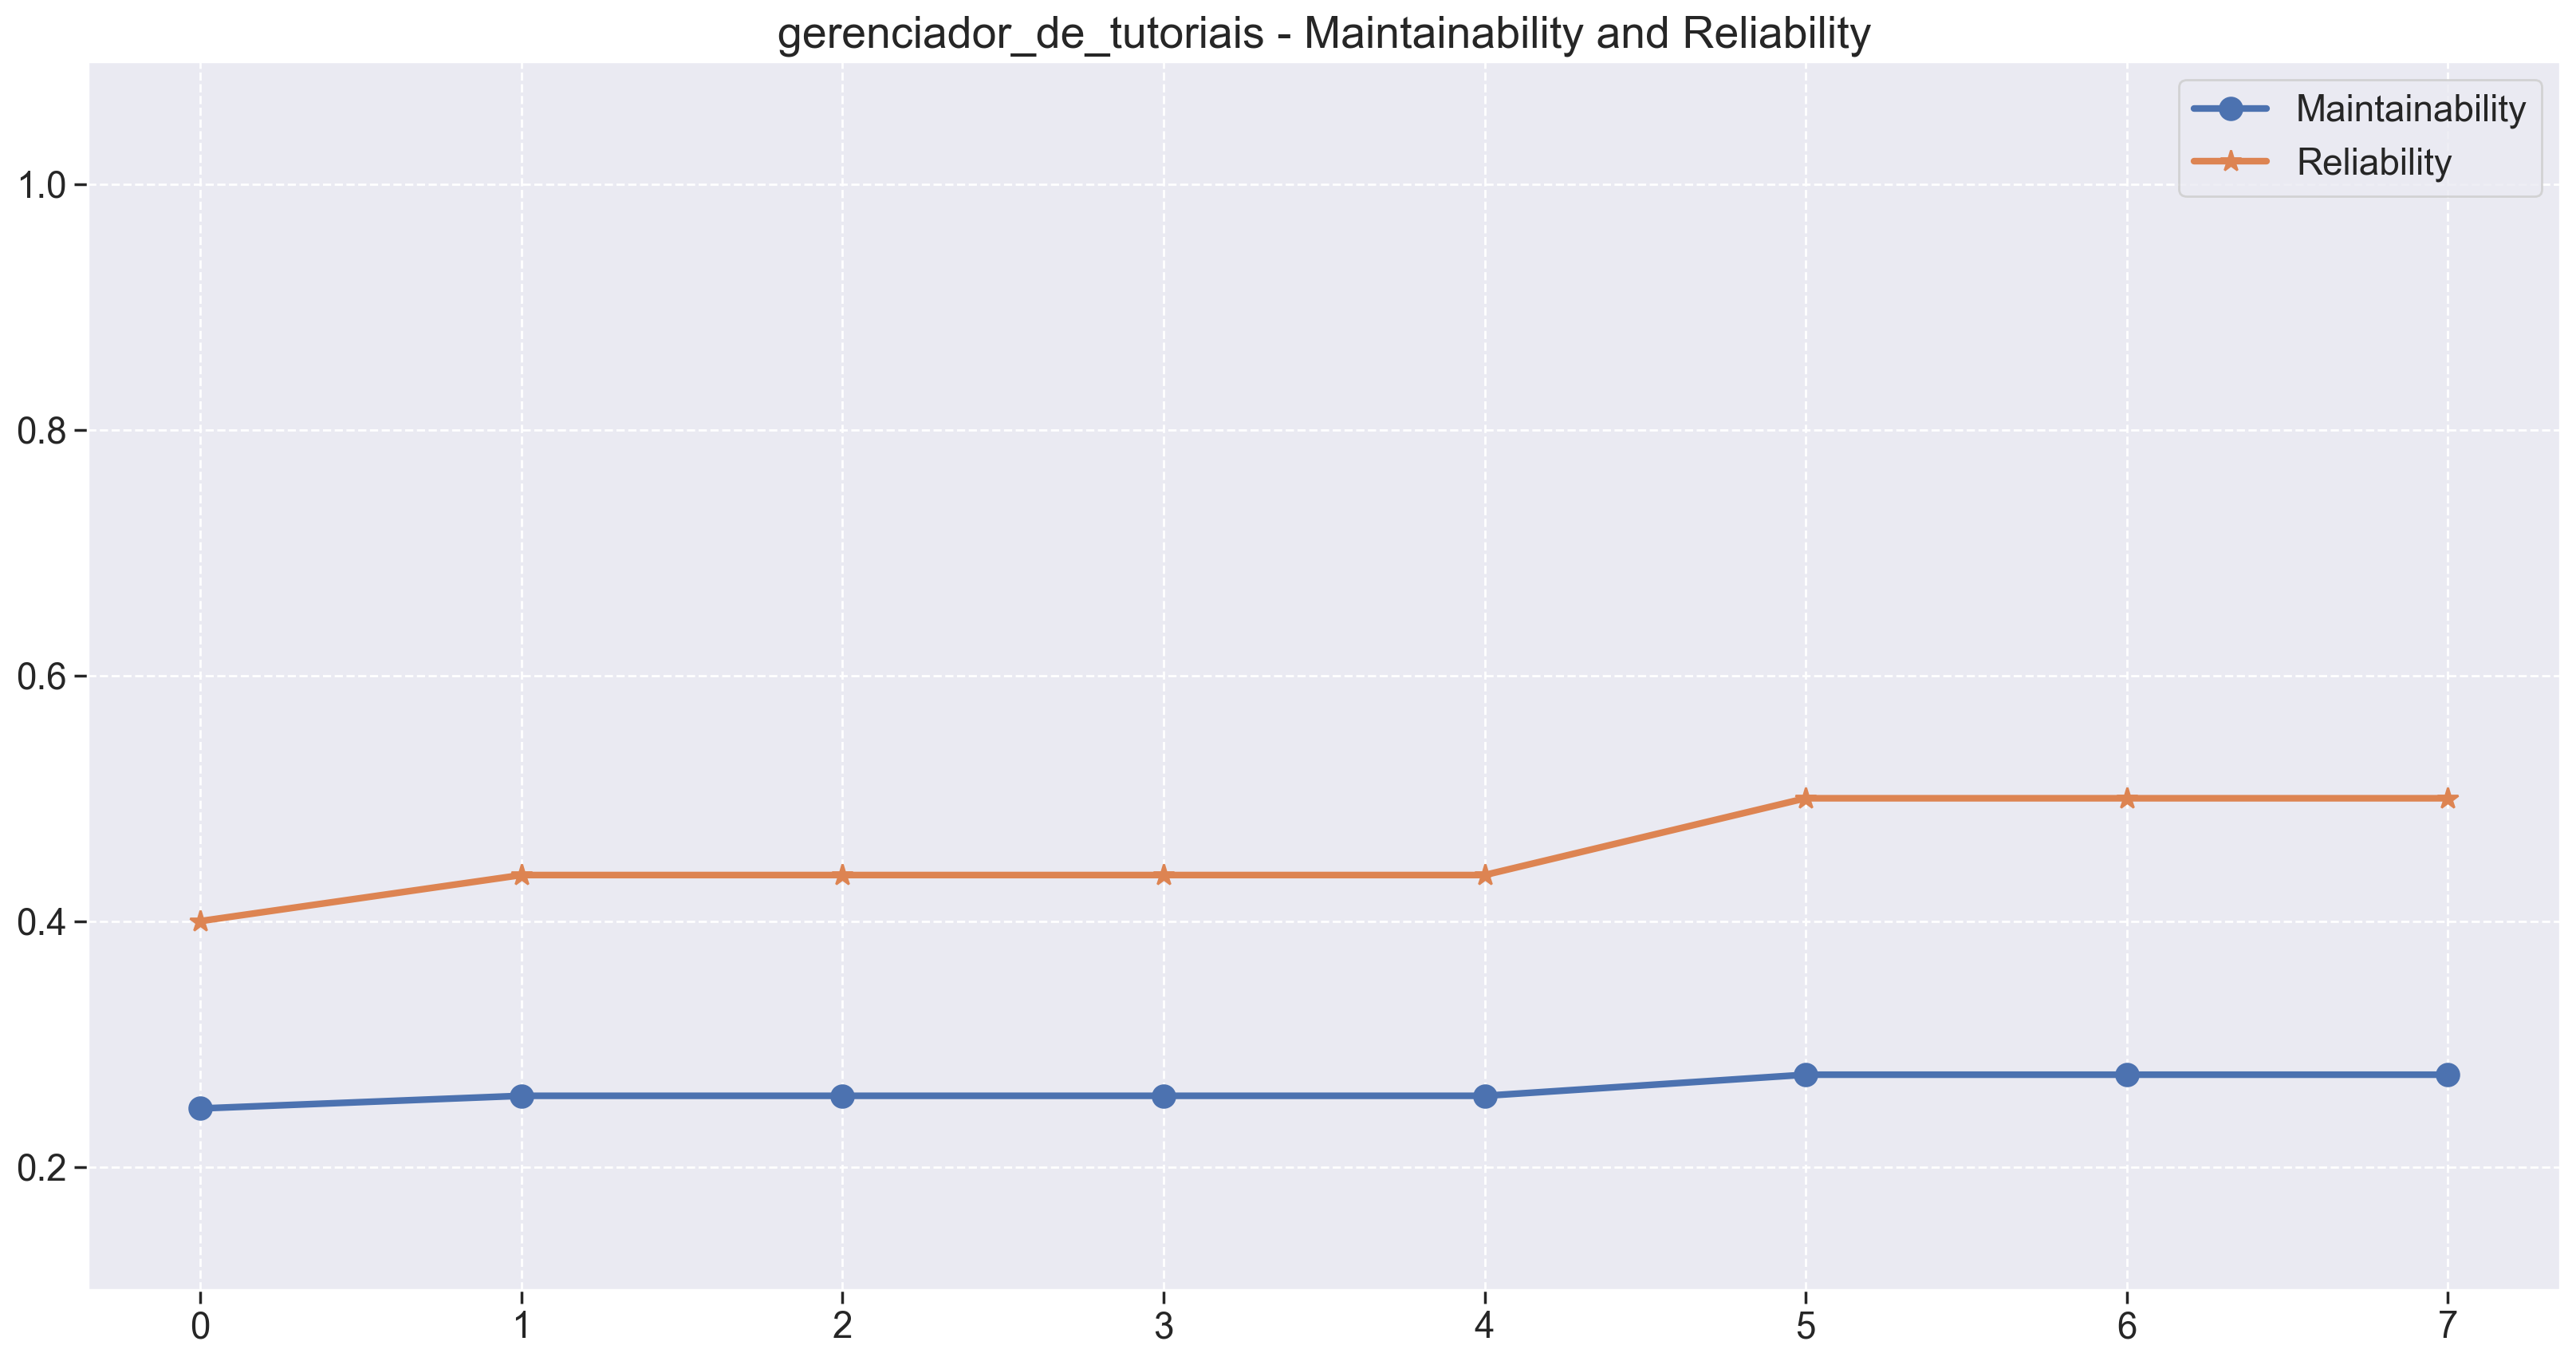

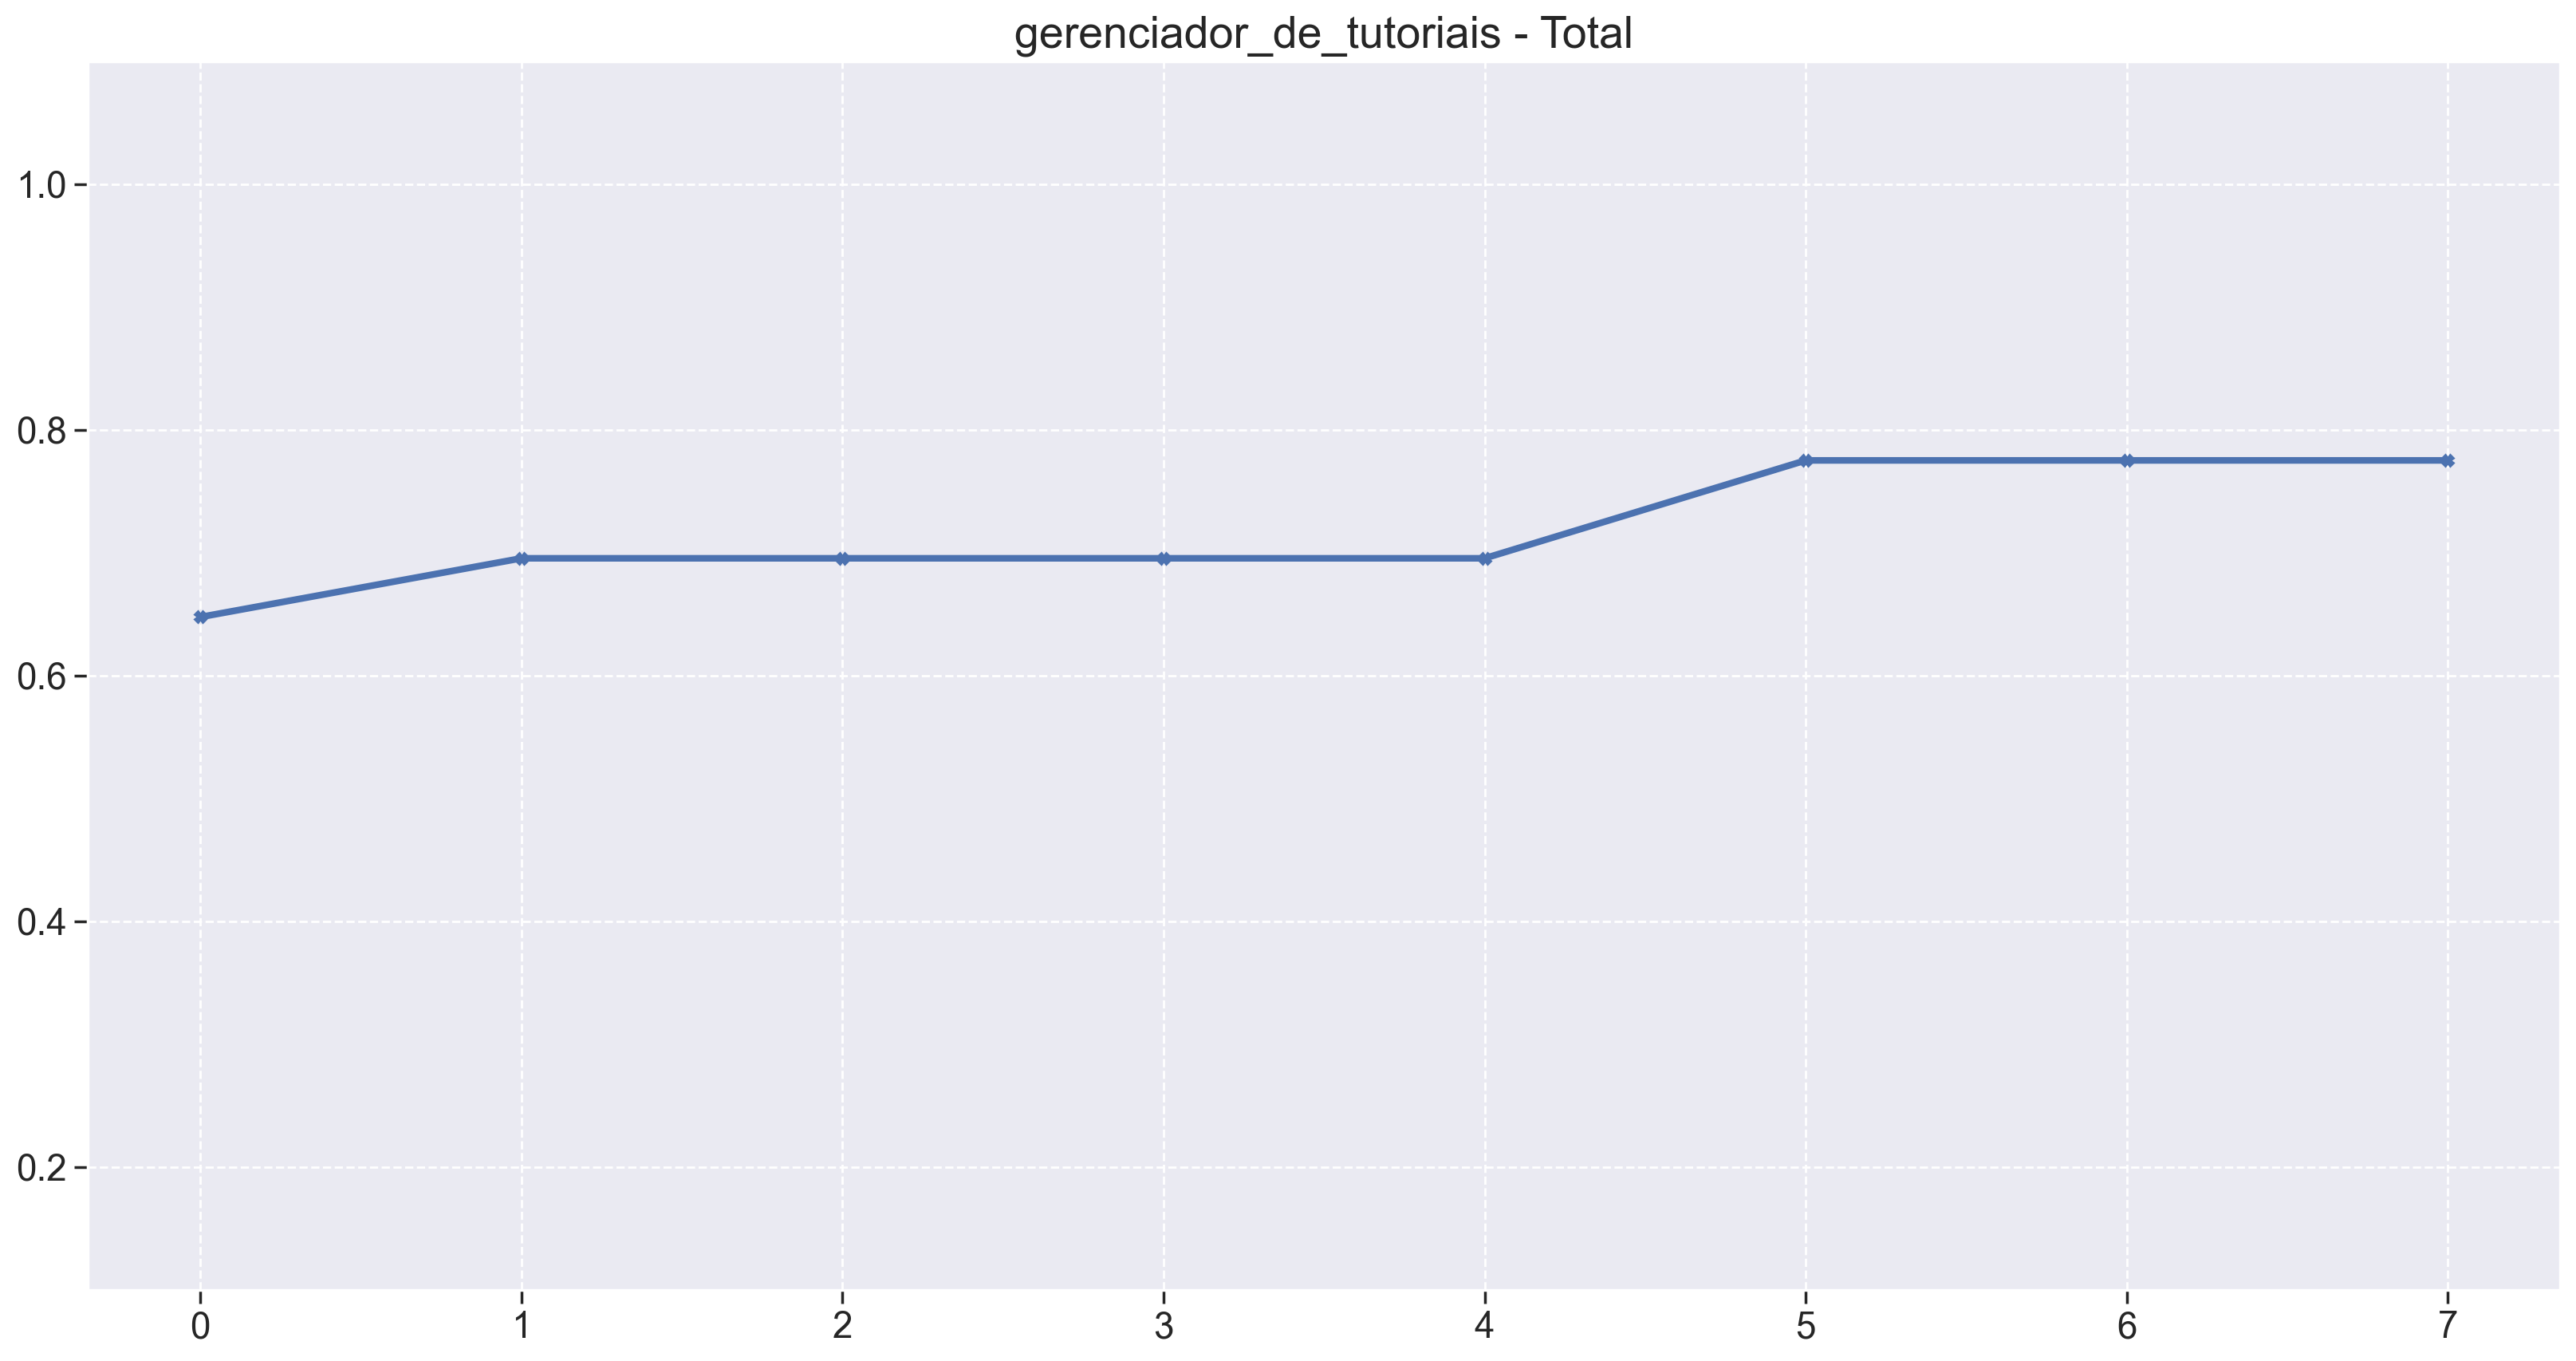

gestor_de_alerta
Maintainability Stats
    mean     mode   median      std      var    min      max
0.256339 0.259286 0.259286 0.005893 0.000035 0.2475 0.259286
Reliability Stats
 mean  mode  median  std    var  min  max
0.475   0.5     0.5 0.05 0.0025  0.4  0.5


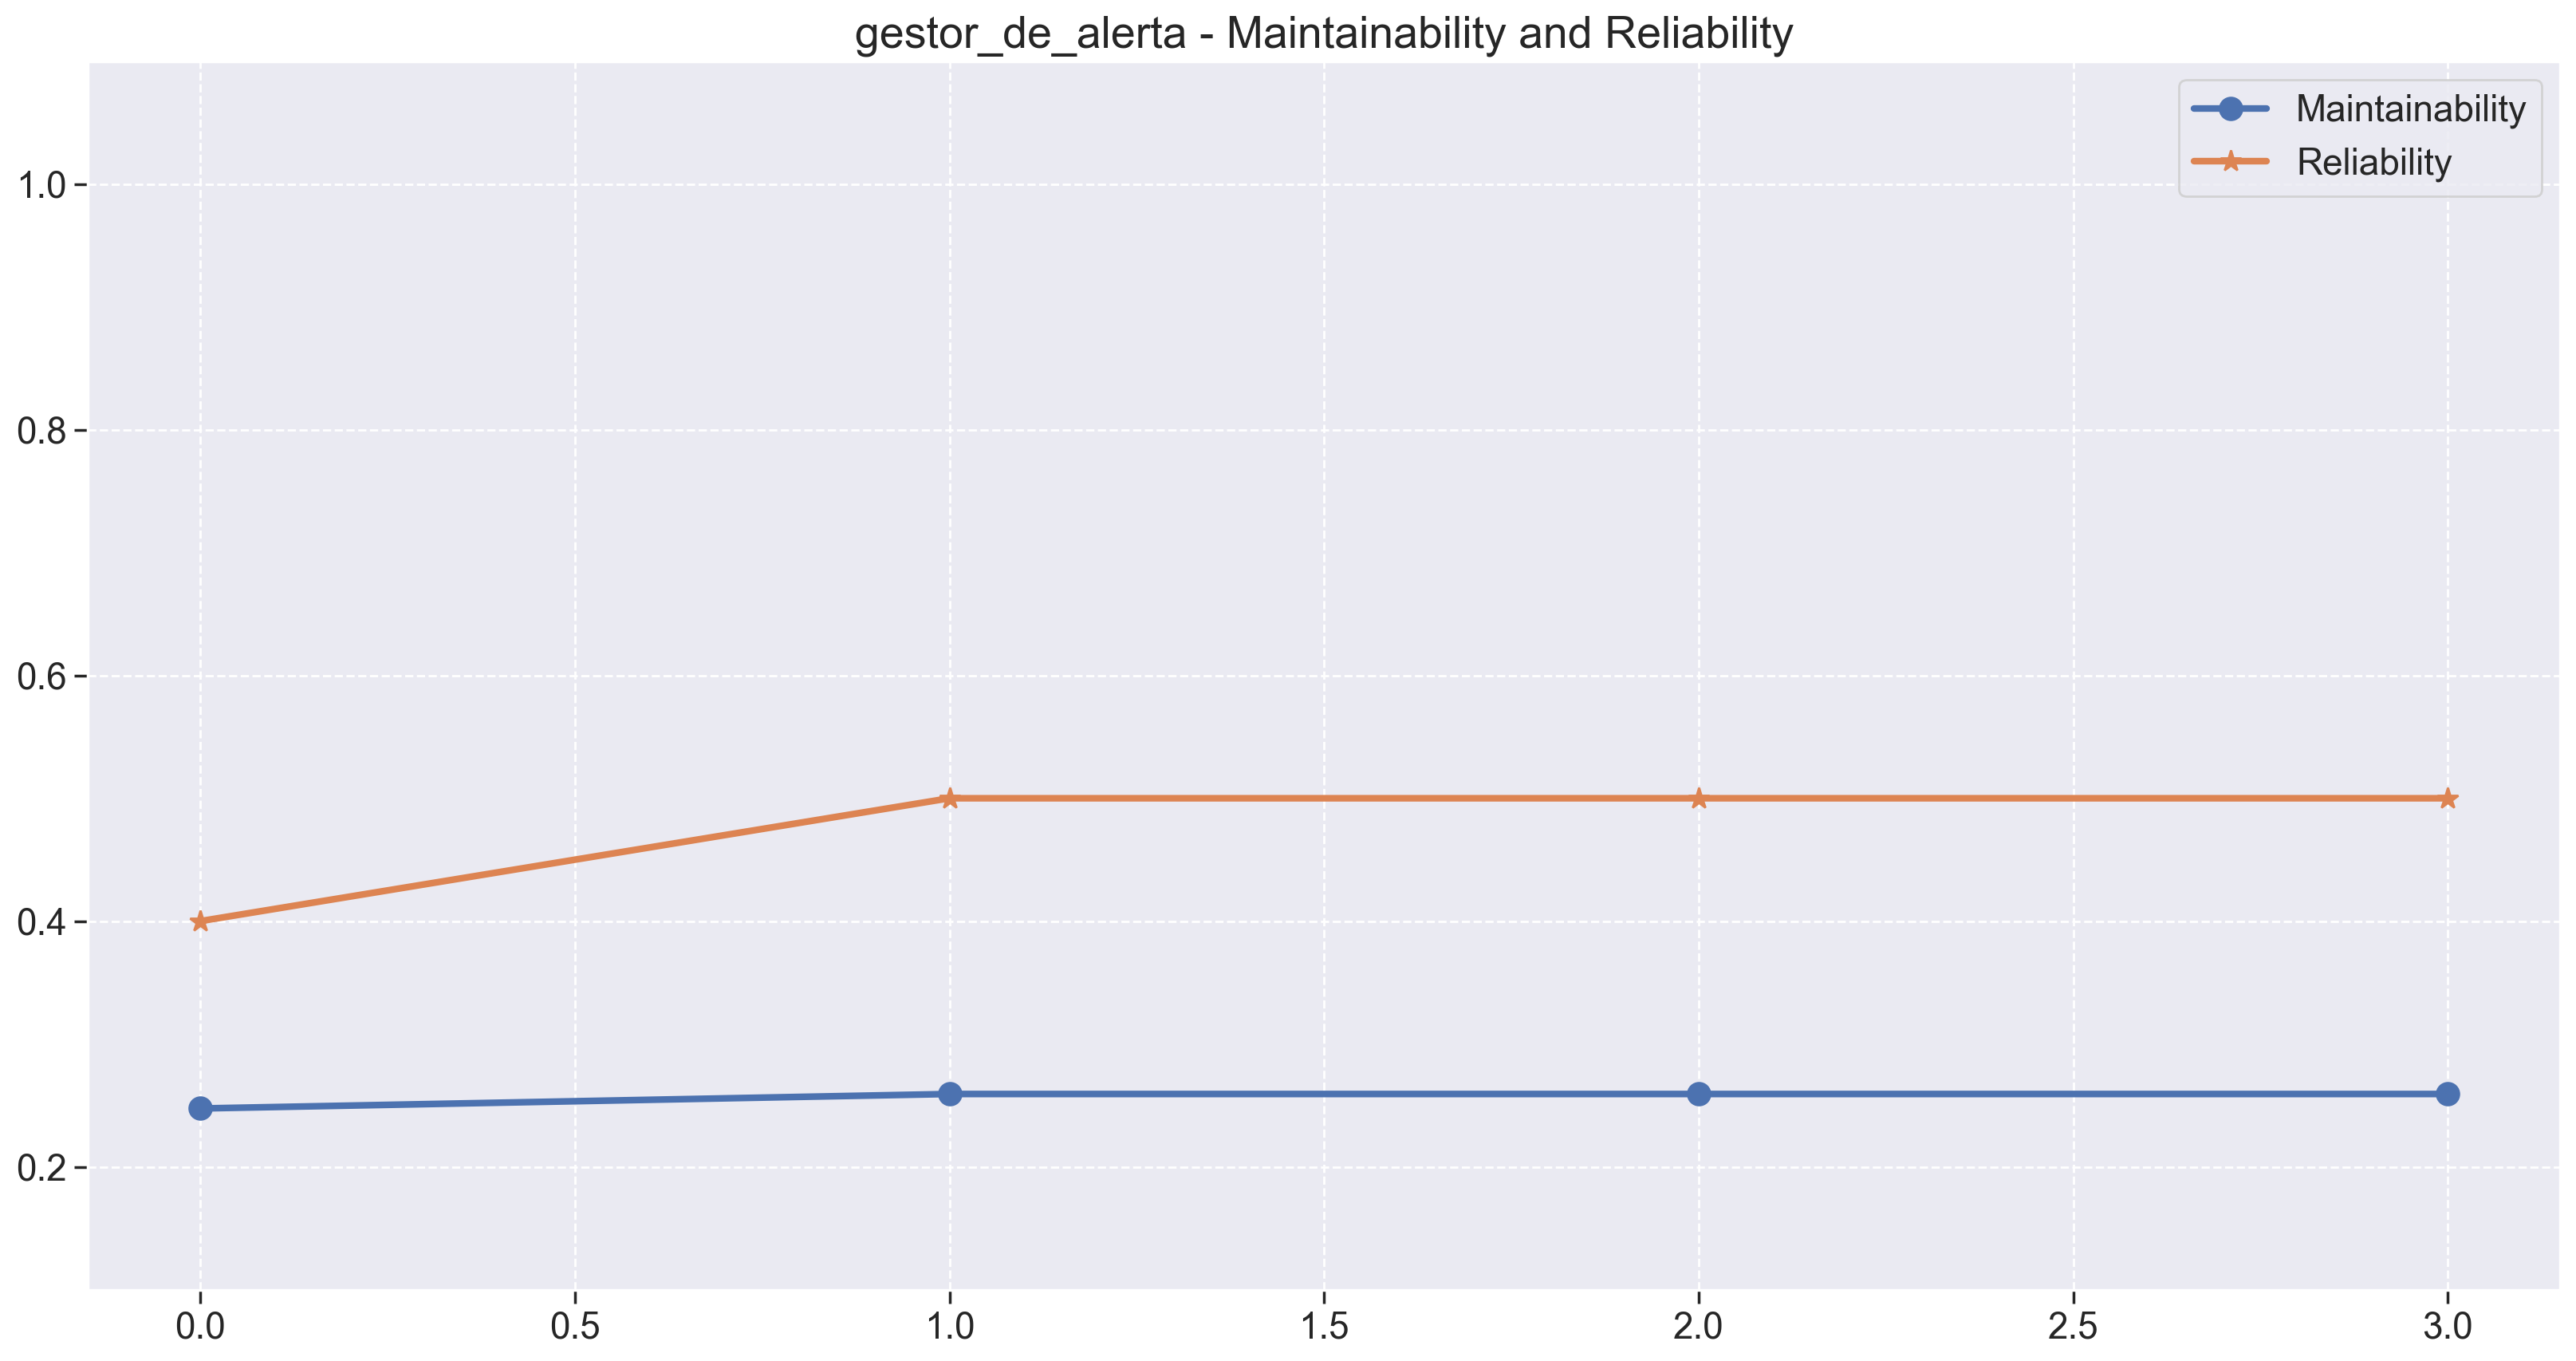

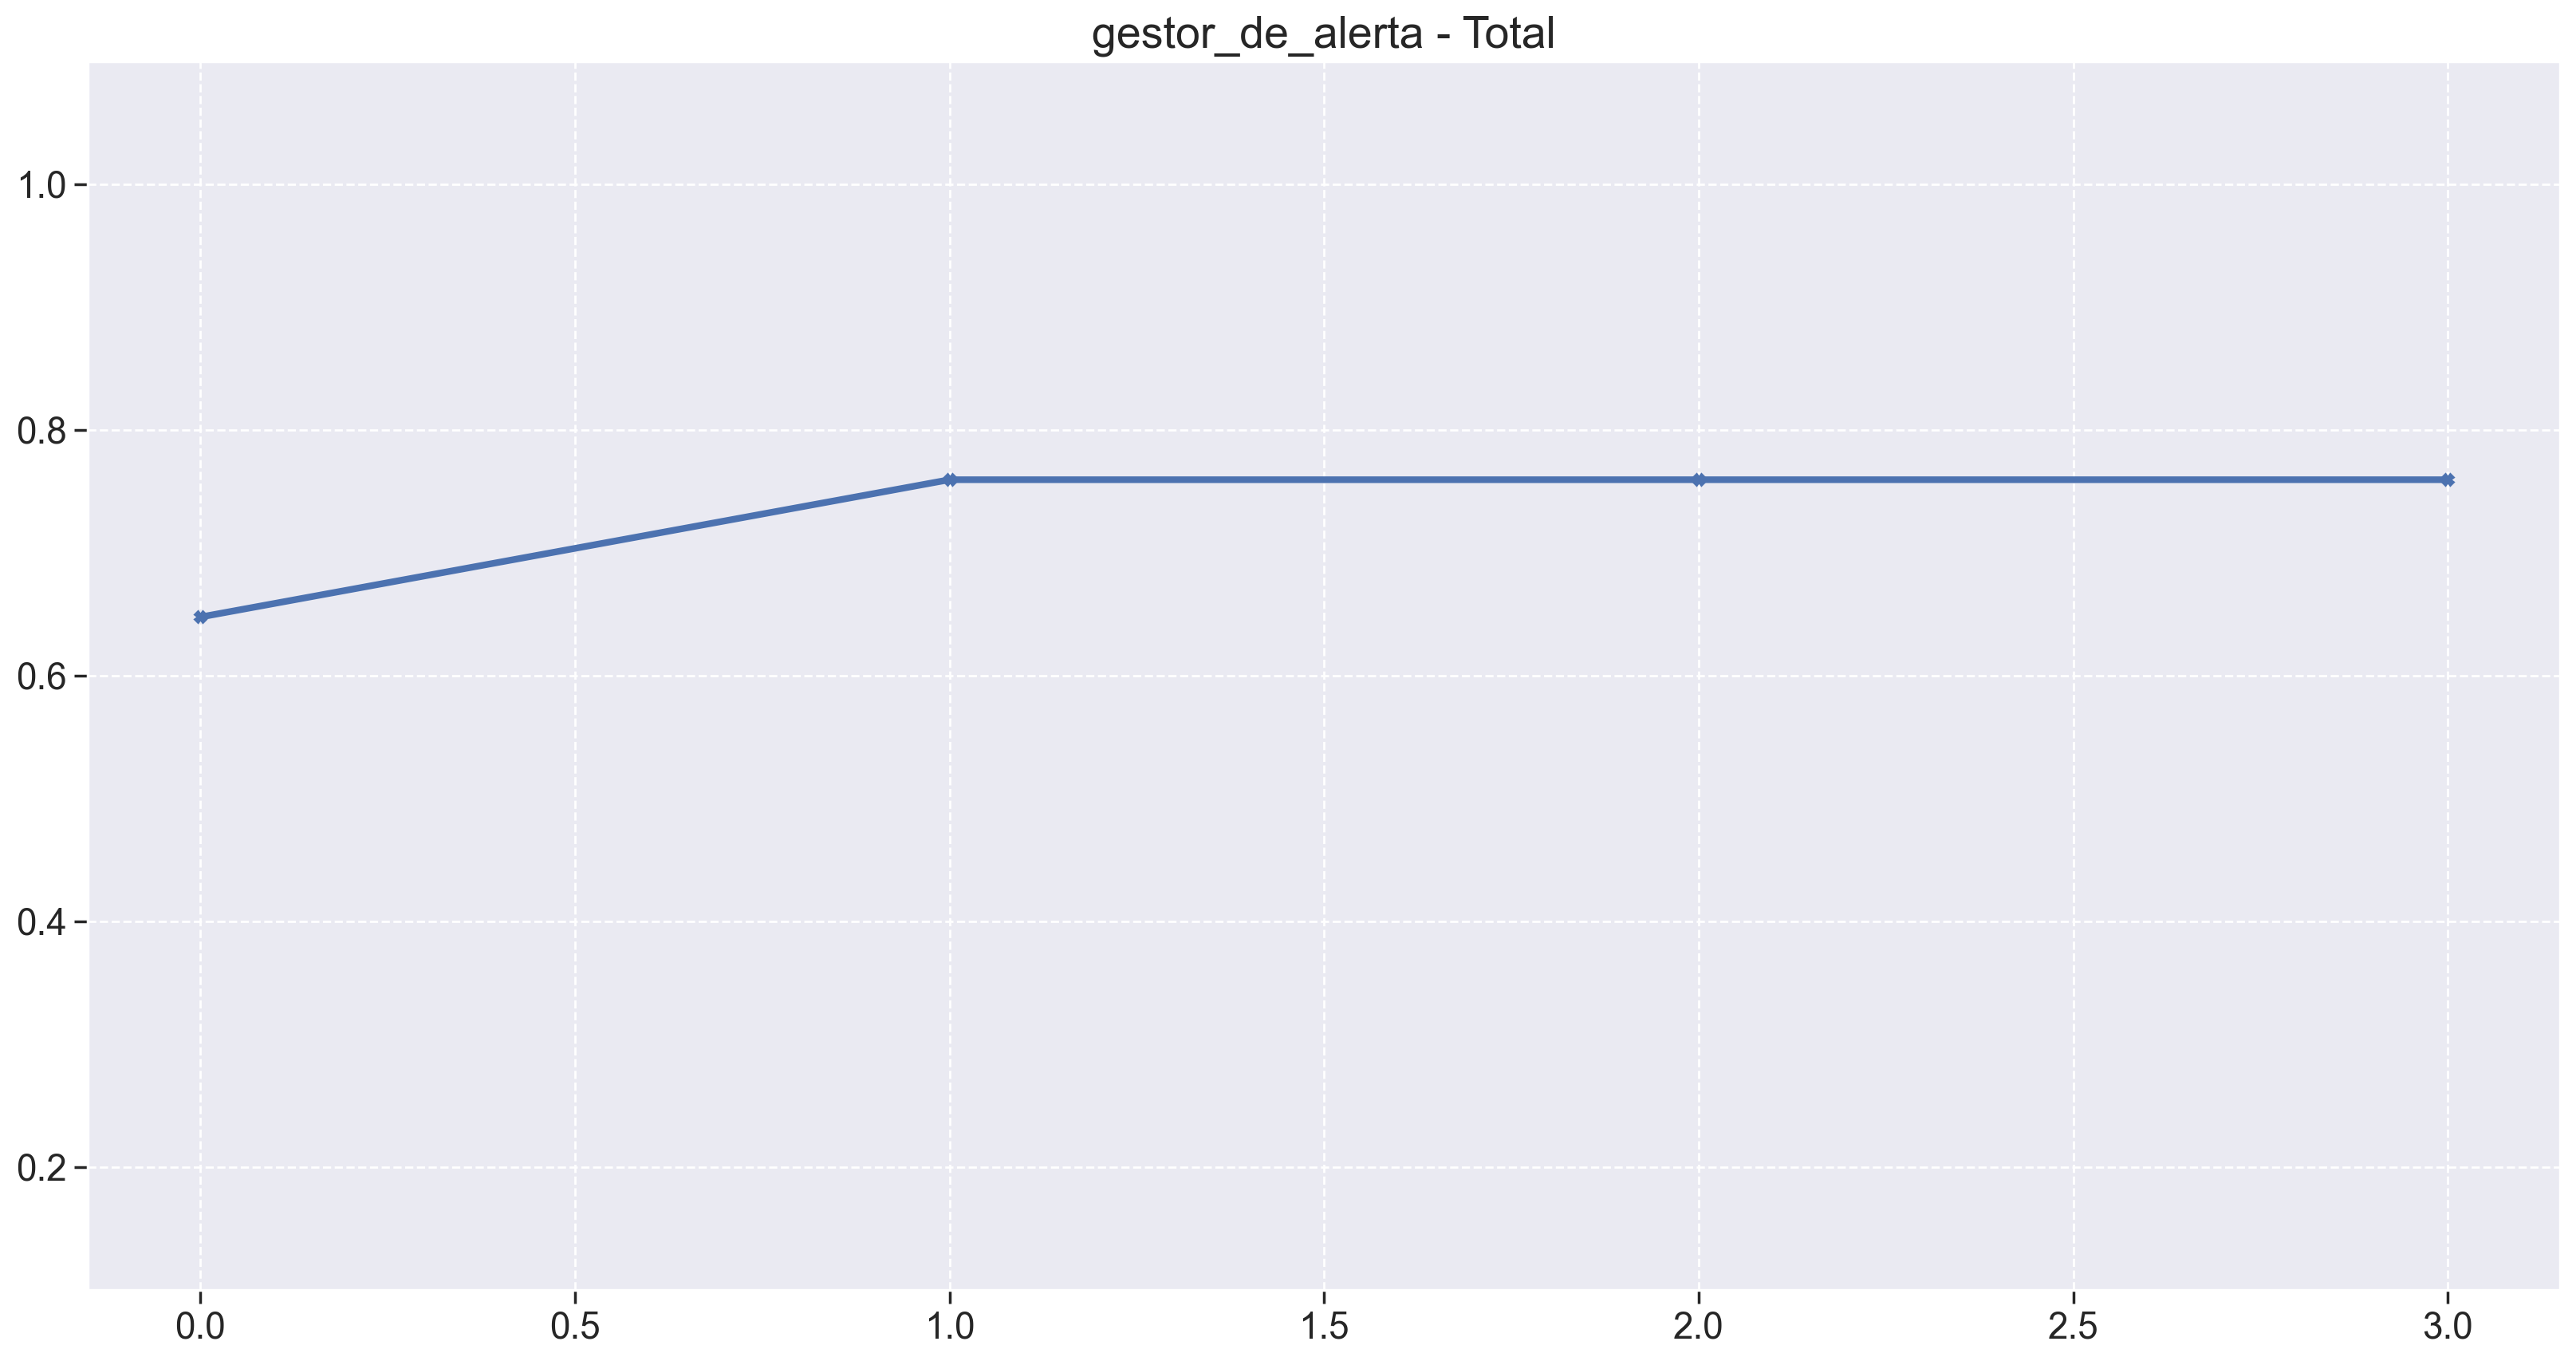

In [63]:
for name, data in metrics.items():
    print(name)
    analysis(data, name)

### Quality characteristic indicator

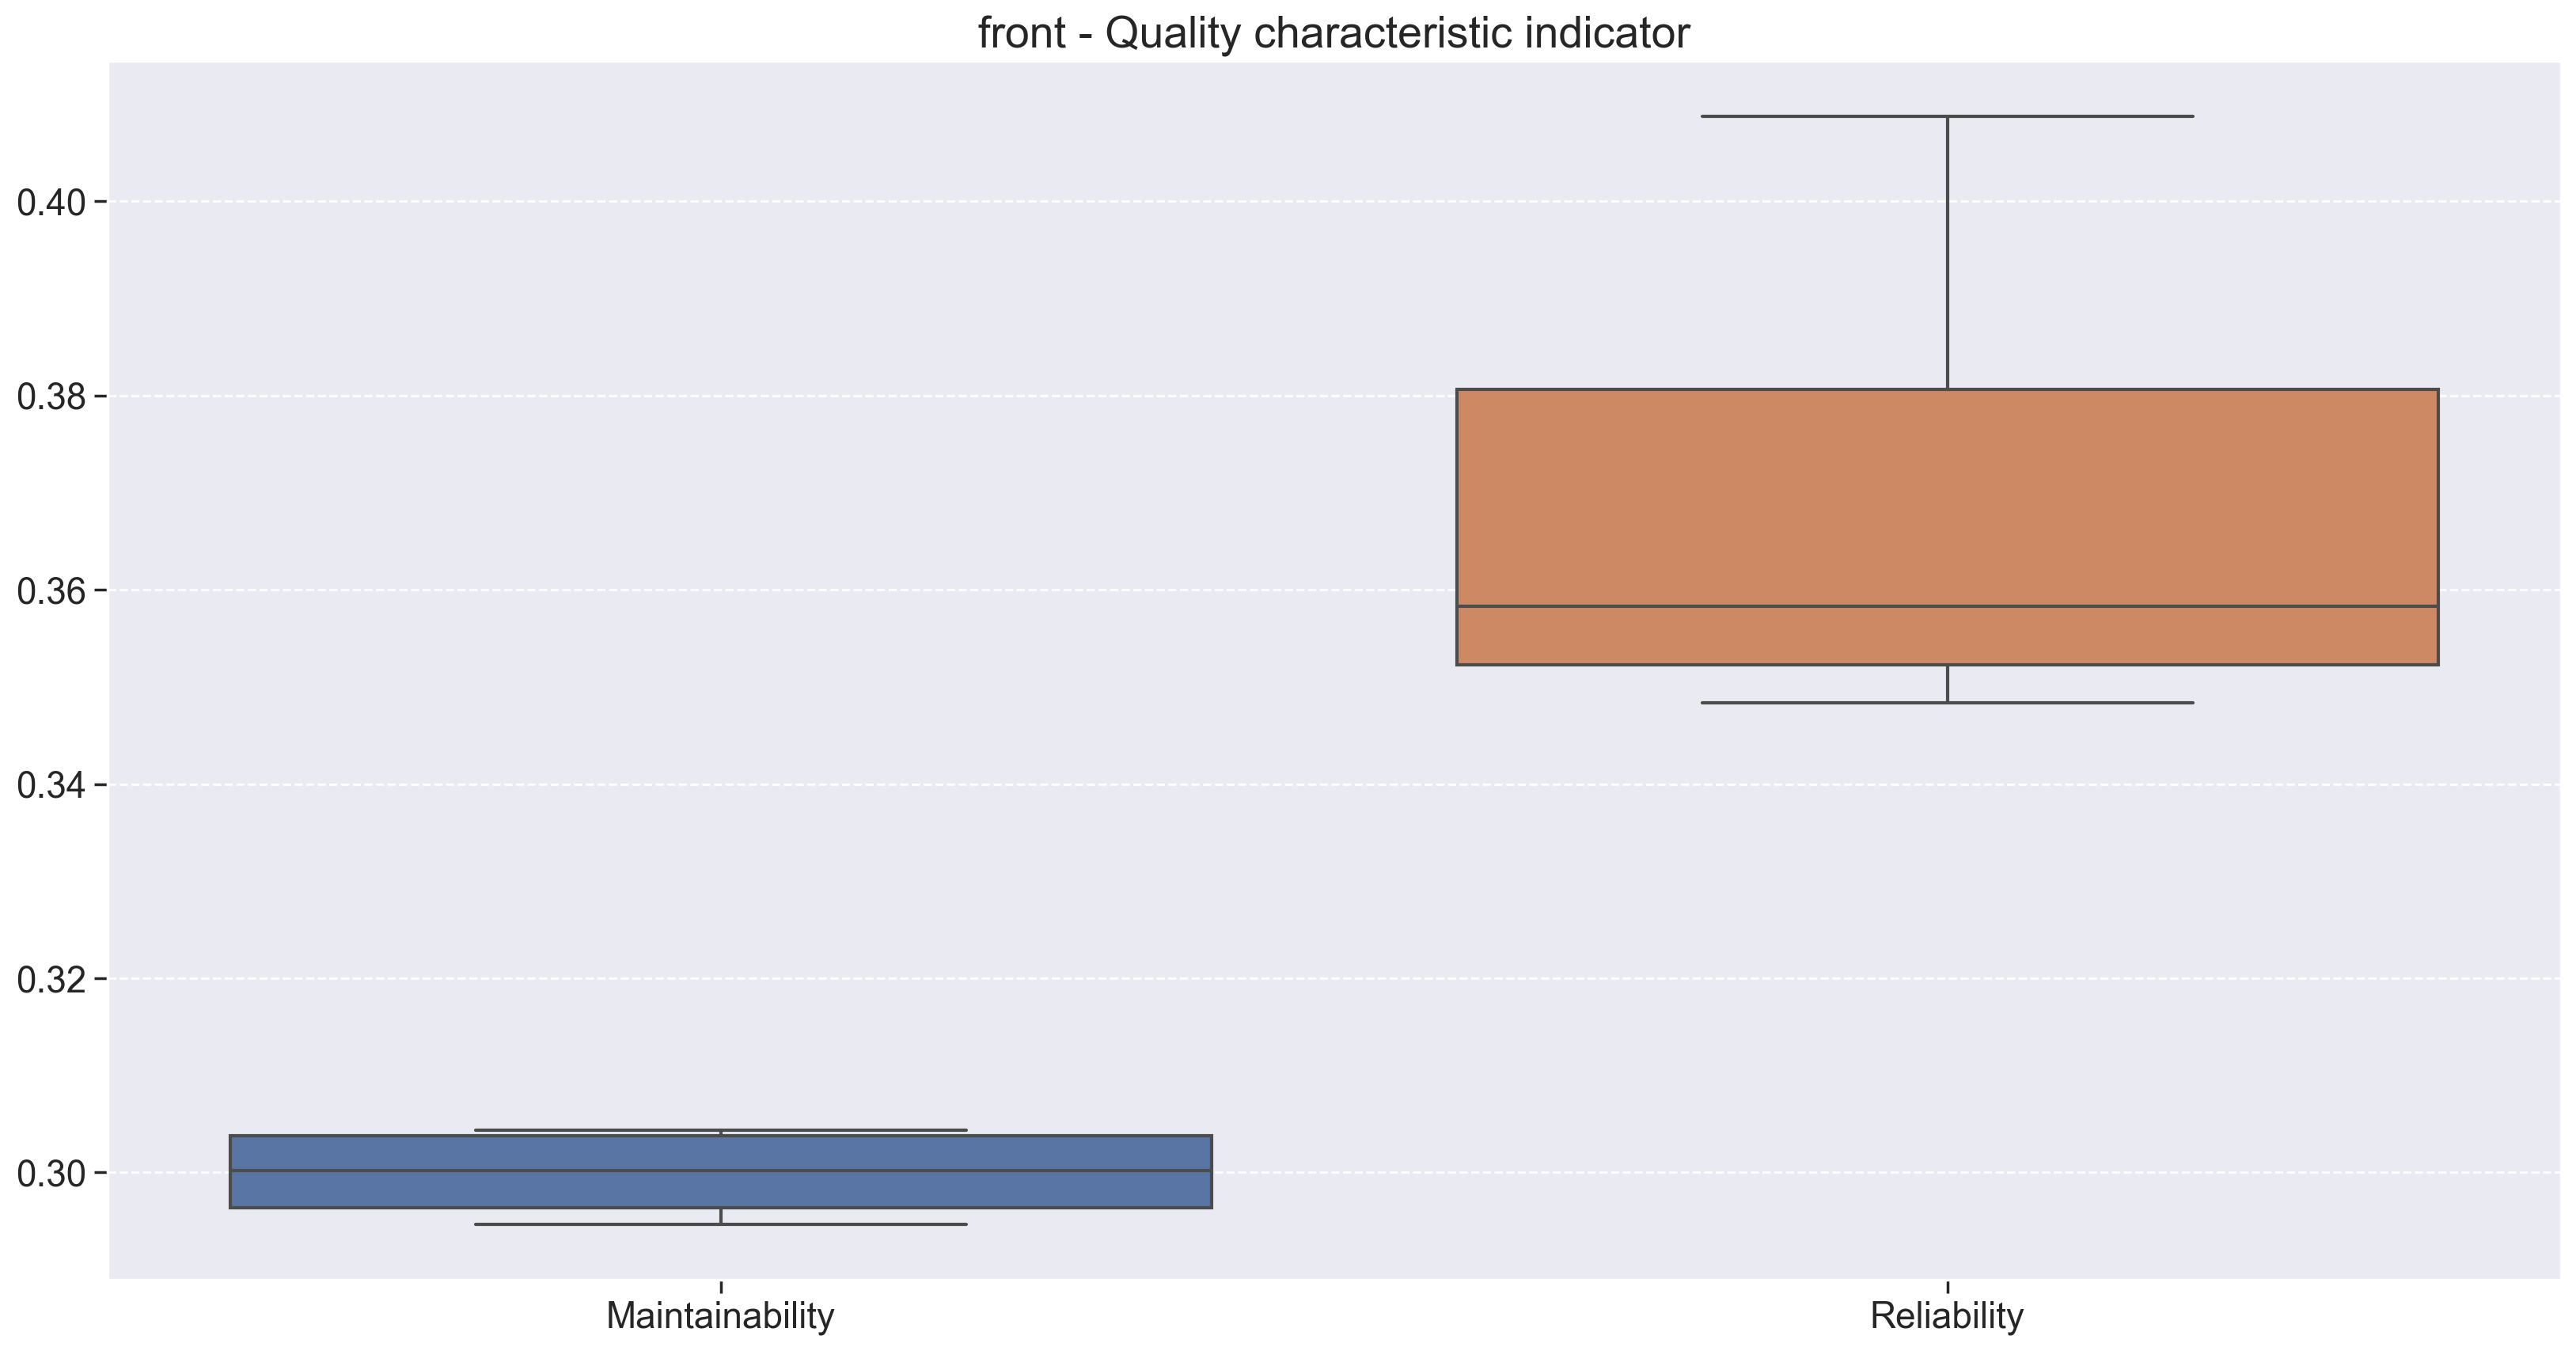

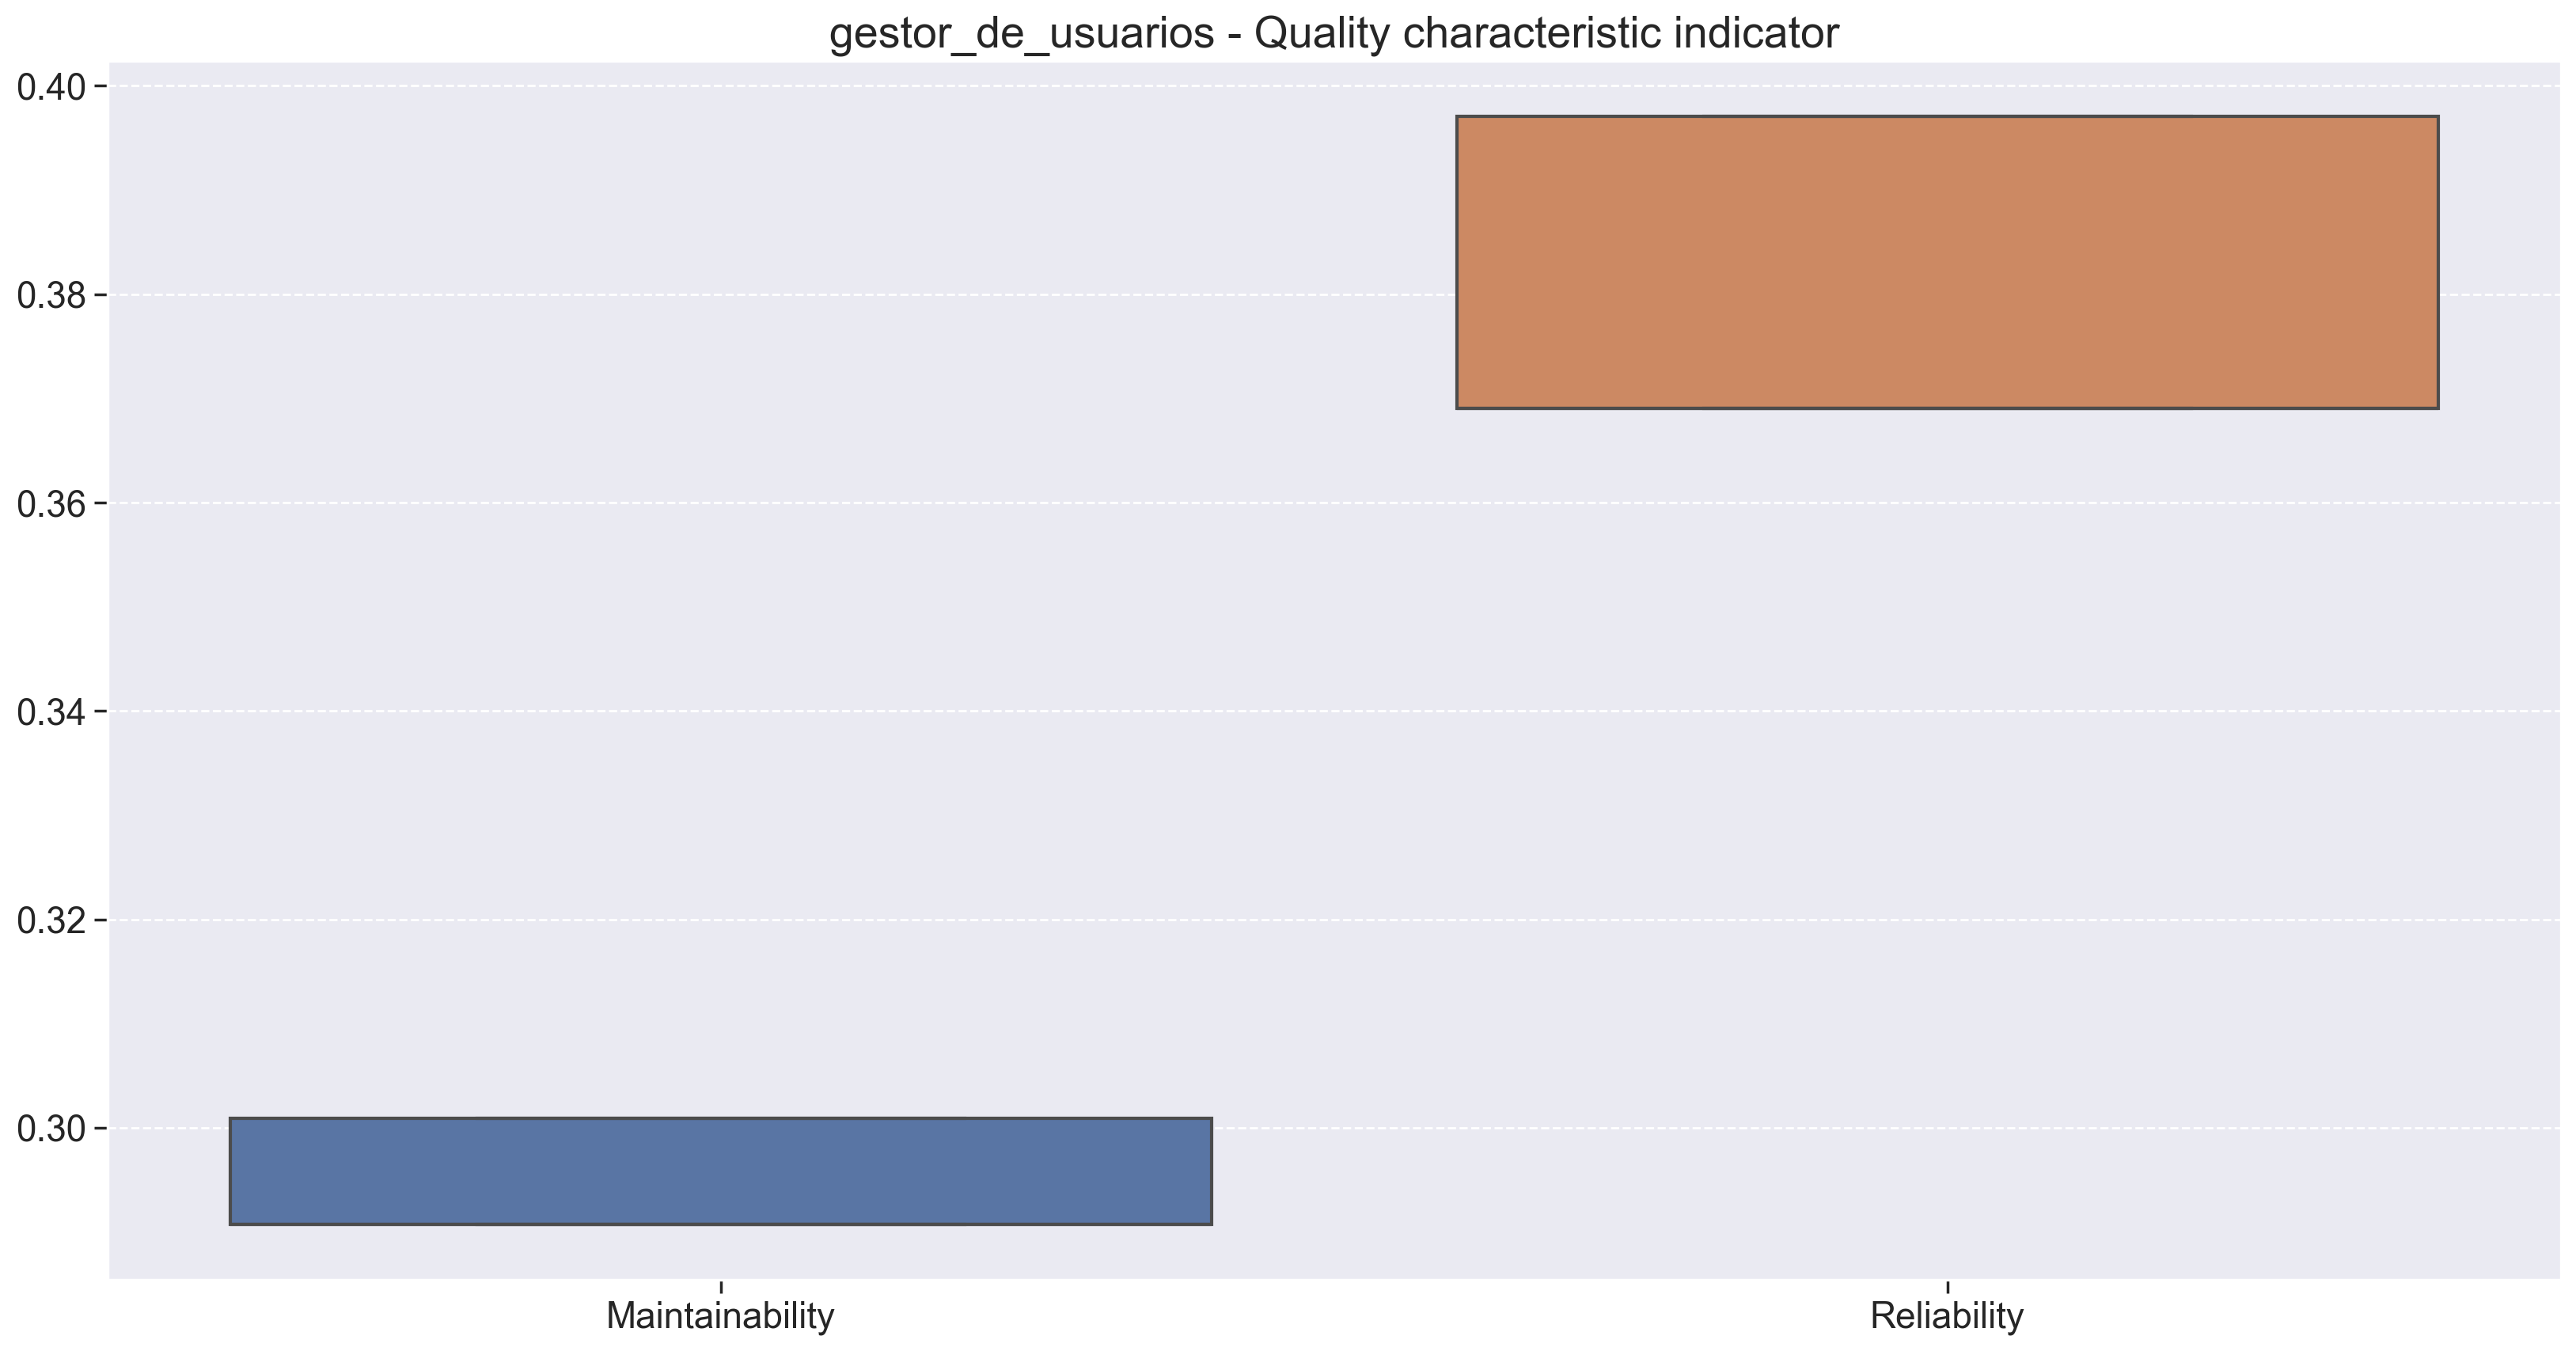

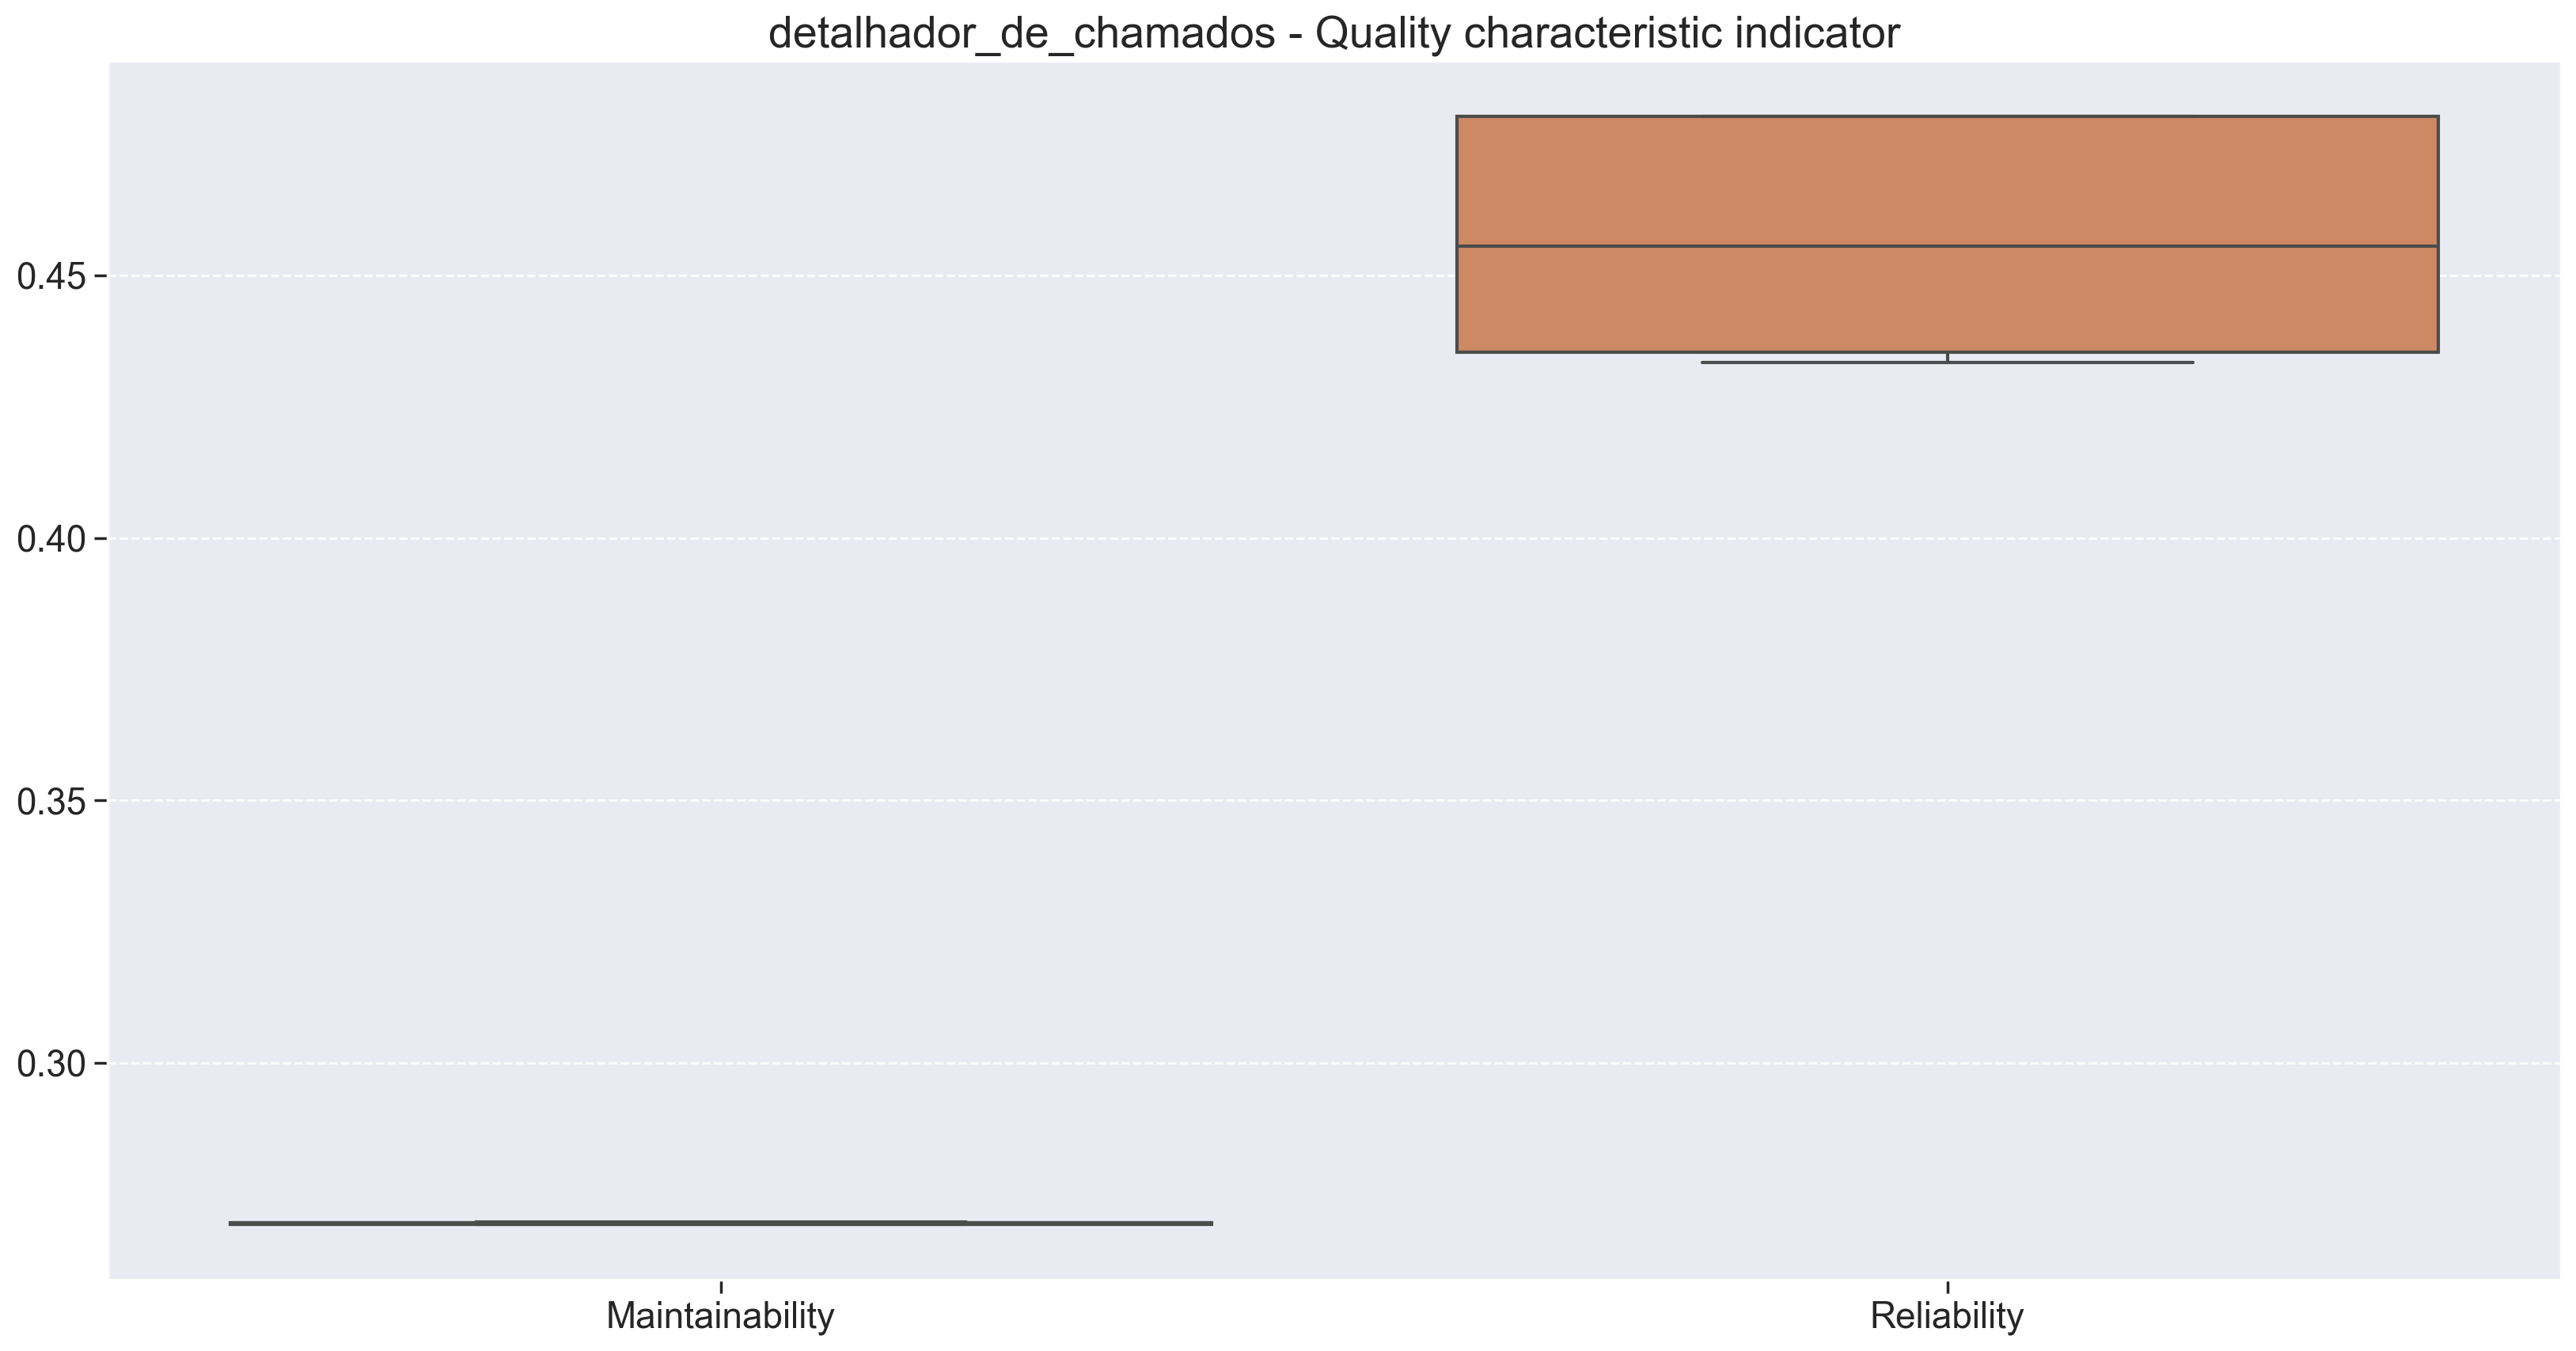

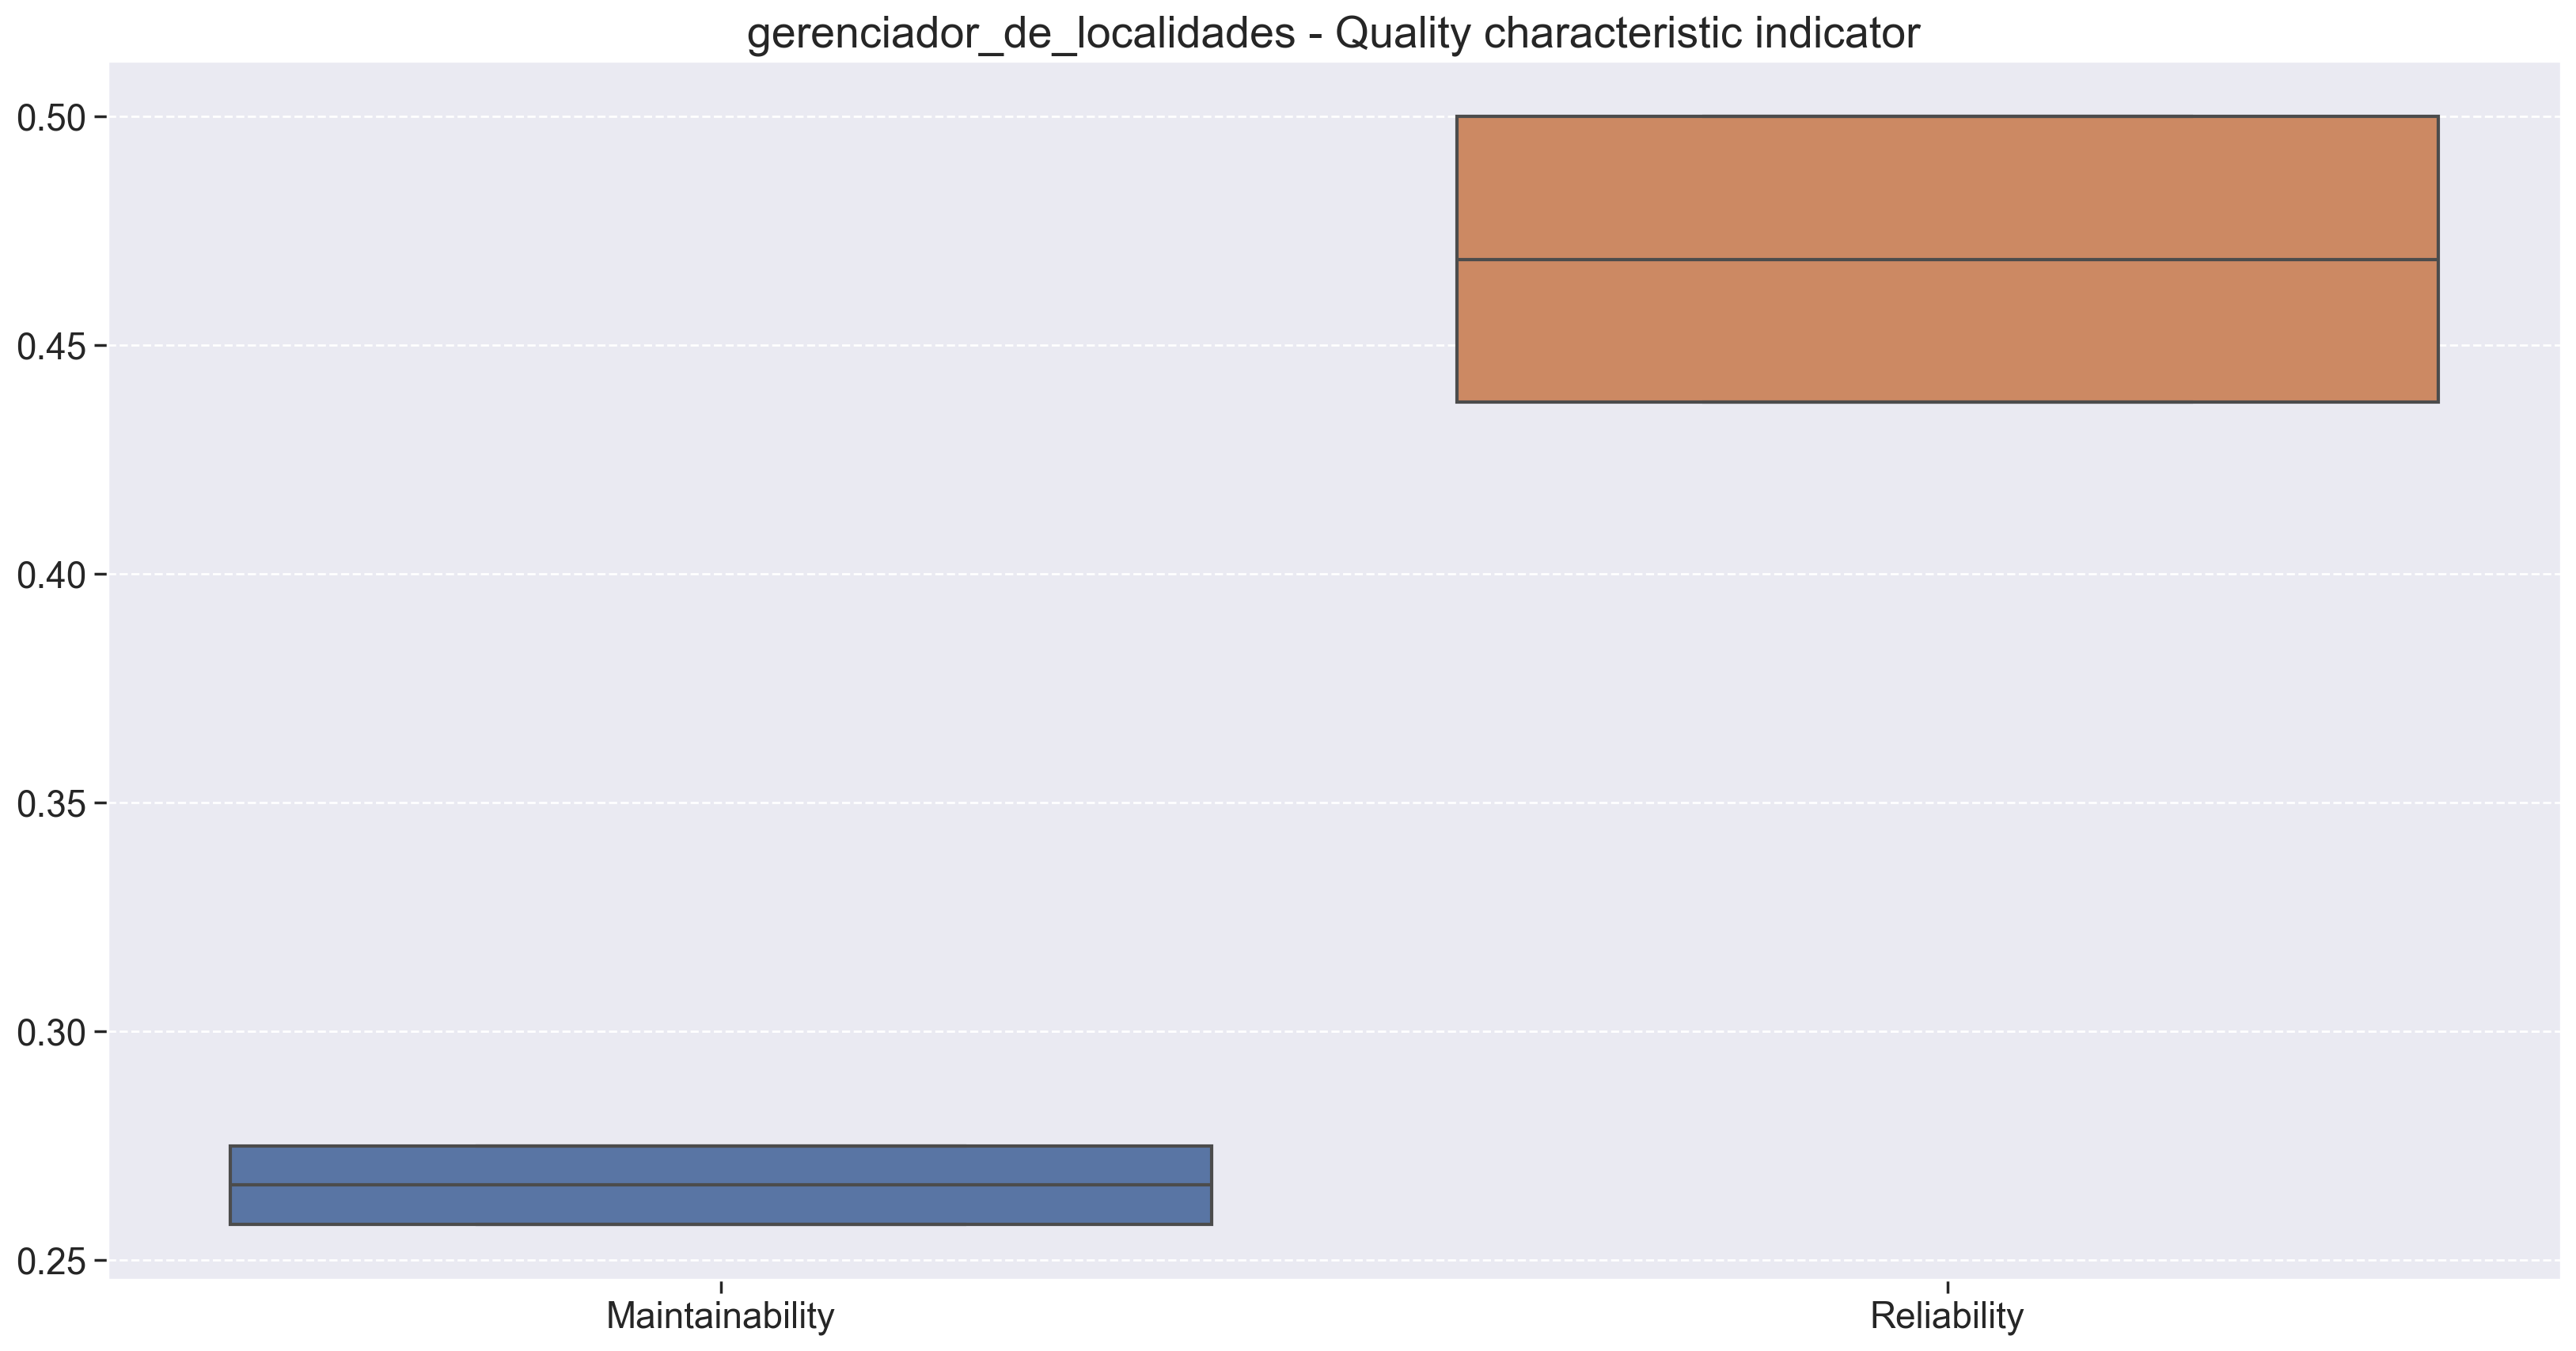

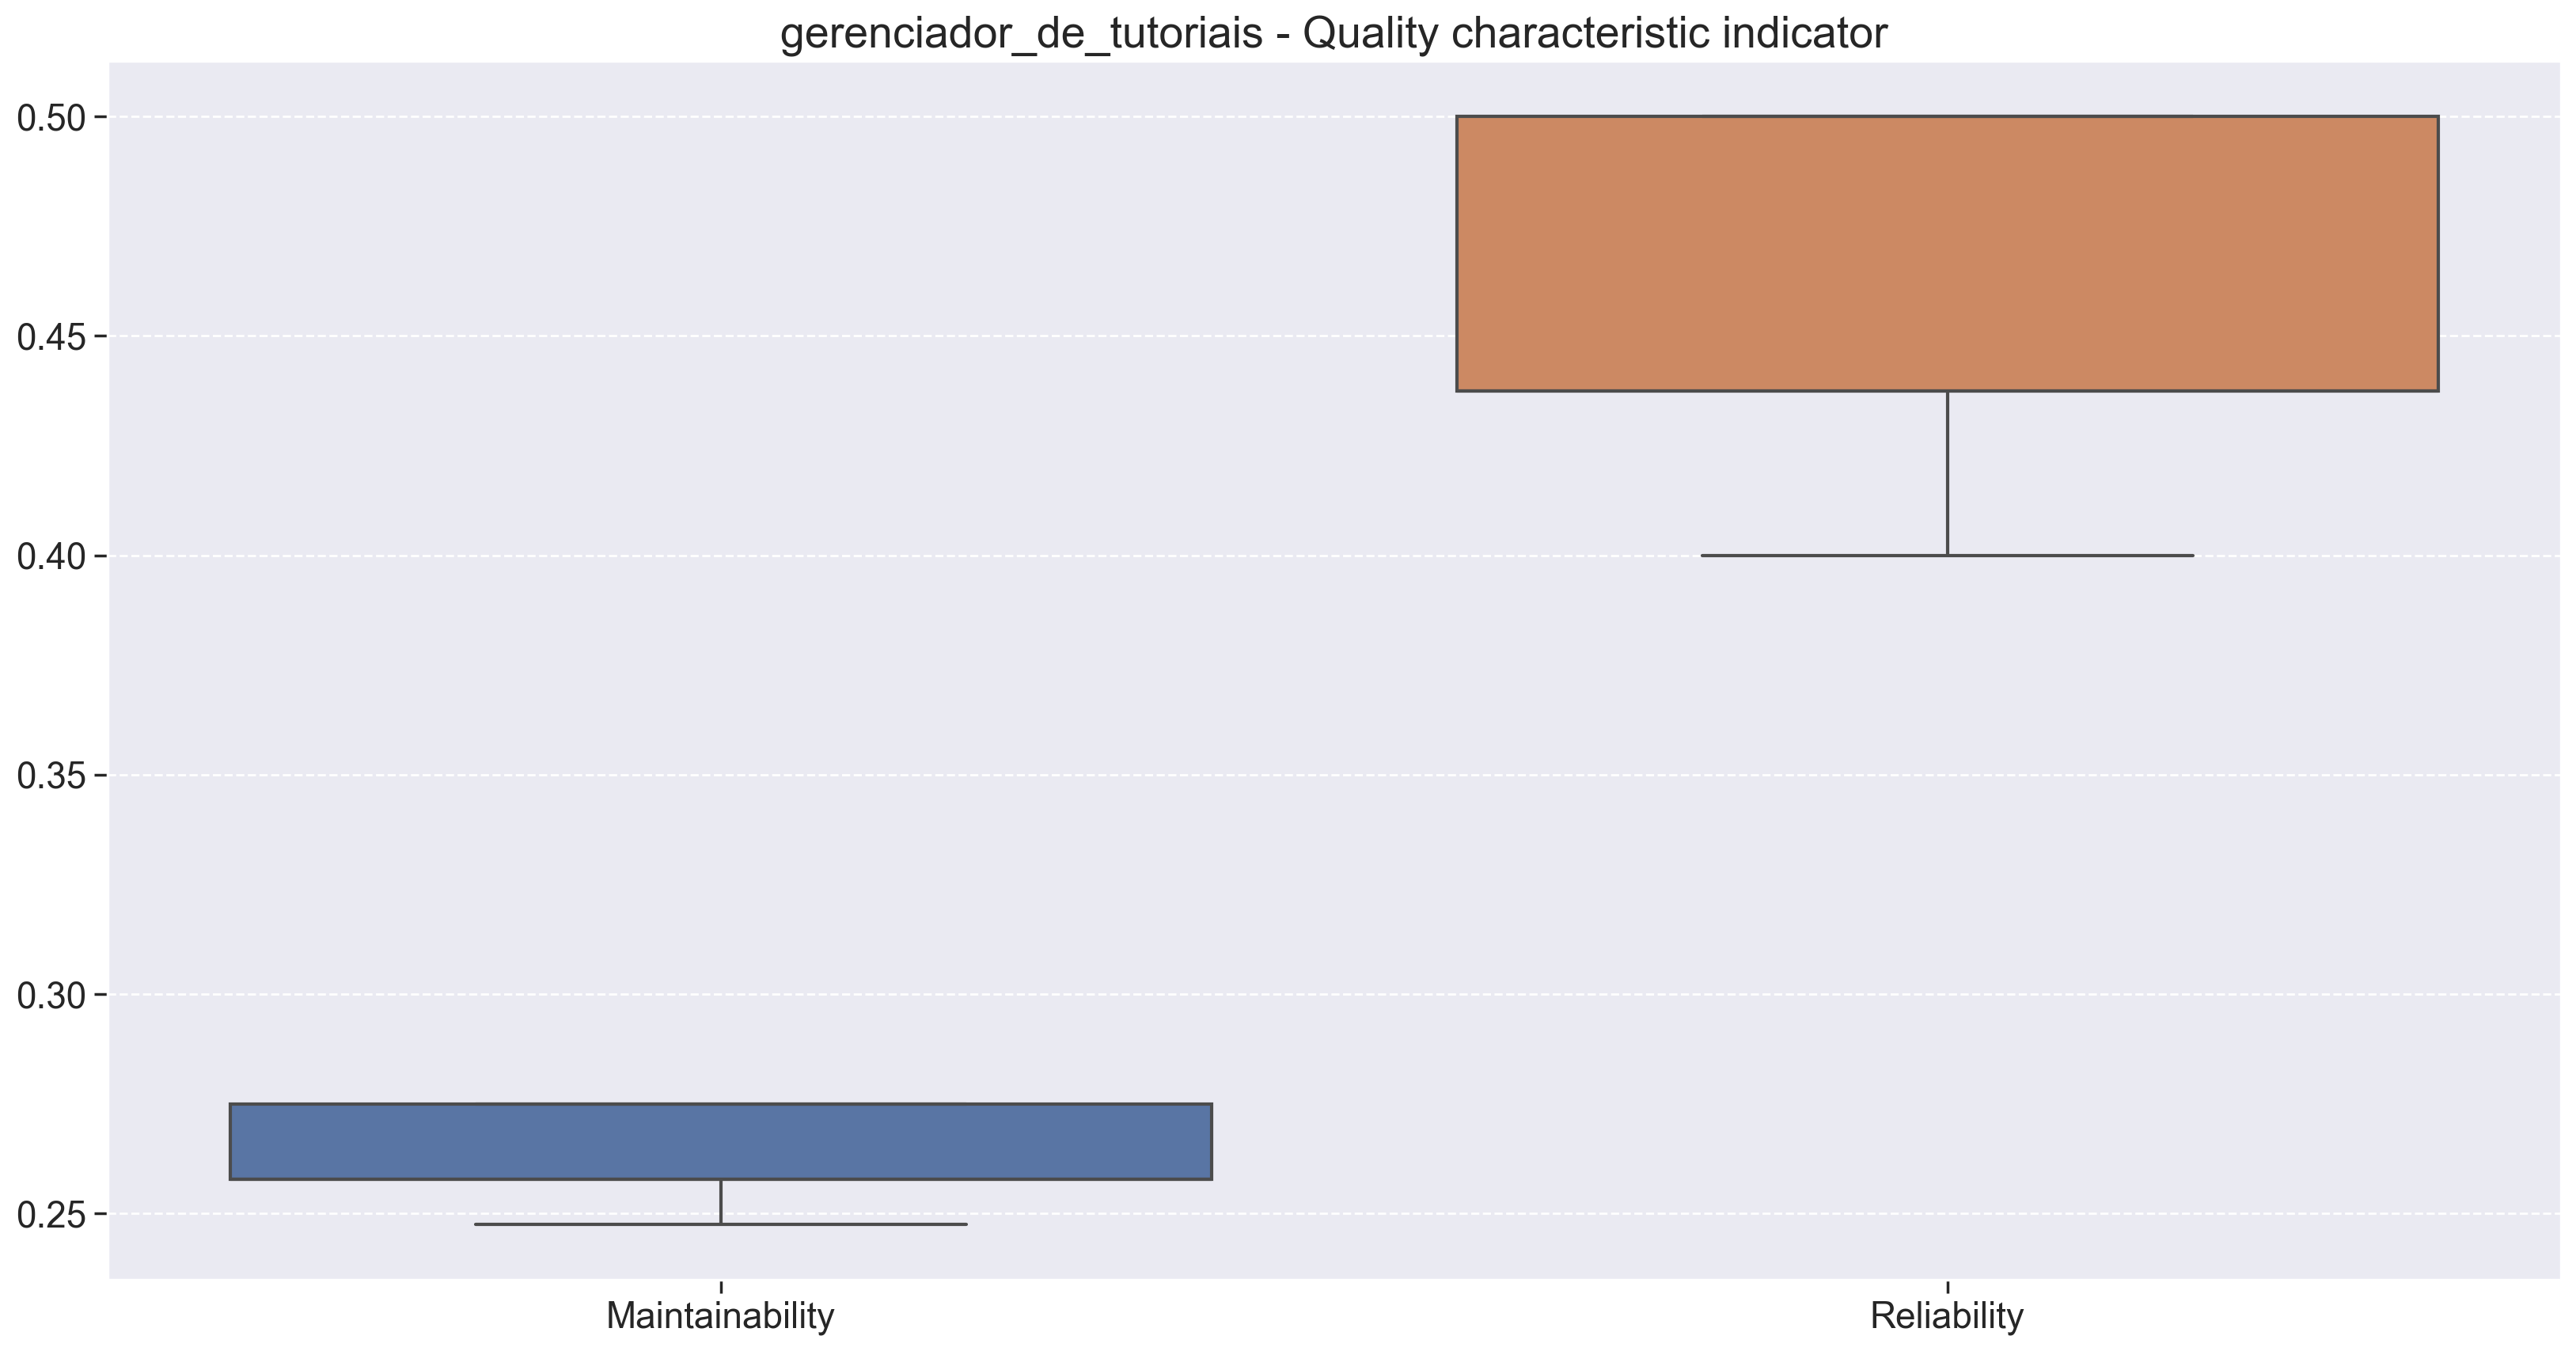

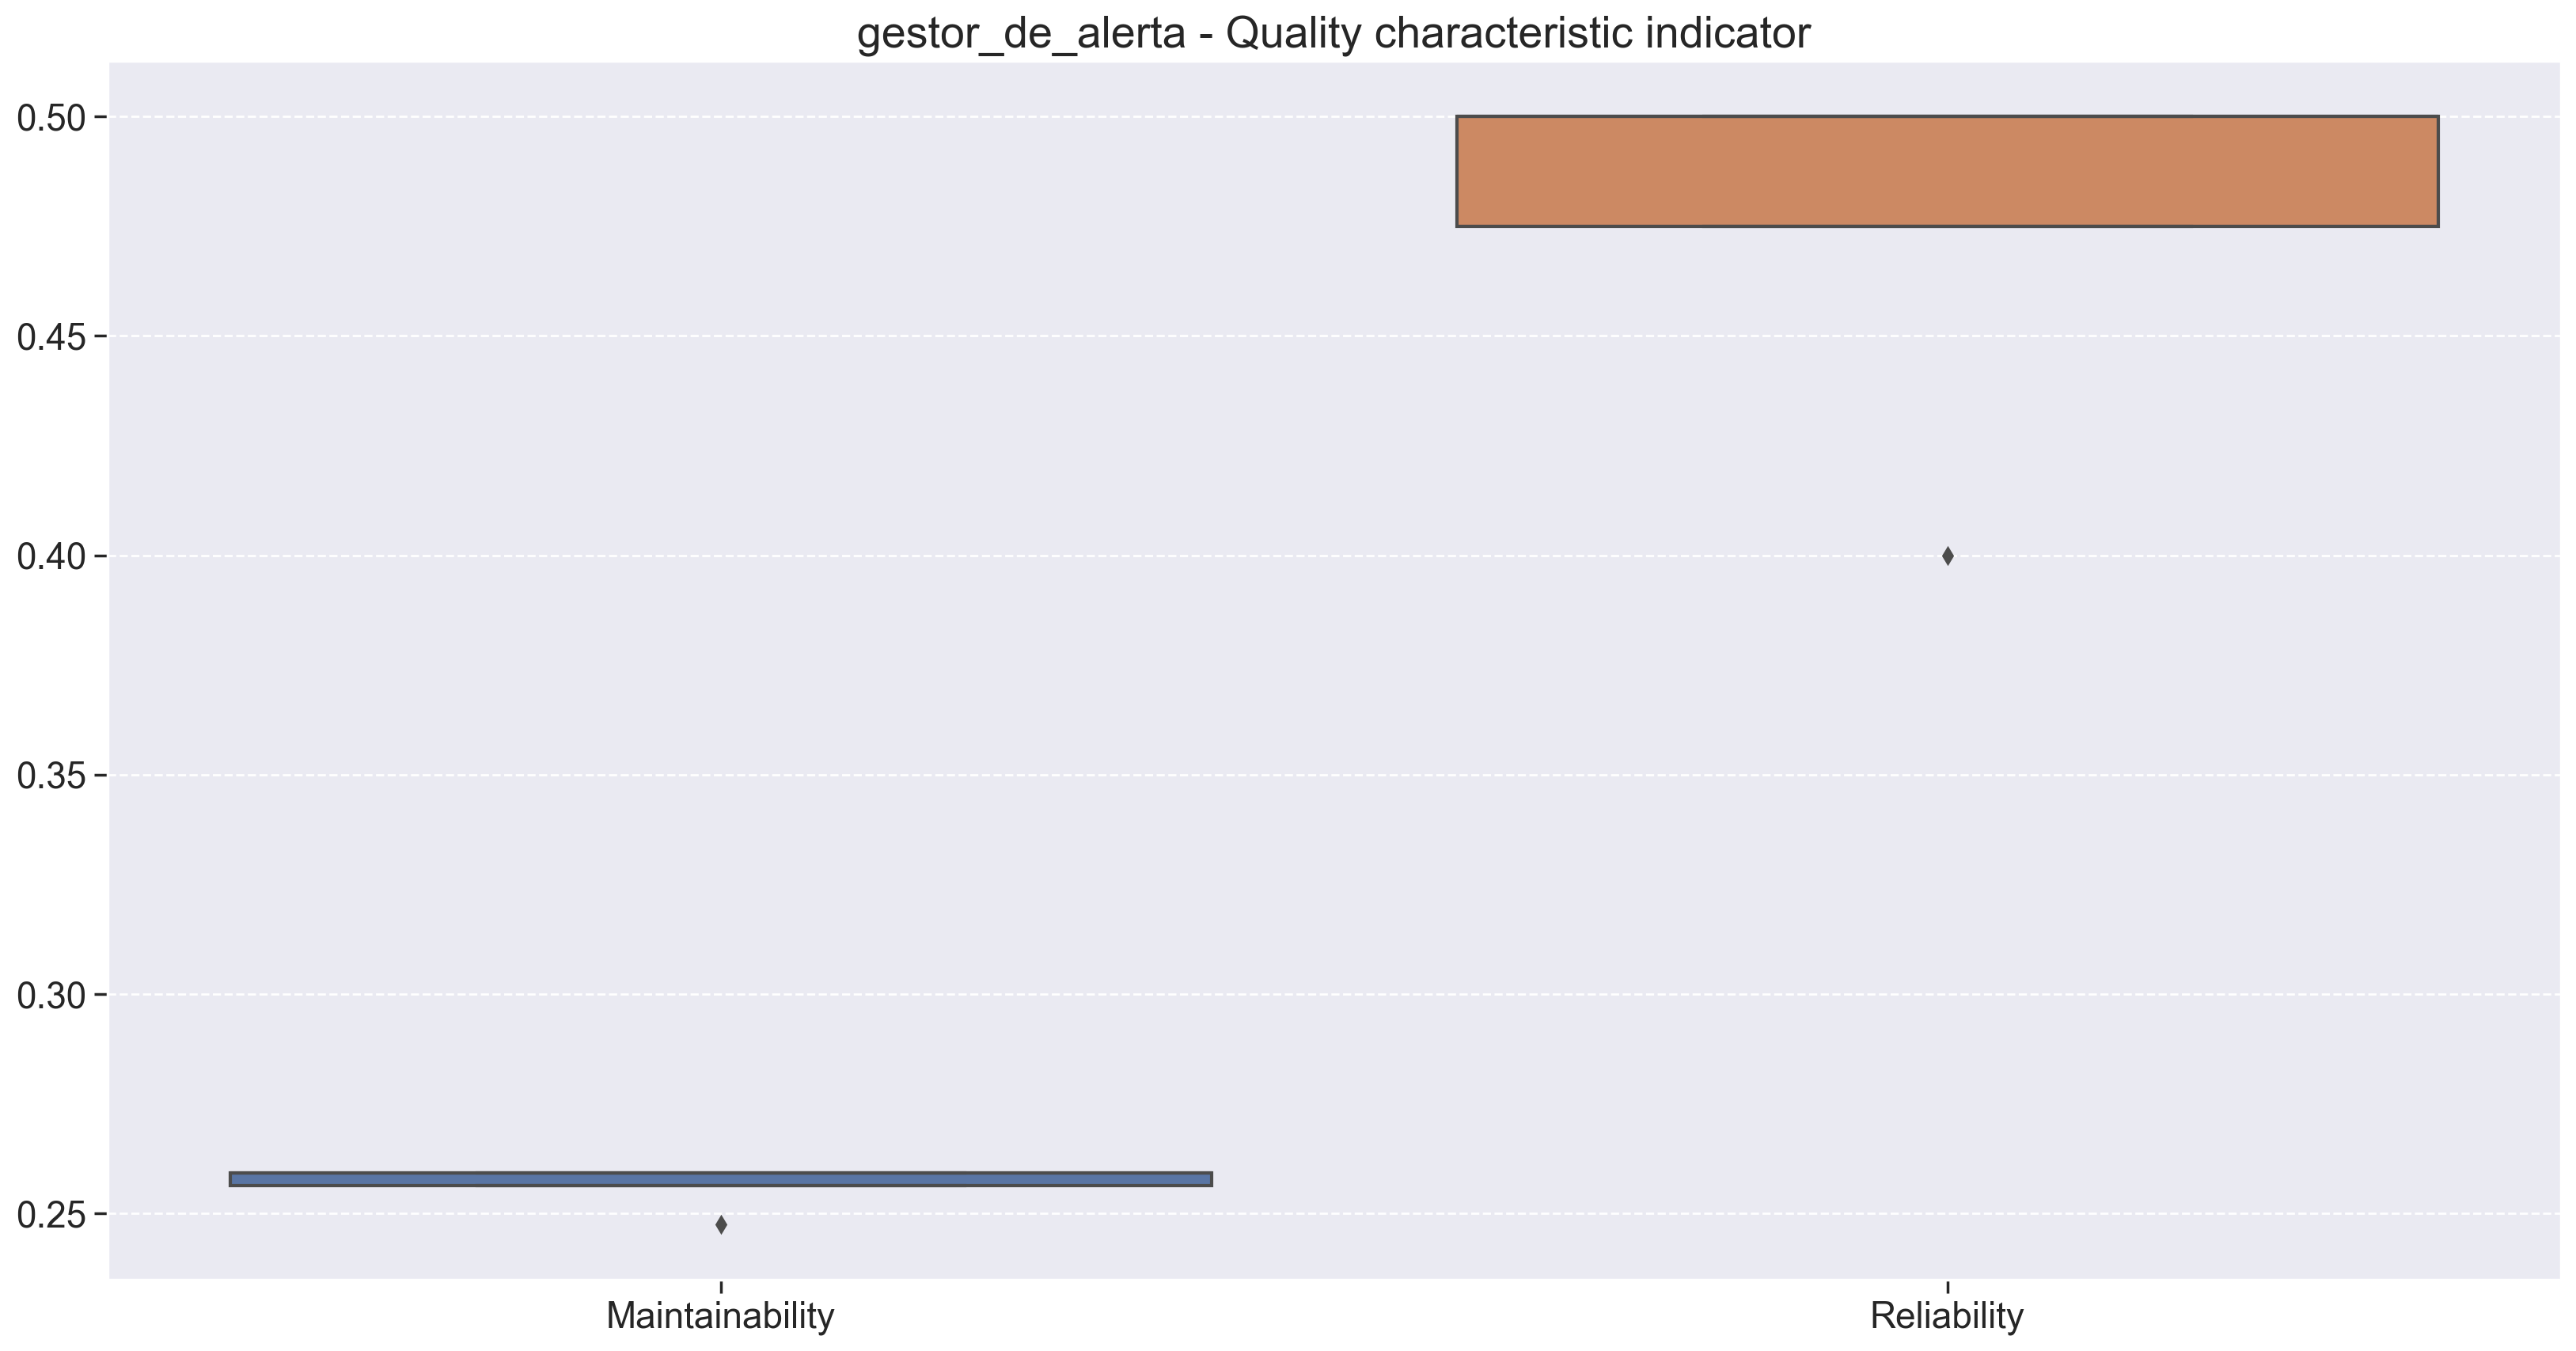

In [64]:

for name, data in metrics.items():
    fig = plt.figure(figsize=(20, 10))
    sns.boxplot(data=data[['Maintainability','Reliability']])

    plt.title(f"{name} - Quality characteristic indicator", fontsize=20)
    plt.show()

### Quality indicator visualization

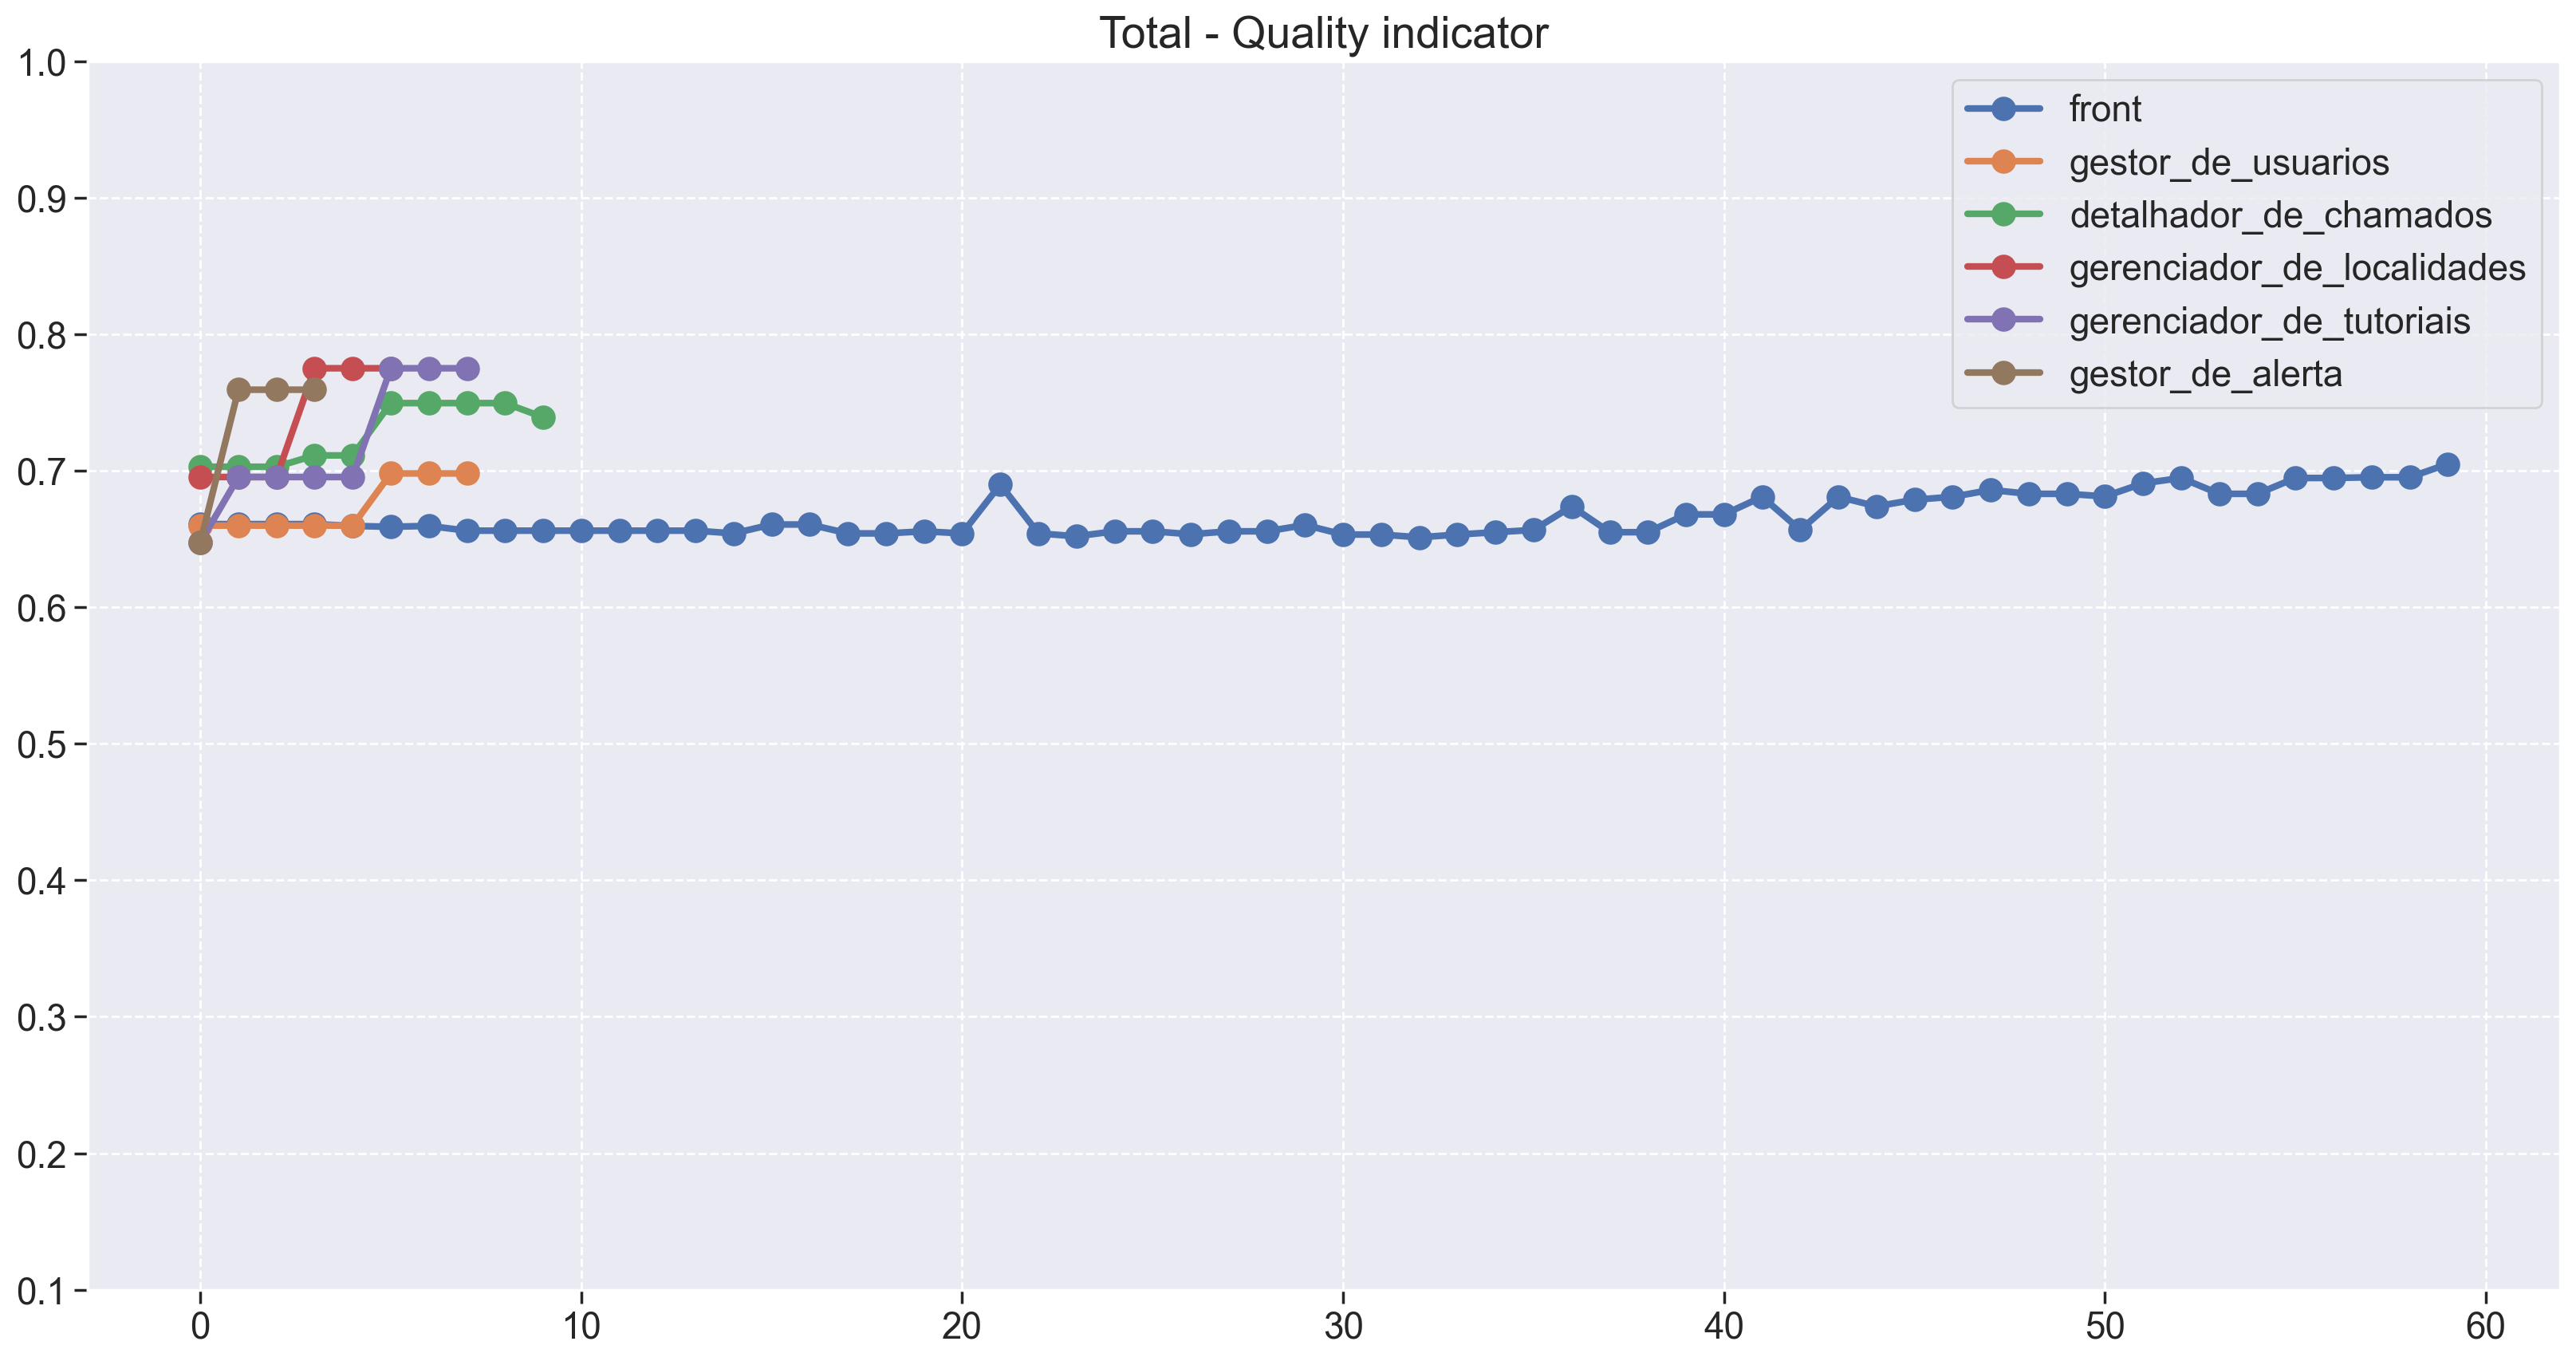

In [65]:
fig = plt.figure(figsize=(20, 10))

for name, data in metrics.items():
    plt.plot(data['total'], linewidth=3, marker='o', markersize=10, label=name)

plt.ylim(.1,1)
plt.title("Total - Quality indicator", fontsize=20)
plt.legend(loc='best')
plt.show()

## Export data

In [66]:
metrics_list = metrics.values()

metrics_df = pd.concat(metrics_list, ignore_index=True)

display(metrics_df)

current_datetime = datetime.datetime.now().strftime("%m-%d-%Y--%H-%M-%S")

metrics_df.to_excel('../data/fga-eps-mds-2023-1-schedula--{}.xlsx'.format(current_datetime), index = False)

metrics_df.to_csv('../data/fga-eps-mds-2023-1-schedula--{}.csv'.format(current_datetime), index = False)

m1        m2        m3   m4   m5        m6  \
0   0.850000  0.000000  0.983333  1.0  1.0  0.433333   
1   0.850000  0.000000  0.983333  1.0  1.0  0.433333   
2   0.850000  0.000000  0.983333  1.0  1.0  0.433333   
3   0.850000  0.000000  0.983333  1.0  1.0  0.433333   
4   0.852459  0.000000  0.983607  1.0  1.0  0.426230   
5   0.853659  0.000000  0.983740  1.0  1.0  0.422764   
6   0.852459  0.000000  0.983607  1.0  1.0  0.426230   
7   0.856061  0.000000  0.984848  1.0  1.0  0.409091   
8   0.856061  0.000000  0.984848  1.0  1.0  0.409091   
9   0.856061  0.000000  0.984848  1.0  1.0  0.409091   
10  0.856061  0.000000  0.984848  1.0  1.0  0.409091   
11  0.856061  0.000000  0.984848  1.0  1.0  0.409091   
12  0.856061  0.000000  0.984848  1.0  1.0  0.409091   
13  0.856061  0.000000  0.984848  1.0  1.0  0.409091   
14  0.858108  0.000000  0.986486  1.0  1.0  0.398649   
15  0.845588  0.000000  0.985294  1.0  1.0  0.433824   
16  0.845588  0.000000  0.985294  1.0  1.0  0.433824   
17  0.858108  0.000000  0.986486  1.0  1.0  0.398649   
18  0.858108  0.000000  0.986486  1.0  1.0  0.398649   
19  0.855172  0.000000  0.986207  1.0  1.0  0.406897   
20  0.858108  0.000000  0.986486  1.0  1.0  0.398649   
21  0.834254  0.000000  0.977901  1.0  1.0  0.563536   
22  0.858108  0.000000  0.986486  1.0  1.0  0.398649   
23  0.853333  0.000000  0.986667  1.0  1.0  0.393333   
24  0.855172  0.000000  0.986207  1.0  1.0  0.406897   
25  0.855172  0.000000  0.986207  1.0  1.0  0.406897   
26  0.850340  0.000000  0.986395  1.0  1.0  0.401361   
27  0.855172  0.000000  0.986207  1.0  1.0  0.406897   
28  0.855172  0.000000  0.986207  1.0  1.0  0.406897   
29  0.850340  0.000000  0.986395  1.0  1.0  0.428571   
30  0.854305  0.000000  0.947020  1.0  1.0  0.423841   
31  0.854305  0.000000  0.947020  1.0  1.0  0.423841   
32  0.849673  0.000000  0.947712  1.0  1.0  0.418301   
33  0.854305  0.000000  0.947020  1.0  1.0  0.423841   
34  0.848684  0.000000  0.947368  1.0  1.0  0.434211   
35  0.848684  0.000000  0.947368  1.0  1.0  0.440789   
36  0.845161  0.000000  0.961290  1.0  1.0  0.503226   
37  0.848684  0.000000  0.947368  1.0  1.0  0.434211   
38  0.848684  0.000000  0.947368  1.0  1.0  0.434211   
39  0.846154  0.000000  0.948718  1.0  1.0  0.487179   
40  0.846154  0.000000  0.948718  1.0  1.0  0.487179   
41  0.845161  0.000000  0.974194  1.0  1.0  0.522581   
42  0.848684  0.000000  0.947368  1.0  1.0  0.440789   
43  0.845161  0.000000  0.974194  1.0  1.0  0.522581   
44  0.845161  0.000000  0.961290  1.0  1.0  0.503226   
45  0.845161  0.000000  0.961290  1.0  1.0  0.522581   
46  0.845161  0.000000  0.974194  1.0  1.0  0.522581   
47  0.838889  0.000000  0.977778  1.0  1.0  0.544444   
48  0.845361  0.000000  0.943299  1.0  1.0  0.551546   
49  0.845361  0.000000  0.943299  1.0  1.0  0.551546   
50  0.841837  0.000000  0.943878  1.0  1.0  0.545918   
51  0.845361  0.000000  0.943299  1.0  1.0  0.582474   
52  0.845361  0.000000  0.943299  1.0  1.0  0.597938   
53  0.845361  0.000000  0.943299  1.0  1.0  0.551546   
54  0.845361  0.000000  0.943299  1.0  1.0  0.551546   
55  0.845361  0.000000  0.943299  1.0  1.0  0.597938   
56  0.845361  0.000000  0.943299  1.0  1.0  0.597938   
57  0.841837  0.000000  0.943878  1.0  1.0  0.602041   
58  0.841837  0.000000  0.943878  1.0  1.0  0.602041   
59  0.835000  0.000000  0.960000  1.0  1.0  0.635000   
60  0.380952  0.380952  1.000000  1.0  1.0  0.476190   
61  0.380952  0.380952  1.000000  1.0  1.0  0.476190   
62  0.380952  0.380952  1.000000  1.0  1.0  0.476190   
63  0.380952  0.380952  1.000000  1.0  1.0  0.476190   
64  0.380952  0.380952  1.000000  1.0  1.0  0.476190   
65  0.411765  0.411765  1.000000  1.0  1.0  0.588235   
66  0.411765  0.411765  1.000000  1.0  1.0  0.588235   
67  0.411765  0.411765  1.000000  1.0  1.0  0.588235   
68  0.633333  0.000000  1.000000  1.0  1.0  0.733333   
69  0.633333  0.000000  1.000000  1.0  1.0  0.733333   
70  0.633333  0.000000  1.000000  

# Atividades de analytics 

## Questões a serem respondidas sobre a qualidade do produto

1) No  microsserviço de backend que apresentar o pior indicador de manutenibilidade indique qual(is) o(s) módulos/arquivos mais críticos e explique como seu time tratou esse problema.

    O microsserviço que apresentou o pior indicador de manutenibilidade foi o Gestor de Alertas. Dada que a manutenibilidade é uma medida de complexidade, comentários e duplicação, o microsserviços possui as seguintes taxas de duplicação e comentários, sendo respectivamente, 1 (sem duplicação) e 0 (sem comentários). 
    No contexto de complexidade, o microsserviço apresenta a taxa de complexidade mais crítica no arquivo alerts.service.ts, já que é um arquivo que possui a estrutura para gerenciar o CRUD do microsserviço.

    Gestor de Alertas:
    
        - src/alerts/alerts.service.ts: complexidade ciclomática de 9, e complexidade cognitiva de 6.

    Nesse contexto, tratamos de um CRUD básico e essencial desenvolvido em nest.js, e considerando que ele foi construído da forma mais simples possível, baseado no conhecimento técnico da equipe, não foi necessário realizar nenhuma ação para tratar o problema. Além disso, entendemos que tal complexidade não afetou significativamente a manutenibilidade do microsserviço como produto.

2) No microsserviço que apresentar o pior indicador de confiabilidade, explique como seu time tratou esse problema.

    O microsserviço que apresentou o pior indicador de confiabilidade foi o Gestor de Usuários. Dada que a confiabilidade é uma medida de testes, cobertura de testes e testes rápidos, analisamos que havia possibilidades de melhorias de testes no microsserviço, já que inicialmente a sua confiabilidade não estava no nível ideal. Com isso a equipe conseguiu aumentar essa taxa de 0.369048 para 0.397059, realizando testes unitários que fez com que a cobertura de testes aumentasse.
    No contexto geral, em todos os microsserviços, a taxa de confiabilidade aumentou também devido a retirada de arquivos .module.ts, que não são testáveis, e que estavam sendo contabilizados no cálculo da confiabilidade.


3) Explique o comportamento da qualidade do produto, observada ao longo do tempo do desenvolvimento, do projeto relacionado ao seu time.

    Analisando o comportamento da qualidade do produto, observamos que ela foi aumentando ao longo do tempo do desenvolvimento do projeto. 
    No contexto do front, é possível perceber uma variação ao longo do tempo, dada principalmente pela entrega de funcionalidade e US's sem a devida cobertura de testes, o que fez com que a taxa de qualidade tivessem quedas. Porém, em sprints seguintes, a equipe se comprometeu a aumentar a cobertura de testes, o que fez com que a taxa de qualidade aumentasse.
    No contexto dos microsserviços, é notável que a qualidade do produto aumentou ao longo do tempo, devido a retirada de arquivos .module.ts, que não são testáveis, e ao aumento da cobertura de testes, como pode ser visto principalmente no microsserviço de Gestor de Alertas que está com 100% de cobertura de testes.
